In [67]:
# If you need packages: uncomment and run once
# !pip install pandas numpy statsmodels scikit-learn tqdm

import os, re, gc, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.api import OLS, add_constant

warnings.simplefilter("ignore", category=FutureWarning)

# --- Paths (adjust if your notebook sits elsewhere)
ROOT = Path("Data").resolve()
DL   = ROOT                       # all your CSVs live right here
OUT  = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("OUT :", OUT)

ROOT: /Users/ishanbhardwaj/Downloads/Airline Data/Data
OUT : /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs


In [68]:
import os
from dotenv import load_dotenv
load_dotenv()

SOCRATA_APP_TOKEN = os.getenv("SOCRATA_APP_TOKEN")
FRED_API_KEY      = os.getenv("FRED_API_KEY")
IEX_TOKEN         = os.getenv("IEX_TOKEN")
EIA_API_KEY       = os.getenv("EIA_API_KEY")

In [69]:
def to_month_end(s):
    return pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")

def pick_col(df, candidates, required=False, label=""):
    cols = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in cols:
            return cols[c.lower()]
    if required:
        raise KeyError(f"Required column not found for {label}: tried {candidates}")
    return None

def zscore_by_month(df, value_col):
    t = df[["date","carrier",value_col]].copy()
    def _z(g):
        v = g[value_col].astype(float)
        s = v.std(ddof=0)
        return (v - v.mean()) / (s if (pd.notna(s) and s != 0) else 1.0)
    t[value_col + "_z"] = t.groupby("date", group_keys=False).apply(_z)
    return t

In [70]:
def load_t100_from_folder(root: Path):
    paths = []
    paths += sorted(root.glob("T_T100D_SEGMENT_ALL_CARRIER*.csv"))
    paths += sorted(root.glob("t100_segment_*.csv"))
    if not paths:
        raise FileNotFoundError(f"No T-100 files found under {root}")

    chunks = []
    for p in paths:
        print("Reading:", p.name)
        for ch in pd.read_csv(p, chunksize=250_000, dtype=str, low_memory=False):
            year  = pick_col(ch, ["YEAR"], True, "YEAR")
            month = pick_col(ch, ["MONTH"], True, "MONTH")
            uc    = pick_col(ch, ["UNIQUE_CARRIER","OP_UNIQUE_CARRIER","REPORTING_CARRIER","CARRIER"], True, "CARRIER")
            org   = pick_col(ch, ["ORIGIN"], True, "ORIGIN")
            dst   = pick_col(ch, ["DEST","DESTINATION"], True, "DEST")
            seats = pick_col(ch, ["SEATS","AVAILABLE_SEATS"], False, "SEATS")
            dist  = pick_col(ch, ["DISTANCE"], False, "DISTANCE")
            pax   = pick_col(ch, ["PASSENGERS"], False, "PASSENGERS")
            asm   = pick_col(ch, ["ASM","ASMS","AVAILABLE_SEAT_MILES","AVAILABLE_SEAT_MILES_(000)"], False, "ASM")
            rpm   = pick_col(ch, ["RPM","RPMS","REVENUE_PASSENGER_MILES","REVENUE_PASSENGER_MILES_(000)"], False, "RPM")

            df = pd.DataFrame({
                "year":   pd.to_numeric(ch[year], errors="coerce"),
                "month":  pd.to_numeric(ch[month], errors="coerce"),
                "carrier": ch[uc].str.strip().str.upper(),
                "origin":  ch[org].str.strip().str.upper(),
                "dest":    ch[dst].str.strip().str.upper(),
            })

            if seats: df["seats"]    = pd.to_numeric(ch[seats], errors="coerce")
            if dist:  df["distance"] = pd.to_numeric(ch[dist],  errors="coerce")
            if pax:   df["pax"]      = pd.to_numeric(ch[pax],   errors="coerce")

            if asm:
                mult = 1000.0 if "000" in asm.upper() else 1.0
                df["asm"] = pd.to_numeric(ch[asm], errors="coerce") * mult
            if rpm:
                mult = 1000.0 if "000" in rpm.upper() else 1.0
                df["rpm"] = pd.to_numeric(ch[rpm], errors="coerce") * mult

            if "asm" not in df and {"seats","distance"}.issubset(df.columns):
                df["asm"] = df["seats"] * df["distance"]
            if "rpm" not in df and {"pax","distance"}.issubset(df.columns):
                df["rpm"] = df["pax"] * df["distance"]

            df = df.dropna(subset=["year","month","carrier","origin","dest"])
            df["date"] = to_month_end(
                pd.to_datetime(
                    df["year"].astype(int).astype(str) + "-" + df["month"].astype(int).astype(str) + "-01",
                    errors="coerce"
                )
            )
            df = df.dropna(subset=["date"])
            chunks.append(df)
        gc.collect()

    t100 = pd.concat(chunks, ignore_index=True)

    # Route monthly
    route = (t100.groupby(["date","origin","dest","carrier"], as_index=False)
                  .agg(asm=("asm","sum"),
                       rpm=("rpm","sum"),
                       seats=("seats","sum"),
                       distance=("distance","mean"),
                       passengers=("pax","sum")))

    # Seat share + HHI
    if "seats" in route and not route["seats"].isna().all():
        tot = route.groupby(["date","origin","dest"], as_index=False)["seats"].sum().rename(columns={"seats":"route_seats"})
        route = route.merge(tot, on=["date","origin","dest"], how="left")
        route["seat_share"] = route["seats"] / route["route_seats"]
        hhi = (route.assign(sq=lambda x: (x["seat_share"].fillna(0.0)**2))
                    .groupby(["date","origin","dest"], as_index=False)["sq"].sum()
                    .rename(columns={"sq":"HHI"}))
        route = route.merge(hhi, on=["date","origin","dest"], how="left")
    else:
        route["seat_share"] = np.nan
        route["HHI"] = np.nan

    # Convenience
    route["route_key"] = route["origin"] + "-" + route["dest"]

    # Carrier-month
    car_month = (t100.groupby(["date","carrier"], as_index=False)
                      .agg(asm=("asm","sum"),
                           rpm=("rpm","sum"),
                           seats=("seats","sum")))

    return t100, route, car_month

print("✈️ Loading T-100…")
t100, route, car_month = load_t100_from_folder(ROOT)
print("Route rows:", len(route), "| car_month rows:", len(car_month))

✈️ Loading T-100…
Reading: T_T100D_SEGMENT_ALL_CARRIER 2.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 3.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 4.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 5.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 6.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 7.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 8.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER 9.csv
Reading: T_T100D_SEGMENT_ALL_CARRIER.csv
Reading: t100_segment_2017.csv
Reading: t100_segment_2018.csv
Reading: t100_segment_2019.csv
Reading: t100_segment_2020.csv
Reading: t100_segment_2021.csv
Reading: t100_segment_2022.csv
Reading: t100_segment_2023.csv
Reading: t100_segment_2024.csv
Reading: t100_segment_2025.csv
Route rows: 1953570 | car_month rows: 14670


In [71]:
def read_form41_glob(root: Path, base: str):
    files = sorted(root.glob(f"{base}*.csv"))
    if not files:
        print(f"[WARN] No files matching {base}*.csv in {root}")
        return pd.DataFrame()
    dfs = []
    for f in files:
        try:
            dfs.append(pd.read_csv(f, dtype=str, low_memory=False))
        except Exception as e:
            print(f"[WARN] {f.name}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def rebuild_date(df, label):
    d = df.copy()
    U = {c.upper(): c for c in d.columns}
    if "DATE" in U:
        dt = pd.to_datetime(d[U["DATE"]], errors="coerce")
        if dt.notna().any():
            d["date"] = dt.dt.to_period("M").dt.to_timestamp("M"); return d
    if {"YEAR","MONTH"}.issubset(U):
        y = pd.to_numeric(d[U["YEAR"]], errors="coerce")
        m = pd.to_numeric(d[U["MONTH"]], errors="coerce")
        d["date"] = to_month_end(pd.to_datetime(y.astype(int).astype(str)+"-"+m.astype(int).astype(str)+"-01"))
        return d
    if {"YEAR","QUARTER"}.issubset(U):
        y = pd.to_numeric(d[U["YEAR"]], errors="coerce")
        q = pd.to_numeric(d[U["QUARTER"]], errors="coerce")
        m = (q*3).astype("Int64")
        d["date"] = to_month_end(pd.to_datetime(y.astype(int).astype(str)+"-"+m.astype(int).astype(str)+"-01"))
        return d
    raise KeyError(f"[{label}] Could not rebuild date.")

def ensure_carrier(df):
    d = df.rename(columns=str.lower).copy()
    cand = None
    for c in ["unique_carrier","carrier","op_unique_carrier","reporting_carrier"]:
        if c in d.columns:
            cand = d[c]; break
    if cand is None:
        cand_cols = [c for c in d.columns if "carrier" in c]
        cand = d[cand_cols[0]] if cand_cols else pd.Series(np.nan, index=d.index)
    d["carrier"] = cand.astype(str).str.strip().str.upper().map(lambda s: s[1:] if len(s)==3 and s.startswith("0") else s)
    return d

# --- Read
p52_raw  = read_form41_glob(ROOT, "T_F41SCHEDULE_P52")
p12a_raw = read_form41_glob(ROOT, "T_F41SCHEDULE_P12A")

# --- Standardize
if len(p52_raw):
    p52 = ensure_carrier(rebuild_date(p52_raw, "P52"))
else:
    p52 = pd.DataFrame()
if len(p12a_raw):
    p12a = ensure_carrier(rebuild_date(p12a_raw, "P12A"))
else:
    p12a = pd.DataFrame()

# --- CASM ex fuel from P52 (quarterly → monthly broadcast)
def casm_from_p52_quarterly(p52, car_month):
    if p52.empty: 
        return pd.DataFrame(columns=["date","carrier","CASM_ex_fuel"])
    p = p52.copy()
    # heuristic: sum non-fuel operating cost columns
    cost_cols = [c for c in p.columns if any(term in c.lower() for term in 
                 ["tot_fly_ops","tot_dir_maint","pax_service","aircft_services",
                  "promotion_sales","general_admin"]) and "fuel" not in c.lower()]
    if not cost_cols:
        cost_cols = [c for c in p.columns if any(term in c.lower() for term in ["exp","cost","ops"])
                     and "fuel" not in c.lower()]
    for c in cost_cols:
        p[c] = pd.to_numeric(p[c], errors="coerce")
    p["total_costs_ex_fuel"] = p[cost_cols].sum(axis=1, min_count=1)

    q_agg = (p.groupby(["date","carrier"], as_index=False)
               .agg(total_costs_ex_fuel=("total_costs_ex_fuel","sum")))

    cm = car_month.copy()
    cm["q_date"] = cm["date"].dt.to_period("Q").dt.end_time.dt.to_period("M").dt.to_timestamp("M")
    q_asm = (cm.groupby(["q_date","carrier"], as_index=False)
               .agg(quarterly_asm=("asm","sum")))

    q = q_agg.merge(q_asm, left_on=["date","carrier"], right_on=["q_date","carrier"], how="inner")
    q["CASM_ex_fuel"] = (q["total_costs_ex_fuel"] * 100.0 / q["quarterly_asm"]).replace([np.inf,-np.inf], np.nan)

    # broadcast each quarter value to its 3 months
    rows = []
    for _, r in q.iterrows():
        q_end = pd.Period(r["date"], freq="M")
        for m in [q_end - 2, q_end - 1, q_end]:
            rows.append({"date": m.to_timestamp("M"), "carrier": r["carrier"], "CASM_ex_fuel": r["CASM_ex_fuel"]})
    return pd.DataFrame(rows).drop_duplicates(["date","carrier"])

casm_q = casm_from_p52_quarterly(p52, car_month)

# --- Fuel per ASM from P12A (monthly)
if not p12a.empty:
    p = p12a.copy()
    gallon_cols = [c for c in p.columns if "gallon" in c.lower()]
    if gallon_cols:
        p["fuel_gallons_row"] = p[gallon_cols].apply(pd.to_numeric, errors="coerce").sum(axis=1, min_count=1)
        p12g = (p.groupby(["date","carrier"], as_index=False)
                  .agg(fuel_gallons=("fuel_gallons_row","sum")))
        fpa = car_month[["date","carrier","asm"]].merge(p12g, on=["date","carrier"], how="left")
        fpa["fuel_per_asm"] = fpa["fuel_gallons"] / fpa["asm"]
    else:
        fpa = car_month[["date","carrier","asm"]].copy()
        fpa["fuel_per_asm"] = np.nan
else:
    fpa = car_month[["date","carrier","asm"]].copy()
    fpa["fuel_per_asm"] = np.nan

# --- Final cost table
cost = (car_month[["date","carrier","asm"]]
        .merge(casm_q, on=["date","carrier"], how="left")
        .merge(fpa[["date","carrier","fuel_per_asm"]], on=["date","carrier"], how="left"))

print("cost rows:", len(cost), "| CASM_ex_fuel % non-null:", cost["CASM_ex_fuel"].notna().mean())

cost rows: 14670 | CASM_ex_fuel % non-null: 0.15991820040899796


In [72]:
# Prefer your local car_table1a_airport_pairs.csv (already downloaded)
car_1a_path = DL / "car_table1a_airport_pairs.csv"
car_1a = pd.DataFrame()

if car_1a_path.exists():
    raw = pd.read_csv(car_1a_path, dtype=str, low_memory=False)
    def fc(cands): return pick_col(raw, cands)
    y = fc(["year"]); q = fc(["quarter","qtr"])
    o = fc(["origin_airport","origin","origin_iata"])
    d = fc(["destination_airport","dest","destination"])
    f = fc(["average_fare","mean_fare","market_fare","fare"])
    dist = fc(["market_distance","ticket_distance","distance"])
    if all([y,q,o,d,f]):
        c = raw[[y,q,o,d,f]].copy()
        c.columns = ["year","quarter","origin","dest","avg_fare"]
        if dist:
            c["fare_distance"] = pd.to_numeric(raw[dist], errors="coerce")
        c["origin"] = c["origin"].str.strip().str.upper()
        c["dest"]   = c["dest"].str.strip().str.upper()
        c["avg_fare"] = pd.to_numeric(c["avg_fare"], errors="coerce")
        c["year"] = pd.to_numeric(c["year"], errors="coerce")
        c["quarter"] = pd.to_numeric(c["quarter"], errors="coerce")
        c = c.dropna(subset=["year","quarter","origin","dest","avg_fare"])
        c["date"] = to_month_end(pd.to_datetime(c["year"].astype(int).astype(str) + "-" + (c["quarter"]*3).astype(int).astype(str) + "-01"))
        # backfill distance if needed from T-100
        if "fare_distance" not in c or c["fare_distance"].isna().all():
            dlookup = (route.groupby(["origin","dest"], as_index=False)
                             .agg(avg_distance=("distance","mean")))
            c = c.merge(dlookup, on=["origin","dest"], how="left")
            c["fare_distance"] = c["fare_distance"].fillna(c["avg_distance"])
        c = c.dropna(subset=["fare_distance"])
        c = c[c["fare_distance"] > 0]
        c["yield_per_mile"] = c["avg_fare"] / c["fare_distance"]
        car_1a = c[["date","origin","dest","yield_per_mile"]].dropna()

# Build route2
route2 = route.copy()
if len(car_1a):
    route2 = (route2.merge(car_1a, on=["date","origin","dest"], how="left")
                     .sort_values(["origin","dest","date"]))
    route2["yield_per_mile"] = route2.groupby(["origin","dest"])["yield_per_mile"].ffill()
else:
    route2["yield_per_mile"] = np.nan

# ASM-weighted avg stage per carrier-month
r = route2.dropna(subset=["distance"]).copy()
r["wASM"] = r["asm"].fillna(0.0)
stage = (r.groupby(["date","carrier"], as_index=False)
           .apply(lambda g: pd.Series({"avg_stage": np.average(g["distance"], weights=g["wASM"]) if g["wASM"].sum()>0 else np.nan}))
           .reset_index(drop=True))

# Stage-cost curve each month: CASM_ex_fuel (¢) ~ a + b*log(avg_stage)
cm = cost.merge(stage, on=["date","carrier"], how="left")
params = []
for dt, g in cm.dropna(subset=["CASM_ex_fuel","avg_stage"]).groupby("date"):
    if g["carrier"].nunique() < 3:  # need cross-section
        continue
    X = add_constant(np.log(g["avg_stage"].astype(float).values))
    y = g["CASM_ex_fuel"].astype(float).values
    try:
        fit = OLS(y, X).fit()
        a, b = fit.params.tolist()
        params.append({"date": dt, "a": a, "b": b})
    except Exception:
        pass
stage_curve = pd.DataFrame(params)

# Predict variable CASM by route distance; convert ¢ → $
route2 = route2.merge(stage_curve, on="date", how="left")
route2["predicted_casm_cents"]   = (route2["a"] + route2["b"] * np.log(route2["distance"].clip(lower=1))).clip(lower=0)
route2["predicted_casm_dollars"] = route2["predicted_casm_cents"] / 100.0

# Load factor & revenue/profit per ASM
route2["load_factor"] = (route2["rpm"] / route2["asm"]).replace([np.inf,-np.inf], np.nan)
route2["revenue_per_asm"] = route2["yield_per_mile"] * route2["load_factor"]
route2["profit_per_asm"]  = route2["revenue_per_asm"] - route2["predicted_casm_dollars"]

print("route2 built:", len(route2))
route2.to_csv(OUT/"route2_with_profitability.csv", index=False)
print("💾 saved:", OUT/"route2_with_profitability.csv")

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/2354905687.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"avg_stage": np.average(g["distance"], weights=g["wASM"]) if g["wASM"].sum()>0 else np.nan}))


route2 built: 1953570
💾 saved: /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/route2_with_profitability.csv


In [73]:
import numpy as np
import pandas as pd

# --- 1) Robust CASM_ex_fuel column pick (caps or lower)
casm_col = "CASM_ex_fuel" if "CASM_ex_fuel" in cost.columns else \
           "casm_ex_fuel" if "casm_ex_fuel" in cost.columns else None
if casm_col is None:
    raise KeyError("`cost` must contain CASM_ex_fuel (any case). Columns: %s" % list(cost.columns))

# --- 2) rpp_neutral: revenue/ASM – (CASM_ex_fuel in $)
tmp = route2.merge(cost[["date","carrier",casm_col]], on=["date","carrier"], how="left")
tmp["casm_ex_fuel_dollars"] = pd.to_numeric(tmp[casm_col], errors="coerce") / 100.0
tmp["rpp_neutral_route"]    = tmp["revenue_per_asm"] - tmp["casm_ex_fuel_dollars"]

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"])
w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2 = panel2.drop(columns=["rpp_neutral_sum"])

# --- 3) Efficiency inputs: merge car_month safely (rename to avoid asm/rpm collision)
cm = (car_month[["date","carrier","asm","rpm"]]
        .rename(columns={"asm":"asm_cm","rpm":"rpm_cm"})).copy()
cm["asm_cm"] = pd.to_numeric(cm["asm_cm"], errors="coerce")
cm["rpm_cm"] = pd.to_numeric(cm["rpm_cm"], errors="coerce")

eff = cost.merge(cm, on=["date","carrier"], how="left")
eff["lf"] = np.where(eff["asm_cm"] > 0, eff["rpm_cm"] / eff["asm_cm"], np.nan)

# --- 4) Z-scores by month (unchanged helper)
def zscore_by_month(df, value_col):
    t = df[["date","carrier",value_col]].copy()
    def _z(g):
        v = pd.to_numeric(g[value_col], errors="coerce")
        s = v.std(ddof=0)
        return (v - v.mean()) / (s if (pd.notna(s) and s != 0) else 1.0)
    t[value_col + "_z"] = t.groupby("date", group_keys=False).apply(_z)
    return t

rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=[casm_col]), casm_col) \
                   .rename(columns={f"{casm_col}_z":"casm_ex_fuel_z"})
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

# --- 5) Pillars & score
pillars = (rev_neutral_z
           .merge(casm_z[["date","carrier","casm_ex_fuel_z"]], on=["date","carrier"], how="left")
           .merge(lf_z[["date","carrier","lf_z"]], on=["date","carrier"], how="left"))

pillars["efficiency_score"] = (-1.0 * pillars["casm_ex_fuel_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

pillars.to_csv(OUT / "airline_health_score_fuel_neutral.csv", index=False)
print("pillars:", pillars.shape, "→", OUT / "airline_health_score_fuel_neutral.csv")

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3033319844.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t[value_col + "_z"] = t.groupby("date", group_keys=False).apply(_z)
/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3033319844.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t[value_col + "_z"] = t.groupby("date", group_keys=False).apply(_z)


pillars: (11155, 9) → /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airline_health_score_fuel_neutral.csv


/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3033319844.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t[value_col + "_z"] = t.groupby("date", group_keys=False).apply(_z)


In [74]:
def create_investment_features(route_data, cost_data):
    if route_data is None or len(route_data) == 0:
        return pd.DataFrame()
    r = route_data.copy()
    # group to carrier-month
    agg = (r.groupby(["date","carrier"], as_index=False)
             .agg(asm=("asm","sum"),
                  rpm=("rpm","sum"),
                  profit_per_asm_mean=("profit_per_asm","mean"),
                  profit_per_asm_std=("profit_per_asm","std"),
                  load_factor_mean=("load_factor","mean"),
                  distance_mean=("distance","mean"),
                  predicted_casm_dollars_mean=("predicted_casm_dollars","mean"),
                  HHI_mean=("HHI","mean"),
                  seat_share_mean=("seat_share","mean"),
                  n_routes=("route_key","nunique")))
    # derived
    agg["system_load_factor"]   = agg["rpm"] / agg["asm"]
    agg["avg_stage_length"]     = agg["distance_mean"]
    agg["route_profitability"]  = agg["profit_per_asm_mean"]
    agg["profitability_volatility"] = agg["profit_per_asm_std"]
    agg["market_power"]         = agg["HHI_mean"]
    agg["market_share"]         = agg["seat_share_mean"]
    agg["asm_per_route"]        = agg["asm"] / agg["n_routes"].replace(0,np.nan)
    agg["revenue_per_asm"]      = agg["route_profitability"] + agg["predicted_casm_dollars_mean"]
    agg["asset_utilization"]    = agg["asm"] / 1_000_000.0
    agg["yield"]                = agg["revenue_per_asm"]
    agg["unit_cost"]            = agg["predicted_casm_dollars_mean"]
    agg["operating_leverage"]   = agg["yield"] / agg["unit_cost"]

    # mix in cost metrics
    if cost_data is not None and len(cost_data):
        c = cost_data[["date","carrier","CASM_ex_fuel","fuel_per_asm"]].copy()
        c["fuel_efficiency"] = 1.0 / c["fuel_per_asm"].replace(0,np.nan)
        agg = agg.merge(c, on=["date","carrier"], how="left")

    # growth + rolling
    agg = agg.sort_values(["carrier","date"])
    for metric in ["asm","rpm","route_profitability","yield"]:
        if metric in agg.columns:
            agg[f"{metric}_yoy"] = agg.groupby("carrier")[metric].pct_change(12)
            agg[f"{metric}_qoq"] = agg.groupby("carrier")[metric].pct_change(3)
    if "route_profitability" in agg.columns:
        for w in [3,6,12]:
            agg[f"avg_profitability_{w}m"] = (agg.groupby("carrier")["route_profitability"]
                                               .transform(lambda s: s.rolling(w, min_periods=1).mean()))
            agg[f"profitability_trend_{w}m"] = (agg.groupby("carrier")["route_profitability"]
                                                 .transform(lambda s: s.rolling(w, min_periods=2)
                                                                       .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0]
                                                                             if len(x)>1 else 0,
                                                                              raw=True)))
    return agg

investment_df = create_investment_features(route2, cost)
print("investment_df:", investment_df.shape)
investment_df.to_csv(OUT/"investment_features.csv", index=False)
print("💾 saved:", OUT/"investment_features.csv")

investment_df: (14670, 41)
💾 saved: /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/investment_features.csv


In [75]:
import numpy as np
import pandas as pd

# --- 1) Robust CASM_ex_fuel column pick (caps or lower)
casm_col = "CASM_ex_fuel" if "CASM_ex_fuel" in cost.columns else \
           "casm_ex_fuel" if "casm_ex_fuel" in cost.columns else None
if casm_col is None:
    raise KeyError("`cost` must contain CASM_ex_fuel (any case). Columns: %s" % list(cost.columns))

# --- 2) rpp_neutral: revenue/ASM – (CASM_ex_fuel in $)
tmp = route2.merge(cost[["date","carrier",casm_col]], on=["date","carrier"], how="left")
tmp["casm_ex_fuel_dollars"] = pd.to_numeric(tmp[casm_col], errors="coerce") / 100.0
tmp["rpp_neutral_route"]    = tmp["revenue_per_asm"] - tmp["casm_ex_fuel_dollars"]

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"])
w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2 = panel2.drop(columns=["rpp_neutral_sum"])

# --- 3) Efficiency inputs: merge car_month safely (rename to avoid asm/rpm collision)
cm = (car_month[["date","carrier","asm","rpm"]]
        .rename(columns={"asm":"asm_cm","rpm":"rpm_cm"})).copy()
cm["asm_cm"] = pd.to_numeric(cm["asm_cm"], errors="coerce")
cm["rpm_cm"] = pd.to_numeric(cm["rpm_cm"], errors="coerce")

eff = cost.merge(cm, on=["date","carrier"], how="left")
eff["lf"] = np.where(eff["asm_cm"] > 0, eff["rpm_cm"] / eff["asm_cm"], np.nan)

def zscore_by_month(df, value_col):
    t = df[["date","carrier", value_col]].copy()
    v = pd.to_numeric(t[value_col], errors="coerce")

    g = t.groupby("date")[value_col]
    mu  = g.transform("mean")
    sig = g.transform(lambda x: x.std(ddof=0))

    # guard against zero/NaN std
    sig = sig.mask((sig == 0) | sig.isna(), 1.0)

    t[value_col + "_z"] = (v - mu) / sig
    return t[["date","carrier", value_col + "_z"]]

rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=[casm_col]), casm_col) \
                   .rename(columns={f"{casm_col}_z":"casm_ex_fuel_z"})
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

# --- 5) Pillars & score
pillars = (rev_neutral_z
           .merge(casm_z[["date","carrier","casm_ex_fuel_z"]], on=["date","carrier"], how="left")
           .merge(lf_z[["date","carrier","lf_z"]], on=["date","carrier"], how="left"))

pillars["efficiency_score"] = (-1.0 * pillars["casm_ex_fuel_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

pillars.to_csv(OUT / "airline_health_score_fuel_neutral.csv", index=False)
print("pillars:", pillars.shape, "→", OUT / "airline_health_score_fuel_neutral.csv")

pillars: (11155, 8) → /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airline_health_score_fuel_neutral.csv


In [76]:
# ================================
# Airport Dominance & Hub Economics
# ================================
import pandas as pd, numpy as np
from pathlib import Path

# ---------- Helpers ----------
def _pick(df, name):
    """case-insensitive exact match"""
    for c in df.columns:
        if str(c).strip().lower() == name.lower():
            return c
    return None

def _need(df, names, label):
    miss = [n for n in names if _pick(df, n) is None]
    if miss:
        raise KeyError(f"[{label}] missing columns: {miss}. Have: {list(df.columns)[:20]} ...")

def _to_me(s):
    return pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")

# ---------- Resolve inputs ----------
if 'OUT' not in globals():
    OUT = Path.cwd() / "outputs"
    OUT.mkdir(parents=True, exist_ok=True)

# Prefer route2 (has revenue_per_asm) else route
if 'route2' in globals() and isinstance(route2, pd.DataFrame) and len(route2) > 0:
    r = route2.copy()
elif 'route' in globals() and isinstance(route, pd.DataFrame) and len(route) > 0:
    r = route.copy()
else:
    raise RuntimeError("Neither `route2` nor `route` is available.")

if 'cost' not in globals() or not isinstance(cost, pd.DataFrame) or len(cost) == 0:
    raise RuntimeError("`cost` DataFrame is required (with CASM_ex_fuel).")

# normalize critical cols
for df, label in [(r, "route(*)"), (cost, "cost")]:
    date_c = _pick(df, "date")
    if date_c is None:
        raise KeyError(f"[{label}] no 'date' column.")
    df[date_c] = _to_me(df[date_c])

# Column keys on route
date_c   = _pick(r, "date")
org_c    = _pick(r, "origin")
dst_c    = _pick(r, "dest")
car_c    = _pick(r, "carrier")
asm_c    = _pick(r, "asm")
rpm_c    = _pick(r, "rpm")
dist_c   = _pick(r, "distance")
revpa_c  = _pick(r, "revenue_per_asm")  # may be missing if no yield
_need(r, [date_c, org_c, dst_c, car_c, asm_c, rpm_c], "route(*)")

# Column keys on cost
c_date   = _pick(cost, "date")
c_car    = _pick(cost, "carrier")
casm_c   = _pick(cost, "CASM_ex_fuel")
_need(cost, [c_date, c_car, casm_c], "cost")

# ---------- Build route-level fuel-neutral RPP ----------
r2 = r.copy()
r2[asm_c] = pd.to_numeric(r2[asm_c], errors="coerce")
r2[rpm_c] = pd.to_numeric(r2[rpm_c], errors="coerce")

cost2 = cost[[c_date, c_car, casm_c]].copy()
cost2[casm_c] = pd.to_numeric(cost2[casm_c], errors="coerce")

# merge CASM_ex_fuel (cents) -> dollars
tmp = r2.merge(cost2, left_on=[date_c, car_c], right_on=[c_date, c_car], how="left")
tmp["casm_ex_fuel_usd"] = tmp[casm_c] / 100.0

# Ensure revenue_per_asm exists; if not, set NaN (only CASM_neutral metrics will be missing)
if revpa_c is None:
    tmp["revenue_per_asm"] = np.nan
    revpa_c = "revenue_per_asm"

tmp["rpp_neutral_route"] = tmp[revpa_c] - tmp["casm_ex_fuel_usd"]

# ---------- Create airport-long panel (origin + dest legs) ----------
base_cols = [date_c, car_c, asm_c, rpm_c, "rpp_neutral_route", revpa_c]
use_cols  = [c for c in base_cols if c in tmp.columns]

orig_long = tmp[[org_c] + use_cols].rename(columns={org_c: "airport"})
dest_long = tmp[[dst_c] + use_cols].rename(columns={dst_c: "airport"})
long_df   = pd.concat([orig_long, dest_long], ignore_index=True)

# clean numeric
long_df[asm_c] = pd.to_numeric(long_df[asm_c], errors="coerce")
long_df[rpm_c] = pd.to_numeric(long_df[rpm_c], errors="coerce")
# weighted value terms
long_df["rpp_neutral_x_asm"] = long_df["rpp_neutral_route"] * long_df[asm_c]
long_df["revpa_x_asm"]       = long_df[revpa_c] * long_df[asm_c]

# ---------- Airport totals & shares ----------
airport_tot = (long_df.groupby([date_c, "airport"], as_index=False)
               .agg(airport_asm=(asm_c, "sum"),
                    airport_rpm=(rpm_c, "sum"),
                    n_carriers=(car_c, "nunique")))

ap_car = (long_df.groupby([date_c, "airport", car_c], as_index=False)
          .agg(asm=(asm_c, "sum"),
               rpm=(rpm_c, "sum"),
               rpp_neutral_x_asm=("rpp_neutral_x_asm", "sum"),
               revpa_x_asm=("revpa_x_asm", "sum")))

ap_car = ap_car.merge(airport_tot, on=[date_c, "airport"], how="left")
ap_car["share_of_airport_asm"] = ap_car["asm"] / ap_car["airport_asm"]
ap_car["share_of_airport_rpm"] = ap_car["rpm"] / ap_car["airport_rpm"]

# ASM-weighted averages per airport×carrier
ap_car["rpp_neutral_apc"] = ap_car["rpp_neutral_x_asm"] / ap_car["asm"]
ap_car["revpa_apc"]       = ap_car["revpa_x_asm"] / ap_car["asm"]

# ---------- Airport concentration (HHI) ----------
hhi = (ap_car.assign(sh=lambda x: (x["share_of_airport_asm"].fillna(0.0) ** 2))
       .groupby([date_c, "airport"], as_index=False)["sh"].sum()
       .rename(columns={"sh": "airport_hhi_asm"}))

airport_panel = airport_tot.merge(hhi, on=[date_c, "airport"], how="left")

# ---------- Latest-month snapshots ----------
latest = airport_panel[date_c].max()
snap = ap_car[ap_car[date_c] == latest].copy()

# Top 20 airports by ASM
top_airports = (snap.groupby("airport", as_index=False)["airport_asm"]
                   .max().nlargest(20, "airport_asm")["airport"].tolist())

snap_top = snap[snap["airport"].isin(top_airports)].copy()
snap_top["rank_in_airport"] = snap_top.groupby("airport")["share_of_airport_asm"].rank(ascending=False, method="dense")

# ATL example (if present)
atl = snap[snap["airport"] == "ATL"].copy()
atl = atl.sort_values("share_of_airport_asm", ascending=False)

# ---------- Also compute carrier-side view: share of *carrier* ASM at each airport ----------
carrier_tot = (ap_car.groupby([date_c, car_c], as_index=False)
               .agg(carrier_total_asm=("asm", "sum")))
ap_car2 = ap_car.merge(carrier_tot, on=[date_c, car_c], how="left")
ap_car2["share_of_carrier_asm_at_airport"] = ap_car2["asm"] / ap_car2["carrier_total_asm"]

# ---------- Save outputs ----------
out1 = OUT / "airport_hhi_timeseries.csv"
out2 = OUT / "airport_carrier_share_timeseries.csv"
out3 = OUT / f"airport_snapshot_latest_{latest.strftime('%Y-%m')}.csv"
out4 = OUT / f"airport_carrier_share_of_carrier_latest_{latest.strftime('%Y-%m')}.csv"
airport_panel.to_csv(out1, index=False)
ap_car.to_csv(out2, index=False)
snap_top.to_csv(out3, index=False)
ap_car2[ap_car2[date_c] == latest].to_csv(out4, index=False)

print("✅ Airport dominance module complete")
print(f"  • Airport HHI (timeseries):      {out1}")
print(f"  • Airport–Carrier shares (ts):   {out2}")
print(f"  • Latest snapshot (top airports):{out3}")
print(f"  • Latest share of carrier ASM:   {out4}")

# ---------- Console preview ----------
print("\nTOP airports by ASM (latest):")
print((airport_panel[airport_panel[date_c] == latest]
       .nlargest(10, "airport_asm")
       [[ "airport", "airport_asm", "airport_rpm", "airport_hhi_asm", "n_carriers"]]))

if len(atl) > 0:
    print(f"\nATL snapshot ({latest.date()}):")
    print(atl[[car_c, "share_of_airport_asm", "rpp_neutral_apc", "revpa_apc"]]
          .sort_values("share_of_airport_asm", ascending=False)
          .head(12))
else:
    print("\n(ATL not present in the latest month.)")

✅ Airport dominance module complete
  • Airport HHI (timeseries):      /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airport_hhi_timeseries.csv
  • Airport–Carrier shares (ts):   /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airport_carrier_share_timeseries.csv
  • Latest snapshot (top airports):/Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airport_snapshot_latest_2025-04.csv
  • Latest share of carrier ASM:   /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airport_carrier_share_of_carrier_latest_2025-04.csv

TOP airports by ASM (latest):
      airport   airport_asm   airport_rpm  airport_hhi_asm  n_carriers
91275     LAX  1.430764e+10  6.047176e+09         0.164460          42
91039     DEN  1.371000e+10  5.461590e+09         0.307242          24
90902     ATL  1.289611e+10  5.410003e+09         0.560932          35
91040     DFW  1.253671e+10  5.121973e+09         0.533613          34
91422     ORD  1.163872e+10  4.724961e+09         0.293492

In [77]:
# ============================================================
# Hub Dependency & Trend Deltas (+ fortress hubs & AHS overlay)
# ============================================================
import pandas as pd, numpy as np, re
from pathlib import Path

# ---------- Paths ----------
OUT = OUT if 'OUT' in globals() else Path.cwd() / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def pick(df, name):
    for c in df.columns:
        if str(c).strip().lower() == name.lower():
            return c
    return None

def to_me(df, col):
    df[col] = pd.to_datetime(df[col], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
    return df

def load_csv(path):
    df = pd.read_csv(path)
    dcol = pick(df, "date")
    if dcol: df = to_me(df, dcol)
    return df

def latest_snapshot_file():
    # looks like: airport_carrier_share_of_carrier_latest_YYYY-MM.csv
    files = sorted(OUT.glob("airport_carrier_share_of_carrier_latest_*.csv"))
    if not files:
        raise FileNotFoundError("Missing latest airport snapshot. Run the Airport Dominance cell first.")
    return files[-1]

# ---------- Load the airport panels you just created ----------
share_ts_path   = OUT / "airport_carrier_share_timeseries.csv"
hhi_ts_path     = OUT / "airport_hhi_timeseries.csv"
snap_file       = latest_snapshot_file()

share_ts = load_csv(share_ts_path)    # timeseries of airport×carrier metrics (asm, rpm, shares, rpp_neutral_apc, etc.)
hhi_ts   = load_csv(hhi_ts_path)      # airport-level ASM, RPM, HHI, n_carriers
snap_car = load_csv(snap_file)        # latest: airport×carrier share_of_carrier_asm_at_airport

# Column picks (robust to case)
dcol = pick(share_ts, "date")
apc  = pick(share_ts, "airport")
car  = pick(share_ts, "carrier")
asmc = pick(share_ts, "asm")
sh_ap = pick(share_ts, "share_of_airport_asm")          # carrier share of that airport
rppc = pick(share_ts, "rpp_neutral_apc")                # ASM-weighted fuel-neutral RPP at airport×carrier
revpc= pick(share_ts, "revpa_apc")                      # ASM-weighted revenue/ASM at airport×carrier

dcol_hhi = pick(hhi_ts, "date")
apc_hhi  = pick(hhi_ts, "airport")
hhi_c    = pick(hhi_ts, "airport_hhi_asm")
ncar_c   = pick(hhi_ts, "n_carriers")

dcol_snp = pick(snap_car, "date")
apc_snp  = pick(snap_car, "airport")
car_snp  = pick(snap_car, "carrier")
share_of_carrier = pick(snap_car, "share_of_carrier_asm_at_airport")

for label, miss in {
    "share_ts": [dcol, apc, car, asmc, sh_ap],
    "hhi_ts":   [dcol_hhi, apc_hhi, hhi_c],
    "snapshot": [dcol_snp, apc_snp, car_snp, share_of_carrier],
}.items():
    if any(v is None for v in miss):
        raise KeyError(f"[{label}] required columns not found. "
                       f"share_ts cols={list(share_ts.columns)[:12]} ... | "
                       f"hhi_ts cols={list(hhi_ts.columns)[:12]} ... | "
                       f"snap cols={list(snap_car.columns)[:12]} ...")

latest = snap_car[dcol_snp].max()

# ---------- Build carrier-side share-of-carrier-ASM timeseries ----------
# share_of_carrier_asm_at_airport_ts = asm / total asm per (date, carrier)
car_tot = (share_ts.groupby([dcol, car], as_index=False)
                 .agg(carrier_total_asm=(asmc, "sum")))
share_ts2 = share_ts.merge(car_tot, on=[dcol, car], how="left")
share_ts2["share_of_carrier_asm_at_airport"] = share_ts2[asmc] / share_ts2["carrier_total_asm"]

# ---------- YoY deltas (current minus 12 months ago) ----------
def yoy_delta(df, key_cols, val_col):
    df = df.sort_values([*key_cols, dcol]).copy()
    df[val_col + "_yoy"] = df.groupby(key_cols)[val_col].diff(12)
    return df

# 1) airport view: within an airport, how a carrier's share changed
share_ap_view = yoy_delta(share_ts2[[dcol, apc, car, sh_ap]].copy(), [apc, car], sh_ap)

# 2) carrier view: within a carrier, how much of the carrier's ASM sits at an airport
share_car_view = yoy_delta(share_ts2[[dcol, apc, car, "share_of_carrier_asm_at_airport"]].copy(),
                           [car, apc], "share_of_carrier_asm_at_airport")

# 3) HHI YoY
hhi_yoy = yoy_delta(hhi_ts[[dcol_hhi, apc_hhi, hhi_c]].rename(columns={dcol_hhi:dcol, apc_hhi:apc}), [apc], hhi_c)

# ---------- Latest snapshots with deltas ----------
# Carrier hub dependency (latest): where each carrier deploys its ASM
dep_latest = snap_car.merge(
    share_car_view[share_car_view[dcol] == latest][[dcol, apc, car, "share_of_carrier_asm_at_airport_yoy"]],
    left_on=[dcol_snp, apc_snp, car_snp], right_on=[dcol, apc, car], how="left"
).drop(columns=[dcol, apc, car])

# Add airport HHI + YoY and airport share viewpoint + optional value metrics
latest_ap_view = share_ap_view[share_ap_view[dcol] == latest][[dcol, apc, car, sh_ap + "_yoy"]]
dep_latest = dep_latest.merge(
    hhi_ts[hhi_ts[dcol_hhi] == latest][[dcol_hhi, apc_hhi, hhi_c, ncar_c]].rename(
        columns={dcol_hhi:dcol, apc_hhi:apc}
    ),
    left_on=[dcol_snp, apc_snp], right_on=[dcol, apc], how="left"
).drop(columns=[dcol, apc])
dep_latest = dep_latest.merge(latest_ap_view,
                              left_on=[dcol_snp, apc_snp, car_snp],
                              right_on=[dcol, apc, car], how="left"
                             ).drop(columns=[dcol, apc, car])

# Bring in rpp_neutral_apc/revpa_apc from latest share_ts (if available)
if rppc in share_ts.columns:
    val_cols = [rppc]
    if revpc in share_ts.columns: val_cols.append(revpc)
    val_latest = (share_ts[share_ts[dcol] == latest][[dcol, apc, car] + val_cols]
                  .copy())
    dep_latest = dep_latest.merge(val_latest,
                                  left_on=[dcol_snp, apc_snp, car_snp],
                                  right_on=[dcol, apc, car], how="left"
                                 ).drop(columns=[dcol, apc, car])

# Rank airports within each carrier by current dependency
dep_latest["rank_in_carrier"] = dep_latest.groupby(car_snp)[share_of_carrier] \
                                          .rank(ascending=False, method="dense")

# ---------- Fortress hubs (latest) ----------
# criteria: top carrier share_of_airport_asm >= 40% and HHI >= 0.25
ap_latest = share_ts[share_ts[dcol] == latest].copy()
ap_latest = ap_latest.sort_values([apc, sh_ap], ascending=[True, False])
top_car_in_airport = ap_latest.groupby(apc, as_index=False).head(1)
fortress = top_car_in_airport.merge(
    hhi_ts[hhi_ts[dcol_hhi] == latest][[dcol_hhi, apc_hhi, hhi_c, ncar_c]]
        .rename(columns={dcol_hhi:dcol, apc_hhi:apc}),
    on=[dcol, apc], how="left"
)
fortress["is_fortress"] = (fortress[sh_ap] >= 0.40) & (fortress[hhi_c] >= 0.25)
fortress_hubs = fortress[fortress["is_fortress"]].copy()

# ---------- Optional: overlay AHS (fuel-neutral) if you built it ----------
ahs_file_raw   = OUT / "airline_health_score_fuel_neutral.csv"
ahs_file_clean = OUT / "airline_health_score_fuel_neutral_clean.csv"
ahs = None
if ahs_file_clean.exists():
    ahs = load_csv(ahs_file_clean)
    # try to find AHS per month; else fallback to the "latest" wide
    ahs_d = pick(ahs, "date")
    ahs_c = pick(ahs, "carrier")
    ahs_v = pick(ahs, "AHS_fuel_neutral")
    if ahs_v is None:
        # clean file may only have latest scores; use AHS_latest
        ahs_v = pick(ahs, "AHS_latest")
    if ahs_d and ahs_c and ahs_v:
        ahs_latest = (ahs[ahs[ahs_d] == latest][[ahs_c, ahs_v]]
                      .rename(columns={ahs_c: car_snp, ahs_v: "AHS_fuel_neutral_latest"}))
        dep_latest = dep_latest.merge(ahs_latest, on=car_snp, how="left")
elif ahs_file_raw.exists():
    ahs = load_csv(ahs_file_raw)
    ahs_d = pick(ahs, "date"); ahs_c = pick(ahs, "carrier"); ahs_v = pick(ahs, "AHS_fuel_neutral")
    if ahs_d and ahs_c and ahs_v:
        ahs_latest = (ahs[ahs[ahs_d] == latest][[ahs_c, ahs_v]]
                      .rename(columns={ahs_c: car_snp, ahs_v: "AHS_fuel_neutral_latest"}))
        dep_latest = dep_latest.merge(ahs_latest, on=car_snp, how="left")

# ---------- Shape final tables ----------
# Keep the most relevant columns, rename nicely
out_dep = dep_latest.rename(columns={
    dcol_snp: "date",
    apc_snp: "airport",
    car_snp: "carrier",
    share_of_carrier: "share_of_carrier_asm_at_airport",
    (sh_ap + "_yoy"): "share_of_airport_asm_yoy",
    hhi_c: "airport_hhi_asm",
    ncar_c: "n_carriers"
}).sort_values(["carrier","share_of_carrier_asm_at_airport"], ascending=[True, False])

# Top movers (airport view) for the latest month (YoY)
movers_latest = (share_ap_view[share_ap_view[dcol] == latest]
                 .rename(columns={dcol:"date", apc:"airport", car:"carrier", sh_ap + "_yoy":"share_of_airport_asm_yoy"})
                 .sort_values("share_of_airport_asm_yoy", ascending=False))

# ---------- Save ----------
p1 = OUT / f"carrier_hub_dependency_latest_{latest.strftime('%Y-%m')}.csv"
p2 = OUT / f"airport_share_yoy_movers_{latest.strftime('%Y-%m')}.csv"
p3 = OUT / f"fortress_hubs_{latest.strftime('%Y-%m')}.csv"

out_dep.to_csv(p1, index=False)
movers_latest.to_csv(p2, index=False)
fortress_hubs.to_csv(p3, index=False)

print("✅ Hub Dependency & Trends done")
print("  • Carrier hub dependency (latest):", p1)
print("  • Airport share YoY movers (latest):", p2)
print("  • Fortress hubs (latest):", p3)

# ---------- Console previews ----------
print("\nTop 10 carrier hub dependencies:")
print(out_dep.groupby("carrier").head(10)[["carrier","airport","share_of_carrier_asm_at_airport","airport_hhi_asm","n_carriers"]])

print("\nTop 10 airport share gainers YoY (latest):")
print(movers_latest.head(10)[["airport","carrier","share_of_airport_asm_yoy"]])

print("\nFortress hubs (HHI>=0.25 & top carrier >=40% share):")
keep_cols = ["airport", "carrier", "share_of_airport_asm", "airport_hhi_asm", "n_carriers"]
print(fortress_hubs.sort_values("share_of_airport_asm", ascending=False)[keep_cols].head(20))

KeyError: 'date'

In [ ]:
# --- FIXED hub dependency analysis (robust HHI; no GroupBy.apply warnings) ---

import numpy as np
import pandas as pd

def analyze_hub_dependency(route_data, carrier_data=None):
    """
    Airport dominance / hub dependency analysis.
    Returns:
      - airport_metrics: date × origin totals (ASM/RPM/LF/profit) + n_carriers
      - carrier_airport: date × origin × carrier ASM/RPM + share_of_airport
      - hhi: date × origin HHI (sum of squares of shares) + n_carriers
      - carrier_summary: top-10 airports per carrier by ASM, ranked
    """
    if route_data is None or len(route_data) == 0:
        return {}

    r = route_data.copy()

    # be safe on dtypes
    for c in ("asm","rpm","load_factor","profit_per_asm"):
        if c in r.columns:
            r[c] = pd.to_numeric(r[c], errors="coerce")

    # 1) airport-level totals (using 'origin' as the airport key)
    airport_metrics = (r.groupby(["date","origin"], as_index=False)
                         .agg(total_asm=("asm","sum"),
                              total_rpm=("rpm","sum"),
                              n_carriers=("carrier","nunique"),
                              avg_load_factor=("load_factor","mean"),
                              avg_profit_per_asm=("profit_per_asm","mean")))

    # 2) carrier totals at each airport
    carrier_airport = (r.groupby(["date","origin","carrier"], as_index=False)
                         .agg(carrier_asm=("asm","sum"),
                              carrier_rpm=("rpm","sum")))

    # 3) shares within airport (carrier share of airport ASM)
    carrier_airport = carrier_airport.merge(
        airport_metrics[["date","origin","total_asm"]],
        on=["date","origin"], how="left"
    )
    carrier_airport["share_of_airport"] = (
        carrier_airport["carrier_asm"] / carrier_airport["total_asm"]
    )

    # 4) HHI (robust): sum of squares of shares; add n_carriers
    hhi = (carrier_airport
           .assign(_sq=lambda d: d["share_of_airport"]**2)
           .groupby(["date","origin"], as_index=False)
           .agg(hhi=("_sq","sum"),
                n_carriers=("carrier","nunique")))

    # 5) top 10 airports per carrier by ASM, ranked
    carrier_summary = (carrier_airport.sort_values("carrier_asm", ascending=False)
                       .groupby(["date","carrier"], as_index=False)
                       .head(10))
    carrier_summary["rank"] = (
        carrier_summary
        .sort_values(["date","carrier","carrier_asm"], ascending=[True, True, False])
        .groupby(["date","carrier"])
        .cumcount() + 1
    )

    # 6) optional profitability overlay at (date,origin,carrier)
    if "profit_per_asm" in r.columns:
        profit_metrics = (r.groupby(["date","origin","carrier"], as_index=False)
                            .agg(avg_profit=("profit_per_asm","mean")))
        carrier_summary = carrier_summary.merge(
            profit_metrics, on=["date","origin","carrier"], how="left"
        )

    return {
        "airport_metrics": airport_metrics,
        "carrier_airport": carrier_airport,
        "hhi": hhi,
        "carrier_summary": carrier_summary
    }

# --- run + save ---
hub_analysis = analyze_hub_dependency(route2)

for name, df in hub_analysis.items():
    path = OUT / f"hub_dependency_{name}.csv"
    df.to_csv(path, index=False)
    print(f"Saved {path}")

# --- preview: most concentrated airports in the latest month ---
latest_date = pd.to_datetime(route2["date"]).max()
top_conc = (hub_analysis["hhi"]
            .loc[hub_analysis["hhi"]["date"] == latest_date]
            .nlargest(10, "hhi")[["origin","hhi","n_carriers"]])
print("\nTop 10 Most Concentrated Airports (Latest Month):")
print(top_conc.to_string(index=False))

Saved /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/hub_dependency_airport_metrics.csv
Saved /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/hub_dependency_carrier_airport.csv
Saved /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/hub_dependency_hhi.csv
Saved /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/hub_dependency_carrier_summary.csv

Top 10 Most Concentrated Airports (Latest Month):
origin  hhi  n_carriers
   1G4  1.0           1
   6AK  1.0           1
   A01  1.0           1
   A27  1.0           1
   ABR  1.0           2
   ABY  1.0           2
   ADK  1.0           1
   ADQ  1.0           3
   AFW  1.0           8
   AGN  1.0           1


In [ ]:
# === Fortress hubs (filtered) + carrier exposure ===
import pandas as pd
import numpy as np
import re

# ---- Parameters (tune as you like) ----
ASM_MIN       = 2_000_000_000      # keep airports with >= 2B ASM in latest month
MIN_CARRIERS  = 4                  # keep airports with >= 4 carriers in latest month
TOP_SHARE_THR = 0.40               # dominant carrier share threshold for "fortress"
HHI_THR       = 0.25               # alternative fortress threshold by concentration
TOP_K         = 25                 # how many to show in print preview

# ---- Helpers ----
def is_iata3(s):
    return isinstance(s, str) and bool(re.fullmatch(r"[A-Z]{3}", s))

# Expect hub_analysis dict from prior step
ap = hub_analysis["airport_metrics"].copy()
ca = hub_analysis["carrier_airport"].copy()
hh = hub_analysis["hhi"].copy()

# Ensure proper types
for c in ("total_asm","total_rpm","avg_load_factor","avg_profit_per_asm"):
    if c in ap.columns:
        ap[c] = pd.to_numeric(ap[c], errors="coerce")
for c in ("carrier_asm","carrier_rpm","share_of_airport"):
    if c in ca.columns:
        ca[c] = pd.to_numeric(ca[c], errors="coerce")
if "hhi" in hh.columns:
    hh["hhi"] = pd.to_numeric(hh["hhi"], errors="coerce")

latest_date = pd.to_datetime(route2["date"]).max()

# ---- Latest month snapshots ----
ap_latest = ap[ap["date"] == latest_date].copy()
hh_latest = hh[hh["date"] == latest_date].copy()
ca_latest = ca[ca["date"] == latest_date].copy()

# Keep only real IATA airports (exclude FAA codes with digits)
ap_latest = ap_latest[ap_latest["origin"].map(is_iata3)]
ca_latest = ca_latest[ca_latest["origin"].map(is_iata3)]
hh_latest = hh_latest[hh_latest["origin"].map(is_iata3)]

# Size and breadth filters
ap_filt = ap_latest[
    (ap_latest["total_asm"] >= ASM_MIN) &
    (ap_latest["n_carriers"] >= MIN_CARRIERS)
].copy()

# Dominant carrier at each airport (by ASM)
top_carrier = (ca_latest.sort_values(["origin","carrier_asm"], ascending=[True, False])
                        .groupby("origin", as_index=False)
                        .head(1)[["origin","carrier","carrier_asm"]])

top_carrier = top_carrier.merge(ap_filt[["origin","total_asm"]], on="origin", how="right")
top_carrier["dominant_share"] = top_carrier["carrier_asm"] / top_carrier["total_asm"]
top_carrier = top_carrier.rename(columns={"carrier":"dominant_carrier"})

# Merge HHI + dominant info
fortress_tbl = (ap_filt.merge(hh_latest[["origin","hhi"]], on="origin", how="left")
                       .merge(top_carrier[["origin","dominant_carrier","dominant_share"]], on="origin", how="left"))

fortress_tbl["is_fortress"] = (fortress_tbl["dominant_share"] >= TOP_SHARE_THR) | (fortress_tbl["hhi"] >= HHI_THR)
fortress_tbl = fortress_tbl.sort_values(["is_fortress","dominant_share","hhi"], ascending=[False, False, False])

# ---- Carrier exposure to their own fortress airports ----
# Build a map origin -> dominant_carrier for fortress airports only
dom_map = fortress_tbl.loc[fortress_tbl["is_fortress"], ["origin","dominant_carrier"]].set_index("origin")["dominant_carrier"].to_dict()

# Rows where the carrier is the dominant at that airport
ca_dom = ca_latest[ca_latest.apply(lambda r: dom_map.get(r["origin"]) == r["carrier"], axis=1)]

carrier_tot_asm = ca_latest.groupby("carrier", as_index=False)["carrier_asm"].sum().rename(columns={"carrier_asm":"asm_total"})
carrier_dom_asm = ca_dom.groupby("carrier", as_index=False)["carrier_asm"].sum().rename(columns={"carrier_asm":"asm_in_own_fortress"})

exposure = carrier_tot_asm.merge(carrier_dom_asm, on="carrier", how="left")
exposure["asm_in_own_fortress"] = exposure["asm_in_own_fortress"].fillna(0.0)
exposure["share_of_asm_in_own_fortress"] = exposure["asm_in_own_fortress"] / exposure["asm_total"]
exposure = exposure.sort_values("share_of_asm_in_own_fortress", ascending=False)

# ---- Save outputs ----
fortress_path = OUT / f"fortress_hubs_{latest_date.strftime('%Y-%m')}.csv"
exposure_path = OUT / f"carrier_exposure_to_own_fortress_{latest_date.strftime('%Y-%m')}.csv"

fortress_tbl.to_csv(fortress_path, index=False)
exposure.to_csv(exposure_path, index=False)

# ---- Pretty prints ----
print("✅ Fortress hubs table (filtered to large IATA airports):", fortress_tbl.shape, "→", fortress_path)
print(fortress_tbl[["origin","dominant_carrier","dominant_share","hhi","n_carriers","total_asm"]]
      .head(TOP_K)
      .to_string(index=False, formatters={
          "dominant_share": "{:.1%}".format,
          "hhi": "{:.3f}".format,
          "total_asm": lambda x: f"{x:,.0f}"
      }))

print("\n✅ Carrier exposure to own fortress hubs:", exposure.shape, "→", exposure_path)
print(exposure.to_string(index=False, formatters={
    "share_of_asm_in_own_fortress": "{:.1%}".format,
    "asm_total": lambda x: f"{x:,.0f}",
    "asm_in_own_fortress": lambda x: f"{x:,.0f}"
}))

✅ Fortress hubs table (filtered to large IATA airports): (28, 11) → /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/fortress_hubs_2025-04.csv
origin dominant_carrier dominant_share   hhi  n_carriers     total_asm
   CLT               AA          77.7% 0.613          22 3,413,645,770
   ATL               DL          74.2% 0.561          30 6,461,559,566
   DFW               AA          72.3% 0.534          31 6,291,203,330
   EWR               UA          68.3% 0.482          22 3,830,593,720
   BWI               WN          67.9% 0.481          26 2,249,339,120
   SLC               DL          66.8% 0.468          24 2,364,001,088
   IAH               UA          64.3% 0.432          32 3,251,787,962
   MSP               DL          64.0% 0.437          28 3,067,521,326
   DTW               DL          63.5% 0.428          24 2,580,369,394
   MIA               AA          60.1% 0.387          32 3,537,680,062
   PHL               AA          53.8% 0.323          26 2,696,275,1

In [ ]:
# ============================================
# Airport dependency (both-ends), fortress exposure, and concentration metrics
# ============================================
import pandas as pd, numpy as np, re

# ---- Tunables ----
ASM_MIN       = 2_000_000_000   # min airport ASM in latest month to include in fortress list
MIN_CARRIERS  = 4               # min distinct carriers at airport (latest)
TOP_SHARE_THR = 0.40            # dominant carrier share threshold for fortress
HHI_THR       = 0.25            # airport-level HHI threshold for fortress (share^2 sum)
TOP_K         = 25              # preview rows to print
CARRIERS_KEEP = set(["AA","DL","UA","WN","AS","B6","NK","F9","HA","G4","SY"])  # tweak as desired

# ---- Helpers ----
def is_iata3(x: str) -> bool:
    return isinstance(x, str) and bool(re.fullmatch(r"[A-Z]{3}", x))

def _safe_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

# ---- Inputs ----
assert "route2" in globals(), "route2 not in memory"
assert "OUT" in globals(), "OUT path not set"

r = route2.copy()
r["date"] = pd.to_datetime(r["date"]).dt.to_period("M").dt.to_timestamp("M")

# keep columns we need; coerce numerics
need = ["date","origin","dest","carrier","asm","rpm"]
missing = [c for c in need if c not in r.columns]
if missing:
    raise KeyError(f"route2 missing {missing}. Has: {list(r.columns)[:20]} …")
r = r[need].copy()
r = _safe_num(r, ["asm","rpm"])
r = r.dropna(subset=["asm","rpm","carrier","origin","dest"])
r = r[r["asm"] > 0]

# ---- Build both-ends airport panel: for each (date, airport, carrier) sum ASM/RPM from origin *and* dest
o = r[["date","origin","carrier","asm","rpm"]].rename(columns={"origin":"airport"})
d = r[["date","dest","carrier","asm","rpm"]].rename(columns={"dest":"airport"})
both = pd.concat([o,d], ignore_index=True)
both = both[both["airport"].map(is_iata3)]

if CARRIERS_KEEP:
    both = both[both["carrier"].isin(CARRIERS_KEEP)]

airport_carrier_ts = (both
    .groupby(["date","airport","carrier"], as_index=False)
    .agg(asm=("asm","sum"), rpm=("rpm","sum"))
)

airport_totals_ts = (airport_carrier_ts
    .groupby(["date","airport"], as_index=False)
    .agg(airport_asm=("asm","sum"),
         airport_rpm=("rpm","sum"),
         n_carriers=("carrier","nunique"))
)

# shares and airport HHI (by carrier shares at the airport)
ac = airport_carrier_ts.merge(airport_totals_ts, on=["date","airport"], how="left")
ac["share_of_airport_asm"] = ac["asm"] / ac["airport_asm"]
airport_hhi_ts = (ac
    .assign(sq=lambda x: (x["share_of_airport_asm"].fillna(0.0)**2))
    .groupby(["date","airport"], as_index=False)["sq"].sum()
    .rename(columns={"sq":"airport_hhi_asm"})
)

# ---- Fortress hubs (latest month; large IATA airports only)
latest = ac["date"].max()
ap_latest = (airport_totals_ts[airport_totals_ts["date"] == latest]).copy()
ac_latest = ac[ac["date"] == latest].copy()
hhi_latest = airport_hhi_ts[airport_hhi_ts["date"] == latest].copy()

# filter airports by size & breadth
ap_keep = ap_latest[(ap_latest["airport_asm"] >= ASM_MIN) & (ap_latest["n_carriers"] >= MIN_CARRIERS)]
ac_keep = ac_latest.merge(ap_keep[["airport"]], on="airport", how="inner")
hhi_keep = hhi_latest.merge(ap_keep[["airport"]], on="airport", how="inner")

# dominant carrier at each airport
dom = (ac_keep.sort_values(["airport","asm"], ascending=[True,False])
             .groupby("airport", as_index=False)
             .head(1)[["airport","carrier","asm"]]
             .rename(columns={"carrier":"dominant_carrier","asm":"dominant_asm"}))
dom = dom.merge(ap_keep[["airport","airport_asm","n_carriers"]], on="airport", how="left")
dom["dominant_share"] = dom["dominant_asm"] / dom["airport_asm"]

fortress = (dom.merge(hhi_keep[["airport","airport_hhi_asm"]], on="airport", how="left")
              .assign(is_fortress=lambda x: (x["dominant_share"] >= TOP_SHARE_THR) | (x["airport_hhi_asm"] >= HHI_THR))
              .sort_values(["is_fortress","dominant_share","airport_hhi_asm"], ascending=[False,False,False]))

# ---- Carrier dependency profile (how concentrated each carrier is in airports)
# share of each carrier's ASM at each airport (within month)
car_tot_ts = (ac.groupby(["date","carrier"], as_index=False)["asm"].sum()
                .rename(columns={"asm":"carrier_month_asm"}))
dep = ac.merge(car_tot_ts, on=["date","carrier"], how="left")
dep["share_of_carrier_asm"] = dep["asm"] / dep["carrier_month_asm"]

# concentration of carrier across airports (carrier Herfindahl over airports)
carrier_conc_ts = (dep
    .assign(sq=lambda x: (x["share_of_carrier_asm"].fillna(0.0)**2))
    .groupby(["date","carrier"], as_index=False)["sq"].sum()
    .rename(columns={"sq":"carrier_airport_concentration_hhi"})
)

# latest month dependency ranks
dep_latest = dep[dep["date"] == latest].copy()
dep_latest["rank_in_carrier"] = dep_latest.groupby("carrier")["share_of_carrier_asm"].rank(method="first", ascending=False)
top_airports_latest = dep_latest.sort_values(["carrier","rank_in_carrier"]).groupby("carrier").head(10)

# share of ASM in top-1/3/5/10 airports
def _topk_share(g, k):
    s = g.nlargest(k, "share_of_carrier_asm")["share_of_carrier_asm"].sum()
    return pd.Series({f"share_top{k}_airports": s})
conc_buckets = []
for k in [1,3,5,10]:
    conc_buckets.append(dep_latest.groupby("carrier").apply(_topk_share, k=k).reset_index())
conc_buckets = conc_buckets[0].merge(conc_buckets[1], on="carrier", how="outer") \
                              .merge(conc_buckets[2], on="carrier", how="outer") \
                              .merge(conc_buckets[3], on="carrier", how="outer")

carrier_conc_latest = (carrier_conc_ts[carrier_conc_ts["date"] == latest]
    .merge(conc_buckets, on="carrier", how="left")
    .merge(car_tot_ts[car_tot_ts["date"] == latest], on="carrier", how="left")
    .sort_values("carrier_airport_concentration_hhi", ascending=False)
)

# ---- Exposure to *own* fortress hubs
dom_map = fortress.loc[fortress["is_fortress"], ["airport","dominant_carrier"]].set_index("airport")["dominant_carrier"].to_dict()
dep_latest["is_own_fortress"] = dep_latest.apply(lambda r: dom_map.get(r["airport"]) == r["carrier"], axis=1)
own_fortress = (dep_latest[dep_latest["is_own_fortress"]]
    .groupby("carrier", as_index=False)["asm"].sum()
    .rename(columns={"asm":"asm_in_own_fortress"}))

carrier_exposure_latest = car_tot_ts[car_tot_ts["date"] == latest][["carrier","carrier_month_asm"]] \
    .merge(own_fortress, on="carrier", how="left")
carrier_exposure_latest["asm_in_own_fortress"] = carrier_exposure_latest["asm_in_own_fortress"].fillna(0.0)
carrier_exposure_latest["share_of_asm_in_own_fortress"] = carrier_exposure_latest["asm_in_own_fortress"] / carrier_exposure_latest["carrier_month_asm"]
carrier_exposure_latest = carrier_exposure_latest.sort_values("share_of_asm_in_own_fortress", ascending=False)

# ---- Save outputs ----
p1 = OUT / "airport_bothends_timeseries.csv"
p2 = OUT / "airport_bothends_hhi_timeseries.csv"
p3 = OUT / f"fortress_hubs_bothends_{latest.strftime('%Y-%m')}.csv"
p4 = OUT / f"carrier_airport_dependency_timeseries.csv"
p5 = OUT / f"carrier_top_airports_latest_{latest.strftime('%Y-%m')}.csv"
p6 = OUT / f"carrier_concentration_latest_{latest.strftime('%Y-%m')}.csv"
p7 = OUT / f"carrier_exposure_to_own_fortress_latest_{latest.strftime('%Y-%m')}.csv"

airport_totals_ts.to_csv(p1, index=False)
airport_hhi_ts.to_csv(p2, index=False)
fortress.to_csv(p3, index=False)
dep.to_csv(p4, index=False)
top_airports_latest.to_csv(p5, index=False)
carrier_conc_latest.to_csv(p6, index=False)
carrier_exposure_latest.to_csv(p7, index=False)

print("✅ Airport dependency module (both-ends) complete")
print("  • Airport totals (ts):        ", p1)
print("  • Airport HHI (ts):           ", p2)
print("  • Fortress (latest, filtered):", p3)
print("  • Carrier dependency (ts):    ", p4)
print("  • Top airports (latest):      ", p5)
print("  • Carrier concentration(latest):", p6)
print("  • Exposure to own fortress(latest):", p7)

print("\nTOP airports (latest, filtered to large hubs):")
preview = fortress[["airport","dominant_carrier","dominant_share","airport_hhi_asm","n_carriers","airport_asm"]] \
    .head(TOP_K)
print(preview.to_string(index=False, formatters={
    "dominant_share": "{:.1%}".format,
    "airport_hhi_asm": "{:.3f}".format,
    "airport_asm": lambda x: f"{x:,.0f}"
}))

print("\nCarrier exposure to *own* fortress (latest):")
print(carrier_exposure_latest.to_string(index=False, formatters={
    "share_of_asm_in_own_fortress": "{:.1%}".format,
    "carrier_month_asm": lambda x: f"{x:,.0f}",
    "asm_in_own_fortress": lambda x: f"{x:,.0f}"
}))

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_13111/210336396.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conc_buckets.append(dep_latest.groupby("carrier").apply(_topk_share, k=k).reset_index())
/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_13111/210336396.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conc_buckets.append(dep_latest.groupby("carrier").apply(_topk_s

✅ Airport dependency module (both-ends) complete
  • Airport totals (ts):         /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airport_bothends_timeseries.csv
  • Airport HHI (ts):            /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/airport_bothends_hhi_timeseries.csv
  • Fortress (latest, filtered): /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/fortress_hubs_bothends_2025-04.csv
  • Carrier dependency (ts):     /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/carrier_airport_dependency_timeseries.csv
  • Top airports (latest):       /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/carrier_top_airports_latest_2025-04.csv
  • Carrier concentration(latest): /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/carrier_concentration_latest_2025-04.csv
  • Exposure to own fortress(latest): /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/carrier_exposure_to_own_fortress_latest_2025-04.csv

TOP airports (latest, filtered to l

In [ ]:
# ============================================
# Competitive Pressure Index (CPI) + Carrier Network Centrality
# ============================================
import pandas as pd, numpy as np
import re, os
from pathlib import Path

try:
    import networkx as nx
except ImportError:
    raise ImportError("Please install networkx:  pip install networkx")

# ------------------------
# Inputs / config
# ------------------------
assert "route2" in globals(), "route2 not found in memory"
assert "OUT" in globals(), "OUT path missing (Path)"

OUT.mkdir(parents=True, exist_ok=True)

CARRIERS_FOCUS = set(["AA","DL","UA","WN","AS","B6","NK","F9","HA","G4","SY"])  # tweak if needed
LATEST_WINDOW_MONTHS_FOR_GRAPH = 3  # use recent months for network shape
IATA3 = re.compile(r"^[A-Z]{3}$")

# ------------------------
# Helpers
# ------------------------
def is_iata3(x: str) -> bool:
    return isinstance(x, str) and bool(IATA3.fullmatch(x))

def _safe_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _month_end(s):
    return pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")

# ------------------------
# 1) Build airport HHI (both-ends) inline
# ------------------------
print("▶ Building both-ends airport HHIs…")

r = route2.copy()
r["date"] = _month_end(r["date"])
need = ["date","origin","dest","carrier","asm"]
missing = [c for c in need if c not in r.columns]
if missing:
    raise KeyError(f"route2 missing {missing}")

r = _safe_num(r, ["asm"])
r = r.dropna(subset=["asm","date","origin","dest","carrier"])
r = r[r["asm"] > 0]

# arrivals + departures for each airport
o = r[["date","origin","carrier","asm"]].rename(columns={"origin":"airport"})
d = r[["date","dest","carrier","asm"]].rename(columns={"dest":"airport"})
both = pd.concat([o,d], ignore_index=True)
both = both[both["airport"].map(is_iata3)]  # filter to IATA-like codes

# (optional) focus on US mainline/LCC set
if CARRIERS_FOCUS:
    both = both[both["carrier"].isin(CARRIERS_FOCUS)]

airport_carrier = (both.groupby(["date","airport","carrier"], as_index=False)
                        .agg(asm=("asm","sum")))

airport_totals = (airport_carrier.groupby(["date","airport"], as_index=False)
                               .agg(airport_asm=("asm","sum"),
                                    n_carriers=("carrier","nunique")))

ac = airport_carrier.merge(airport_totals, on=["date","airport"], how="left")
ac["share_of_airport_asm"] = ac["asm"] / ac["airport_asm"]

airport_hhi = (ac.assign(sq=lambda x: (x["share_of_airport_asm"].fillna(0.0)**2))
                 .groupby(["date","airport"], as_index=False)["sq"].sum()
                 .rename(columns={"sq":"airport_hhi_asm"}))

# ------------------------
# 2) Route-level CPI (combine route HHI + endpoint HHIs)
# ------------------------
print("▶ Computing route-level CPI…")

# Ensure a route market key
r["market"] = r.apply(lambda z: "-".join(sorted([str(z["origin"]), str(z["dest"])])), axis=1)

# Route market HHI (by share of ASM within the O-D market)
mkt = (r.groupby(["date","market","carrier"], as_index=False)
        .agg(mkt_asm=("asm","sum")))
mkt_tot = (mkt.groupby(["date","market"], as_index=False)
              .agg(mkt_asm_total=("mkt_asm","sum")))
mkt = mkt.merge(mkt_tot, on=["date","market"], how="left")
mkt["mkt_share"] = mkt["mkt_asm"] / mkt["mkt_asm_total"]

mkt_hhi = (mkt.assign(sq=lambda x: (x["mkt_share"].fillna(0.0)**2))
             .groupby(["date","market"], as_index=False)["sq"].sum()
             .rename(columns={"sq":"route_hhi_asm"}))

# Merge endpoint HHIs onto each observation (by origin & dest separately)
r_cpi = (r.merge(airport_hhi.rename(columns={"airport":"origin",
                                             "airport_hhi_asm":"hhi_origin"}), 
                 on=["date","origin"], how="left")
           .merge(airport_hhi.rename(columns={"airport":"dest",
                                             "airport_hhi_asm":"hhi_dest"}),
                 on=["date","dest"], how="left")
           .merge(mkt_hhi[["date","market","route_hhi_asm"]], 
                 on=["date","market"], how="left"))

# CPI: mix of route-level concentration and endpoint concentration.
# Weight endpoints equally; then blend with route HHI (tuneable weights).
W_ROUTE = 0.5
W_ENDPOINTS = 0.5
r_cpi["hhi_endpoints"] = (r_cpi["hhi_origin"].fillna(0)*0.5 + r_cpi["hhi_dest"].fillna(0)*0.5)
r_cpi["cpi"] = (W_ROUTE * r_cpi["route_hhi_asm"].fillna(0)) + (W_ENDPOINTS * r_cpi["hhi_endpoints"])

# Some helpful flags
r_cpi["is_high_pressure"] = r_cpi["cpi"] >= 0.25  # tunable threshold
r_cpi["is_low_pressure"]  = r_cpi["cpi"] <  0.15  # tunable threshold

# Save
cpi_path = OUT / "route_competitive_pressure_index.csv"
r_cpi_out = r_cpi[["date","origin","dest","carrier","asm","market","route_hhi_asm","hhi_origin","hhi_dest","cpi","is_high_pressure","is_low_pressure"]]
r_cpi_out.to_csv(cpi_path, index=False)

print(f"✅ CPI written → {cpi_path}")

# ------------------------
# 3) Carrier network centrality (graph analytics)
#    Build a graph per carrier (latest N months), nodes=airports, edges weighted by ASM
# ------------------------
print("▶ Computing carrier network centrality (latest window)…")

latest_date = r["date"].max()
cutoff = (latest_date.to_period("M") - (LATEST_WINDOW_MONTHS_FOR_GRAPH-1)).to_timestamp("M")

recent = r[(r["date"] >= cutoff) & (r["date"] <= latest_date)].copy()
recent = recent[recent["origin"].map(is_iata3) & recent["dest"].map(is_iata3)]
if CARRIERS_FOCUS:
    recent = recent[recent["carrier"].isin(CARRIERS_FOCUS)]

# aggregate to undirected edge weights by carrier
edges = (recent.groupby(["carrier","origin","dest"], as_index=False)
               .agg(asm=("asm","sum")))
# make undirected by sorting endpoints and summing
edges["a"] = edges[["origin","dest"]].min(axis=1)
edges["b"] = edges[["origin","dest"]].max(axis=1)
edges_u = (edges.groupby(["carrier","a","b"], as_index=False)
                 .agg(asm=("asm","sum")))

centrality_rows = []
for car, gdf in edges_u.groupby("carrier"):
    G = nx.Graph()
    # add weighted edges
    for _, row in gdf.iterrows():
        G.add_edge(row["a"], row["b"], weight=float(row["asm"]))
    if len(G) == 0:
        continue

    # metrics
    # degree (unweighted) and strength (sum of ASM on incident edges)
    deg = dict(G.degree())
    strength = {n: sum(d.get("weight", 1.0) for _, _, d in G.edges(n, data=True)) for n in G.nodes()}

    # betweenness centrality (unweighted for stability; large graphs speed concerns)
    # If you want weighted shortest-path: use weight='inv_weight' with 1/asm as "distance".
    btw = nx.betweenness_centrality(G, normalized=True)

    for n in G.nodes():
        centrality_rows.append({
            "date_window_start": cutoff,
            "date_window_end": latest_date,
            "carrier": car,
            "airport": n,
            "degree": deg.get(n, 0),
            "strength_asm": strength.get(n, 0.0),
            "betweenness": btw.get(n, 0.0)
        })

centrality_df = pd.DataFrame(centrality_rows)
cent_path = OUT / f"carrier_network_centrality_{latest_date.strftime('%Y-%m')}.csv"
centrality_df.to_csv(cent_path, index=False)
print(f"✅ Centrality written → {cent_path}")

# ------------------------
# 4) Quick optics: top-10 central airports per carrier + top low/high pressure routes
# ------------------------
print("\nTop-10 central airports per carrier (by strength_asm):")
for car in sorted(centrality_df["carrier"].unique()):
    top10 = (centrality_df[centrality_df["carrier"] == car]
                .sort_values("strength_asm", ascending=False)
                .head(10))
    if len(top10) == 0: 
        continue
    print(f"\n{car}:")
    print(top10[["airport","degree","strength_asm","betweenness"]]
          .to_string(index=False, formatters={"strength_asm": lambda x: f"{x:,.0f}"}))

# Identify top opportunity/vulnerability routes (latest month)
latest_cpi = r_cpi_out[r_cpi_out["date"] == latest_date].copy()

lo_pressure = latest_cpi.sort_values("cpi", ascending=True).head(20)
hi_pressure = latest_cpi.sort_values("cpi", ascending=False).head(20)

op_path = OUT / f"routes_low_pressure_latest_{latest_date.strftime('%Y-%m')}.csv"
risk_path = OUT / f"routes_high_pressure_latest_{latest_date.strftime('%Y-%m')}.csv"
lo_pressure.to_csv(op_path, index=False)
hi_pressure.to_csv(risk_path, index=False)

print(f"\n✅ Saved opportunity (low-CPI) routes → {op_path}")
print(f"✅ Saved high-pressure (high-CPI) routes → {risk_path}")

print("\nSample low-pressure routes (best pricing latitude / new entry potential):")
print(lo_pressure[["carrier","origin","dest","cpi","route_hhi_asm","hhi_origin","hhi_dest","asm"]]
      .to_string(index=False, formatters={"cpi":"{:.3f}".format,
                                          "route_hhi_asm":"{:.3f}".format,
                                          "hhi_origin":"{:.3f}".format,
                                          "hhi_dest":"{:.3f}".format,
                                          "asm": lambda x: f"{x:,.0f}"}))

print("\nSample high-pressure routes (competitive crowding / defensive capacity):")
print(hi_pressure[["carrier","origin","dest","cpi","route_hhi_asm","hhi_origin","hhi_dest","asm"]]
      .to_string(index=False, formatters={"cpi":"{:.3f}".format,
                                          "route_hhi_asm":"{:.3f}".format,
                                          "hhi_origin":"{:.3f}".format,
                                          "hhi_dest":"{:.3f}".format,
                                          "asm": lambda x: f"{x:,.0f}"}))

▶ Building both-ends airport HHIs…
▶ Computing route-level CPI…
✅ CPI written → /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/route_competitive_pressure_index.csv
▶ Computing carrier network centrality (latest window)…
✅ Centrality written → /Users/ishanbhardwaj/Downloads/Airline Data/Data/outputs/carrier_network_centrality_2025-04.csv

Top-10 central airports per carrier (by strength_asm):

AA:
airport  degree   strength_asm  betweenness
    DFW     118 26,771,167,318     0.393096
    CLT      90 15,510,432,394     0.169285
    MIA      64 12,636,233,006     0.048249
    PHX      68 12,005,717,372     0.103485
    LAX      42  8,867,580,342     0.024029
    ORD      69  8,120,756,724     0.067098
    PHL      55  7,580,112,382     0.035674
    DCA      49  3,618,186,146     0.070580
    LAS      23  3,536,251,306     0.002931
    SFO      19  3,418,436,760     0.003286

AS:
airport  degree   strength_asm  betweenness
    SEA      80 15,802,426,296     0.702735
    PDX      

In [ ]:
# === DB1B Market integration (market-level yields) ==========================
# Expects: DATA (Path), OUT (Path), route2 (DataFrame with date/origin/dest/asm/rpm/load_factor)
# Produces: route2_db1b (route2 with observed yield), saves CSVs

from pathlib import Path
import pandas as pd
import numpy as np
import zipfile, io, re

DATA = Path("./data")  # adjust if needed

def _to_month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def _quarter_end(y, q):
    # map (YYYY, Q) -> quarter-end month-end timestamp
    q = pd.to_numeric(q, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")
    m = (q * 3).astype("Int64")  # 1->3, 2->6, 3->9, 4->12
    yyyymm = (y*100 + m).astype("Int64")
    dt = pd.to_datetime(yyyymm.astype(str), format="%Y%m", errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def _read_db1b_market_any(path: Path) -> pd.DataFrame:
    """
    Read a DB1B Market file from CSV or ZIP containing a CSV.
    Returns raw DataFrame (no cleaning yet).
    """
    if path.suffix.lower() == ".csv":
        return pd.read_csv(path, low_memory=False)
    if path.suffix.lower() == ".zip":
        with zipfile.ZipFile(path, "r") as zf:
            # pick the first CSV in the archive
            members = [n for n in zf.namelist() if n.lower().endswith(".csv")]
            if not members:
                raise ValueError(f"No CSV inside zip: {path.name}")
            with zf.open(members[0]) as f:
                return pd.read_csv(f, low_memory=False)
    raise ValueError(f"Unsupported file type: {path}")

def load_db1b_market_folder(folder: Path) -> pd.DataFrame:
    """
    Load & concatenate all DB1B Market files under folder.
    Accepts patterns like:
      - Origin_and_Destination_Survey_DB1BMarket_2023_1.csv
      - DB1BMarket_2022_Q4.zip
      - market_2021_q3.csv
    """
    files = sorted([p for p in folder.glob("**/*") if p.suffix.lower() in [".csv",".zip"] and "market" in p.name.lower()])
    if not files:
        print("[DB1B] No Market files found under", folder)
        return pd.DataFrame()

    parts = []
    for p in files:
        try:
            df = _read_db1b_market_any(p)
            df["__source"] = p.name
            parts.append(df)
            print(f"[DB1B] Loaded: {p.name}  rows={len(df):,}")
        except Exception as e:
            print(f"[DB1B] Skipped {p.name}: {e}")
    if not parts:
        return pd.DataFrame()
    return pd.concat(parts, ignore_index=True)

def clean_db1b_market(raw: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize columns, filter outliers, compute passenger-weighted yields per O-D quarter.
    DB1B Market common columns (vary by vintage): YEAR, QUARTER, ORIGIN, DEST, PASSENGERS, FARE, DISTANCE, ...
    """
    if raw.empty:
        return raw

    cols = {c.lower(): c for c in raw.columns}
    def pick(*names): 
        for n in names:
            if n.lower() in cols: return cols[n.lower()]
        return None

    y_col   = pick("year")
    q_col   = pick("quarter","qtr")
    o_col   = pick("origin")
    d_col   = pick("dest","destination")
    pax_col = pick("passengers","pax")
    fare_c  = pick("fare","market_fare","itinerary_fare")   # DB1B uses FARE (USD)
    dist_c  = pick("distance","market_distance","dist")

    need = [y_col, q_col, o_col, d_col, pax_col, fare_c, dist_c]
    if any(x is None for x in need):
        raise KeyError(f"DB1B Market: missing columns. Found={list(raw.columns)[:25]} ... need={need}")

    df = raw[[y_col,q_col,o_col,d_col,pax_col,fare_c,dist_c]].copy()
    df.columns = ["year","quarter","origin","dest","passengers","fare","distance"]
    # coerce types
    df["passengers"] = pd.to_numeric(df["passengers"], errors="coerce")
    df["fare"]       = pd.to_numeric(df["fare"], errors="coerce")
    df["distance"]   = pd.to_numeric(df["distance"], errors="coerce")

    # basic filters: remove pathological entries
    df = df.dropna(subset=["year","quarter","origin","dest","passengers","fare","distance"])
    df = df[(df["passengers"]>0) & (df["distance"]>=50) & (df["distance"]<=8000) & (df["fare"]>=25) & (df["fare"]<=5000)]

    # quarter date
    df["date_q"] = _quarter_end(df["year"], df["quarter"])

    # passenger-weighted yield per O-D quarter
    df["yield_per_mile"] = df["fare"] / df["distance"]
    # weight by passengers at the itinerary level
    grp = (df.groupby(["date_q","origin","dest"], as_index=False)
             .agg(
                 passengers=("passengers","sum"),
                 # weighted mean of yield:
                 w_yield=("yield_per_mile", lambda x: np.average(x, weights=df.loc[x.index,"passengers"]))
             ))
    grp = grp.rename(columns={"w_yield":"yield_per_mile"})
    return grp

def broadcast_quarter_to_months(db1b_q: pd.DataFrame) -> pd.DataFrame:
    """Repeat each quarter value to its 3 constituent month-ends."""
    if db1b_q.empty:
        return db1b_q.assign(date=pd.NaT).iloc[0:0]

    out = []
    for _, r in db1b_q.iterrows():
        q_end = r["date_q"]
        # months in this quarter:
        m3 = q_end.to_period("Q").asfreq("M", "end")  # quarter-end as period
        # derive the 3 month-ends (works even if non-std; fallback manual)
        try:
            months = [m3 - 2, m3 - 1, m3]
            months_ts = [pd.Period(m, "M").to_timestamp("M") for m in months]
        except Exception:
            # fallback: just replicate into q_end for safer merge
            months_ts = [q_end]
        base = r.drop(labels=["date_q"]).to_dict()
        for d in months_ts:
            newr = base.copy()
            newr["date"] = d
            out.append(newr)
    out = pd.DataFrame(out)
    # keep only needed cols
    return out[["date","origin","dest","passengers","yield_per_mile"]]

# Load DB1B Market
db1b_raw = load_db1b_market_folder(DATA)
db1b_q   = clean_db1b_market(db1b_raw) if len(db1b_raw)>0 else pd.DataFrame()
db1b_m   = broadcast_quarter_to_months(db1b_q) if len(db1b_q)>0 else pd.DataFrame()

print(f"[DB1B] Market loaded: raw={len(db1b_raw):,}  quarters={len(db1b_q):,}  months={len(db1b_m):,}")

# Merge into route2 by monthly date + O/D (directional)
route2_db1b = route2.copy()
route2_db1b["date"]   = _to_month_end(route2_db1b["date"])
for c in ["origin","dest"]:
    route2_db1b[c] = route2_db1b[c].astype(str).str.upper().str.strip()

if not db1b_m.empty:
    m = route2_db1b.merge(db1b_m, on=["date","origin","dest"], how="left", suffixes=("","_db1b"))
    # prefer observed yield when present
    m["yield_per_mile_obs"] = m["yield_per_mile_db1b"]
    # recompute revenue_per_asm and rpp_neutral_route (fuel-neutral) if you have CASM_ex_fuel
    m["revenue_per_asm_obs"] = m["yield_per_mile_obs"] * m["load_factor"]
    # keep predicted_casm_dollars if you built it; else leave NaN-safe
    if "predicted_casm_dollars" in m.columns:
        m["rpp_neutral_route_obs"] = m["revenue_per_asm_obs"] - m["predicted_casm_dollars"]
    else:
        m["rpp_neutral_route_obs"] = np.nan

    m["yield_source"] = np.where(m["yield_per_mile_obs"].notna(), "db1b_market", np.where(m.get("yield_per_mile", pd.Series(index=m.index)).notna(),"other","missing"))
    route2_db1b = m
else:
    route2_db1b["yield_per_mile_obs"] = np.nan
    route2_db1b["revenue_per_asm_obs"] = np.nan
    route2_db1b["rpp_neutral_route_obs"] = np.nan
    route2_db1b["yield_source"] = "missing"

# Save enriched outputs
OUT.mkdir(parents=True, exist_ok=True)
route2_db1b.to_csv(OUT / "route2_with_db1b_market_yields.csv", index=False)

# Quick sanity
keep_cols = ["date","origin","dest","carrier","asm","rpm","load_factor","yield_per_mile_obs","revenue_per_asm_obs","predicted_casm_dollars","rpp_neutral_route_obs","yield_source"]
print(route2_db1b[keep_cols].head(10))
print("💾 wrote:", OUT / "route2_with_db1b_market_yields.csv")

[DB1B] No Market files found under data
[DB1B] Market loaded: raw=0  quarters=0  months=0
        date origin dest carrier       asm      rpm  load_factor  \
0 2017-01-31    1G4  1G4      YR       0.0      0.0          NaN   
1 2017-01-31    1G4  BLD      YR  193402.0  82305.0     0.425564   
2 2017-01-31    1G4  GCN      YR       0.0      0.0          NaN   
3 2017-01-31    7AK  CDB      GV    2466.0      0.0     0.000000   
4 2017-01-31    7AK  DUT      GV   41412.0   3150.0     0.076065   
5 2017-01-31    7AK  SNP      KO   26496.0  13524.0     0.510417   
6 2017-01-31    A1K  ANC      L2       0.0      0.0          NaN   
7 2017-01-31    A20  ANC      L2       0.0      0.0          NaN   
8 2017-01-31    A20  SCC      L2       0.0      0.0          NaN   
9 2017-01-31    A27  FAI      4W    6552.0    364.0     0.055556   

   yield_per_mile_obs  revenue_per_asm_obs  predicted_casm_dollars  \
0                 NaN                  NaN                     NaN   
1                 NaN

In [ ]:
# --- Socrata utilities: discovery + paged fetch (50k rows per call) ---
import os, time, requests, math
import pandas as pd
from pathlib import Path

SOCRATA_DOMAIN = "https://data.transportation.gov"
SOCRATA_APP_TOKEN = os.environ.get("o1bWf0eArlbKWCtgkqBF7xX1c")  # or paste your token string here

def socrata_headers():
    h = {"Accept":"application/json"}
    if SOCRATA_APP_TOKEN:
        h["X-App-Token"] = SOCRATA_APP_TOKEN
    return h

def socrata_catalog_search(query, limit=10):
    """Search the Socrata catalog for datasets by keyword."""
    url = f"{SOCRATA_DOMAIN}/api/catalog/v1"
    params = {"q": query, "limit": limit}
    r = requests.get(url, headers=socrata_headers(), params=params, timeout=30)
    r.raise_for_status()
    items = r.json().get("results", [])
    # return id + name + description for quick inspection
    out = []
    for it in items:
        res = it.get("resource", {})
        out.append({
            "id": res.get("id"),
            "name": res.get("name"),
            "type": res.get("type"),
            "description": it.get("description", "")[:200]
        })
    return pd.DataFrame(out)

def socrata_fetch(ds_id, where=None, select=None, order=None, limit=50000, max_rows=2_000_000):
    """
    Generic Socrata fetcher with paging.
    Returns DataFrame (may be empty).
    """
    url = f"{SOCRATA_DOMAIN}/resource/{ds_id}.json"
    params = {"$limit": limit, "$offset": 0}
    if where:  params["$where"]  = where
    if select: params["$select"] = select
    if order:  params["$order"]  = order

    rows = []
    total = 0
    while True:
        r = requests.get(url, headers=socrata_headers(), params=params, timeout=60)
        if r.status_code == 429:
            time.sleep(2.0)  # backoff on rate limit
            continue
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        rows.extend(chunk)
        total += len(chunk)
        if total >= max_rows:
            break
        params["$offset"] += limit
        # polite pacing
        time.sleep(0.2)

    return pd.DataFrame(rows)

In [ ]:
# --- Robust Consumer Airfare Report (Table 1a) fetch + yield merge into route2 ---

import os, math, time, json, requests
import numpy as np
import pandas as pd

SOCRATA_APP_TOKEN = os.getenv("SOCRATA_APP_TOKEN", "o1bWf0eArlbKWCtgkqBF7xX1c")
SOC_DOMAIN = "https://data.transportation.gov"
CAR_TABLE1A = "tfrh-tu9e"   # Consumer Airfare Report – Table 1a (city-pair markets & fares)
TIMEOUT = 60
MAX_ROWS = 400_000       # keep memory reasonable; raise if you like
PAGE = 50_000

def fetch_socrata_table1a(max_rows=MAX_ROWS, page=PAGE):
    """Fetch CAR Table 1a with paging. Returns a raw pandas DataFrame (strings)."""
    url = f"{SOC_DOMAIN}/resource/{CAR_TABLE1A}.json"
    headers = {"X-App-Token": SOCRATA_APP_TOKEN} if SOCRATA_APP_TOKEN else {}
    rows, off = [], 0
    while True:
        params = {"$limit": page, "$offset": off}
        r = requests.get(url, headers=headers, params=params, timeout=TIMEOUT)
        if r.status_code == 429:
            # rate-limited: backoff and retry
            time.sleep(2.0)
            continue
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        rows.extend(chunk)
        off += page
        if len(rows) >= max_rows:
            break
    return pd.DataFrame(rows)

def _find(df_cols, candidates):
    """Pick first existing column from candidates (case-insensitive)."""
    lc = {c.lower(): c for c in df_cols}
    for cand in candidates:
        if cand.lower() in lc:
            return lc[cand.lower()]
    return None

def _to_month_end_quarter(year_s, q_s):
    # quarter end months: 3,6,9,12
    y = pd.to_numeric(year_s, errors="coerce").astype("Int64")
    q = pd.to_numeric(pd.Series(q_s), errors="coerce").astype("Int64")
    m = (q * 3).astype("Int64")
    dt = pd.to_datetime((y.astype("Int64")*100 + m.astype("Int64")).astype(str),
                        format="%Y%m", errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

# 1) Fetch
print("▶ Fetching Consumer Airfare Report (Table 1a)…")
car_raw = fetch_socrata_table1a()
print(f"…fetched {len(car_raw):,} rows; columns: {list(car_raw.columns)[:12]}…")

if car_raw.empty:
    print("⚠️ CAR Table 1a returned no rows. Continuing without yields.")
    car_1a = pd.DataFrame()
else:
    # 2) Flexible column selection
    y_col  = _find(car_raw.columns, ["year"])
    q_col  = _find(car_raw.columns, ["quarter","qtr"])
    o_col  = _find(car_raw.columns, ["origin_airport","origin","origin_iata","airport_1","airport1"])
    d_col  = _find(car_raw.columns, ["destination_airport","dest","destination","airport_2","airport2"])
    fare_c = _find(car_raw.columns, ["average_fare","mean_fare","market_fare","fare"])
    dist_c = _find(car_raw.columns, ["market_distance","ticket_distance","distance"])

    essentials = [y_col, q_col, o_col, d_col, fare_c]
    if any(c is None for c in essentials):
        print("⚠️ Essential columns not found in CAR 1a; continuing without yields.")
        car_1a = pd.DataFrame()
    else:
        car_1a = car_raw[[y_col, q_col, o_col, d_col, fare_c] + ([dist_c] if dist_c else [])].copy()
        car_1a.columns = ["year","quarter","origin","dest","avg_fare"] + (["fare_distance"] if dist_c else [])
        # clean
        car_1a["origin"] = car_1a["origin"].astype(str).str.strip().str.upper()
        car_1a["dest"]   = car_1a["dest"].astype(str).str.strip().str.upper()
        car_1a["avg_fare"] = pd.to_numeric(car_1a["avg_fare"], errors="coerce")
        if "fare_distance" in car_1a.columns:
            car_1a["fare_distance"] = pd.to_numeric(car_1a["fare_distance"], errors="coerce")
        # basic sanity
        car_1a = car_1a.dropna(subset=["year","quarter","origin","dest","avg_fare"])
        car_1a = car_1a[car_1a["avg_fare"] > 0]

        # 3) Build a quarter-end date
        car_1a["date"] = _to_month_end_quarter(car_1a["year"], car_1a["quarter"])
        car_1a = car_1a.dropna(subset=["date","origin","dest"])

        # 4) Backfill distance from T-100 route mean distance if missing
        if "fare_distance" not in car_1a.columns or car_1a["fare_distance"].isna().all():
            if "distance" in route.columns and len(route) > 0:
                dist_lookup = (route.groupby(["origin","dest"], as_index=False)
                                    .agg(avg_distance=("distance","mean"))
                                    .dropna(subset=["avg_distance"]))
                car_1a = car_1a.merge(dist_lookup, on=["origin","dest"], how="left")
                car_1a["fare_distance"] = car_1a.get("fare_distance", np.nan)
                car_1a["fare_distance"] = car_1a["fare_distance"].fillna(car_1a["avg_distance"])
                car_1a = car_1a.drop(columns=[c for c in ["avg_distance"] if c in car_1a.columns])
            else:
                car_1a["fare_distance"] = 1000.0  # conservative default

        # 5) Clean & compute yield
        car_1a = car_1a.dropna(subset=["fare_distance"])
        car_1a = car_1a[car_1a["fare_distance"] > 0]
        car_1a["yield_per_mile"] = car_1a["avg_fare"] / car_1a["fare_distance"]
        car_1a = car_1a[["date","origin","dest","yield_per_mile"]].dropna()
        print(f"✅ CAR yields ready: {len(car_1a):,} rows")

# 6) Merge yields into route2 and recompute economics
route2 = route.copy()
route2["date"] = pd.to_datetime(route2["date"]).dt.to_period("M").dt.to_timestamp("M")

if not car_1a.empty:
    print("▶ Merging CAR yields into route2…")
    route2 = route2.merge(car_1a, on=["date","origin","dest"], how="left")
    route2 = route2.sort_values(["origin","dest","date"])
    route2["yield_per_mile"] = route2.groupby(["origin","dest"])["yield_per_mile"].ffill()
else:
    if "yield_per_mile" not in route2.columns:
        route2["yield_per_mile"] = np.nan

# recompute load factor defensively
if {"rpm","asm"}.issubset(route2.columns):
    route2["rpm"] = pd.to_numeric(route2["rpm"], errors="coerce")
    route2["asm"] = pd.to_numeric(route2["asm"], errors="coerce")
    route2["load_factor"] = np.where(route2["asm"] > 0, route2["rpm"]/route2["asm"], np.nan)
else:
    route2["load_factor"] = np.nan

# revenue per ASM and profit per ASM (needs predicted_casm_dollars from your stage-cost step)
route2["revenue_per_asm"] = route2["yield_per_mile"] * route2["load_factor"]
if "predicted_casm_dollars" not in route2.columns:
    route2["predicted_casm_dollars"] = np.nan
route2["profit_per_asm"] = route2["revenue_per_asm"] - route2["predicted_casm_dollars"]

# save the merged route2 with yields for downstream steps
out_r2 = OUT / "route2_with_yields.csv"
route2.to_csv(out_r2, index=False)
print("💾 route2_with_yields →", out_r2)

# quick sanity peek
print("route2 columns (subset):", [c for c in route2.columns if c in ("yield_per_mile","revenue_per_asm","profit_per_asm")])
print(route2[["date","origin","dest","carrier","asm","rpm","yield_per_mile","load_factor","revenue_per_asm","predicted_casm_dollars","profit_per_asm"]]
      .sort_values("date").tail(8))

▶ Fetching Consumer Airfare Report (Table 1a)…
…fetched 253,806 rows; columns: ['tbl', 'year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2', 'airportid_1', 'airportid_2', 'airport_1', 'airport_2', 'nsmiles']…
✅ CAR yields ready: 230,488 rows
▶ Merging CAR yields into route2…
💾 route2_with_yields → data/outputs/route2_with_yields.csv
route2 columns (subset): ['yield_per_mile', 'revenue_per_asm', 'profit_per_asm']
              date origin dest carrier         asm        rpm  yield_per_mile  \
1933778 2025-04-30    AFW  LRD      U7         0.0        0.0             NaN   
1933623 2025-04-30    ABQ  PHX      AA   3222272.0   904296.0        0.644417   
1933624 2025-04-30    ABQ  PHX      MQ    149568.0    70848.0        0.644417   
1933625 2025-04-30    ABQ  PHX      OO   5274896.0  2038192.0        0.644417   
1933626 2025-04-30    ABQ  PHX      WN  15577376.0  5179776.0        0.644417   
1935622 2025-04-30    BNA  DCA      WN  20335408.0  7095812.0        0.378473  

In [ ]:
# === A) Stage-cost curve per month → predict CASM on routes ===
import numpy as np
import pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

# --- guards
for name in ["route2", "cost"]:
    if name not in globals():
        raise RuntimeError(f"`{name}` is required in memory. Make sure you created it earlier.")

r2 = route2.copy()
cst = cost.copy()

# normalize keys/types
r2["date"]  = pd.to_datetime(r2["date"]).dt.to_period("M").dt.to_timestamp("M")
cst["date"] = pd.to_datetime(cst["date"]).dt.to_period("M").dt.to_timestamp("M")
cst["CASM_ex_fuel"] = pd.to_numeric(cst["CASM_ex_fuel"], errors="coerce")  # cents/ASM

# 1) carrier-month average stage length (ASM-weighted distance)
if not {"date","carrier","distance","asm"}.issubset(r2.columns):
    raise RuntimeError("route2 must have columns: date, carrier, distance, asm")

stage_src = r2.dropna(subset=["distance","asm"]).copy()
stage_src["distance"] = pd.to_numeric(stage_src["distance"], errors="coerce")
stage_src["asm"]      = pd.to_numeric(stage_src["asm"], errors="coerce")
stage_src = stage_src[(stage_src["asm"]>0) & (stage_src["distance"]>0)]
stage_src["dist_x_asm"] = stage_src["distance"] * stage_src["asm"]

stage_len = (stage_src.groupby(["date","carrier"], as_index=False)
             .agg(asm=("asm","sum"), dist_x_asm=("dist_x_asm","sum")))
stage_len["avg_stage_length"] = stage_len["dist_x_asm"] / stage_len["asm"]
stage_len = stage_len.drop(columns=["dist_x_asm"])

# 2) join cost + stage length → fit CASM_ex_fuel ~ a + b*log(stage) by month
fit_df = (cst.merge(stage_len[["date","carrier","avg_stage_length"]],
                    on=["date","carrier"], how="inner")
             .dropna(subset=["CASM_ex_fuel","avg_stage_length"]))

def _fit_month(g):
    x = np.log(g["avg_stage_length"].values.astype(float))
    y = g["CASM_ex_fuel"].values.astype(float)  # cents
    if np.isfinite(x).sum() < 3 or len(np.unique(x)) < 2:
        return pd.Series({"intercept": np.nan, "slope": np.nan, "r2": np.nan, "n": len(g)})
    # OLS closed form
    X = np.c_[np.ones_like(x), x]
    beta = np.linalg.lstsq(X, y, rcond=None)[0]  # [intercept, slope]
    yhat = X @ beta
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2) if len(y)>1 else np.nan
    r2 = 1 - ss_res/ss_tot if ss_tot and ss_tot>0 else np.nan
    return pd.Series({"intercept": beta[0], "slope": beta[1], "r2": r2, "n": len(g)})

stage_curves = (fit_df.groupby("date", as_index=True)
                      .apply(_fit_month)
                      .reset_index())

stage_curves_out = OUT / "stage_cost_curves_monthly.csv"
stage_curves.to_csv(stage_curves_out, index=False)

print(f"✅ Stage-cost curves saved → {stage_curves_out} | rows: {len(stage_curves)}")
print(stage_curves.sort_values("date").tail(6))

# 3) predict route-level CASM (fuel) and recompute profit_per_asm
r2 = r2.merge(stage_curves[["date","intercept","slope"]], on="date", how="left")

mask = r2["distance"].notna() & r2["intercept"].notna() & r2["slope"].notna() & (r2["distance"]>0)
r2["predicted_casm_cents"] = np.nan
r2.loc[mask, "predicted_casm_cents"] = (
    r2.loc[mask, "intercept"] + r2.loc[mask, "slope"] * np.log(r2.loc[mask, "distance"])
).clip(lower=0)

r2["predicted_casm_dollars"] = r2["predicted_casm_cents"] / 100.0

# ensure revenue_per_asm exists (your previous cell computed it from CAR yields)
if "revenue_per_asm" not in r2.columns:
    r2["revenue_per_asm"] = r2.get("yield_per_mile", np.nan) * r2.get("load_factor", np.nan)

r2["profit_per_asm"] = r2["revenue_per_asm"] - r2["predicted_casm_dollars"]

# 4) save enriched route2
route2_enriched_path = OUT / "route2_with_yields_and_costs.csv"
r2.to_csv(route2_enriched_path, index=False)

print(f"💾 route2_with_yields_and_costs → {route2_enriched_path}")
print(r2[["date","origin","dest","carrier","distance","revenue_per_asm","predicted_casm_dollars","profit_per_asm"]]
      .sort_values("date").tail(8))
# keep back in memory
route2 = r2

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/1564230302.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_fit_month)


✅ Stage-cost curves saved → data/outputs/stage_cost_curves_monthly.csv | rows: 87
         date  intercept     slope        r2     n
81 2024-10-31  -0.177985  0.032855  0.019243  30.0
82 2024-11-30  -0.343888  0.056869  0.057310  30.0
83 2024-12-31  -0.295280  0.049735  0.044451  30.0
84 2025-01-31  -1.273346  0.206166  0.035530  32.0
85 2025-02-28  -1.982558  0.309847  0.074328  32.0
86 2025-03-31  -1.891472  0.296700  0.067276  32.0
💾 route2_with_yields_and_costs → data/outputs/route2_with_yields_and_costs.csv
              date origin dest carrier  distance  revenue_per_asm  \
1940195 2025-04-30    FLL  LEX      G4     865.0              NaN   
1940194 2025-04-30    FLL  LCK      G4     961.0              NaN   
1940193 2025-04-30    FLL  LAX      SY    2343.0              NaN   
1940192 2025-04-30    FLL  LAX      NK    2343.0              NaN   
1940191 2025-04-30    FLL  LAX      DL    2343.0              NaN   
1940190 2025-04-30    FLL  LAX      B6    2343.0              NaN   

In [ ]:
# === A_fix_v3) Rock-solid asof merge with cleaning + per-carrier fallback ===
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs"); OUT.mkdir(parents=True, exist_ok=True)

# --- guards
for name in ["route2", "cost"]:
    if name not in globals():
        raise RuntimeError(f"`{name}` must be in memory.")

# --- helper to normalize & sort for asof
def _prep_asof(df, by_col="carrier", on_col="date"):
    d = df.copy()
    # normalize keys
    d[by_col] = (d[by_col].astype(str).str.strip().str.upper())
    d[on_col] = pd.to_datetime(d[on_col], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
    # drop bad keys
    d = d.dropna(subset=[by_col, on_col])
    # strict stable sort
    d = d.sort_values([by_col, on_col], kind="mergesort").reset_index(drop=True)
    return d

# --- 0) base data
r2 = route2.copy()
r2 = _prep_asof(r2, "carrier", "date")

# 1) stage curves carry-forward (by date only)
sc = pd.read_csv(OUT / "stage_cost_curves_monthly.csv", parse_dates=["date"])
sc["date"] = pd.to_datetime(sc["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
sc = sc.dropna(subset=["date"]).sort_values("date", kind="mergesort").reset_index(drop=True)

r2 = pd.merge_asof(
    r2.sort_values("date", kind="mergesort"),
    sc[["date","intercept","slope"]],
    on="date",
    direction="backward",
    tolerance=pd.Timedelta(days=62),
    suffixes=("","_asof")
)
for col in ["intercept","slope"]:
    asof_col = f"{col}_asof"
    if asof_col in r2.columns:
        r2[col] = r2[col].where(r2[col].notna(), r2[asof_col])
        r2.drop(columns=[asof_col], inplace=True, errors="ignore")

# 2) predict route-level CASM when params exist
mask = (
    r2["distance"].notna() & (r2["distance"] > 0) &
    r2["intercept"].notna() & r2["slope"].notna()
)
r2.loc[mask, "predicted_casm_cents"] = (
    r2.loc[mask, "intercept"] + r2.loc[mask, "slope"] * np.log(r2.loc[mask, "distance"])
).clip(lower=0)
r2["predicted_casm_dollars"] = r2["predicted_casm_cents"] / 100.0

# 3) CASM_ex_fuel fallback via asof(by=["carrier"], on="date")
cst = cost[["date","carrier","CASM_ex_fuel"]].copy()
cst = _prep_asof(cst, "carrier", "date")
# de-dup right keys if necessary
cst = cst.drop_duplicates(["carrier","date"], keep="last")

try:
    L = r2.sort_values(["carrier","date"], kind="mergesort").reset_index(drop=True)
    R = cst.sort_values(["carrier","date"], kind="mergesort").reset_index(drop=True)
    r2_merged = pd.merge_asof(
        L, R, by="carrier", on="date",
        direction="backward", tolerance=pd.Timedelta(days=62),
        suffixes=("","_cst")
    )
except ValueError as e:
    # Per-carrier fallback (bulletproof)
    print("merge_asof fast path failed, using per-carrier fallback →", e)
    frames = []
    common = sorted(set(r2["carrier"]).intersection(set(cst["carrier"])))
    for carr in common:
        Lc = r2[r2["carrier"]==carr].sort_values("date", kind="mergesort")
        Rc = cst[cst["carrier"]==carr].sort_values("date", kind="mergesort")
        merged = pd.merge_asof(
            Lc, Rc, on="date",
            direction="backward", tolerance=pd.Timedelta(days=62),
            suffixes=("","_cst")
        )
        merged["carrier"] = carr  # preserve upper/stripped key
        frames.append(merged)
    # carriers present only on the left
    only_left = r2[~r2["carrier"].isin(common)]
    r2_merged = pd.concat([*frames, only_left], ignore_index=True)
    r2_merged = r2_merged.sort_values(["carrier","date"], kind="mergesort").reset_index(drop=True)

r2 = r2_merged
r2["CASM_ex_fuel"] = pd.to_numeric(r2.get("CASM_ex_fuel"), errors="coerce")

missing_before = r2["predicted_casm_dollars"].isna().sum()
r2.loc[r2["predicted_casm_dollars"].isna() & r2["CASM_ex_fuel"].notna(),
       "predicted_casm_dollars"] = r2["CASM_ex_fuel"] / 100.0
missing_after = r2["predicted_casm_dollars"].isna().sum()
print(f"Filled predicted_casm_dollars via carrier CASM fallback: {missing_before - missing_after:,} rows (still missing: {missing_after:,}).")

# 4) recompute revenue & profit
if "revenue_per_asm" not in r2.columns:
    r2["revenue_per_asm"] = r2.get("yield_per_mile", np.nan) * r2.get("load_factor", np.nan)
r2["profit_per_asm"] = r2["revenue_per_asm"] - r2["predicted_casm_dollars"]

# 5) save & preview
out_path = OUT / "route2_with_yields_and_costs_filled.csv"
r2.to_csv(out_path, index=False)
print(f"💾 updated route2 → {out_path}")

latest = r2["date"].max()
cols_show = ["origin","dest","carrier","distance","revenue_per_asm","predicted_casm_dollars","profit_per_asm"]
print("\nLatest-month preview:")
print(r2.loc[r2["date"]==latest, cols_show].head(12))

# keep in memory for downstream
route2 = r2

merge_asof fast path failed, using per-carrier fallback → left keys must be sorted
Filled predicted_casm_dollars via carrier CASM fallback: 4,498 rows (still missing: 237,278).
💾 updated route2 → data/outputs/route2_with_yields_and_costs_filled.csv

Latest-month preview:
      origin dest carrier  distance  revenue_per_asm  predicted_casm_dollars  \
45       PAE  ANC     02Q    1425.0              NaN                0.002631   
32701    FAR  PGA      0Q    1019.0              NaN                0.001636   
32702    PGA  APA      0Q     402.0              NaN                0.000000   
38766    BED  PVD     15Q      52.0              NaN                0.000000   
38767    LGA  BCT     15Q    1055.0              NaN                0.001739   
38768    TEB  OPF     15Q    1090.0              NaN                0.001836   
39405    BWI  JFK     1BQ     184.0              NaN                0.000000   
39406    HRL  NGU     1BQ    1455.0              NaN                0.002693   
39407   

In [ ]:
# === FAST & ROBUST DB1B LOADER + YIELD BUILDER + MERGE INTO route2 ===
import os, io, zipfile, requests, math
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import numpy as np
import pandas as pd

DATA = Path("data"); DL = DATA/"downloads"; OUT = DATA/"outputs"
DL.mkdir(parents=True, exist_ok=True); OUT.mkdir(parents=True, exist_ok=True)

SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "airline-analytics/1.0"})

# ---------- helpers ----------
def _pick_col(cols, candidates):
    """Case/space-insensitive exact match first, then contains() fallback."""
    norm = {c.lower().strip(): c for c in cols}
    for cand in candidates:
        lc = cand.lower().strip()
        if lc in norm:
            return norm[lc]
    # contains fallback: try first token
    token = candidates[0].lower().strip()
    for c in cols:
        if token in c.lower():
            return c
    return None

def _read_db1b_csv_from_zip(zf: zipfile.ZipFile):
    """Return (member_name, header_cols) and a function to read with usecols."""
    members = [n for n in zf.namelist() if n.lower().endswith(".csv")]
    if not members:
        raise RuntimeError("No CSV in DB1B zip.")
    # pick the largest csv (typical market file)
    members.sort(key=lambda n: zf.getinfo(n).file_size, reverse=True)
    member = members[0]

    # get header first
    with zf.open(member) as f:
        head = pd.read_csv(f, nrows=0)
        cols = list(head.columns)

    def _reader(usecols=None, dtype=None):
        with zf.open(member) as f2:
            return pd.read_csv(
                f2,
                usecols=usecols,
                dtype=dtype,
                low_memory=False,
                engine="c",  # robust with file-like; fast enough
            )
    return member, cols, _reader

def _download_db1b_zip(y, q, timeout=180):
    url = f"https://transtats.bts.gov/PREZIP/Origin_and_Destination_Survey_DB1BMarket_{y}_{q}.zip"
    zpath = DL / f"DB1BMarket_{y}_{q}.zip"
    if not zpath.exists():
        r = SESSION.get(url, timeout=timeout, stream=True)
        r.raise_for_status()
        with open(zpath, "wb") as w:
            for chunk in r.iter_content(chunk_size=1<<20):
                if chunk:
                    w.write(chunk)
    return zpath

def _process_quarter(y, q):
    """Download + parse one quarter → OD weighted yields (rev/pm)."""
    zpath = _download_db1b_zip(y, q)
    with zipfile.ZipFile(zpath, "r") as zf:
        member, cols, reader = _read_db1b_csv_from_zip(zf)

        origin_c = _pick_col(cols, ["Origin","ORIGIN"])
        dest_c   = _pick_col(cols, ["Dest","DEST"])
        pax_c    = _pick_col(cols, ["Passengers","ItinPassengers","ITIN_PASSENGERS","PASSENGERS"])
        fare_c   = _pick_col(cols, ["MktFare","ItinFare","Fare","FARE","MARKET_FARE","ITIN_FARE"])
        miles_c  = _pick_col(cols, ["MktMilesFlown","MarketMilesFlown","Miles",
                                    "MILES","Market_Miles_Flown","MARKET_MILES_FLOWN",
                                    "Distance","DISTANCE","MARKET_MILES"])

        if any(x is None for x in [origin_c, dest_c, pax_c, fare_c]):
            print(f"  ⚠️ {zpath.name}: required columns not found. Have head: {cols[:10]} …")
            return None

        usecols = [origin_c, dest_c, pax_c, fare_c] + ([miles_c] if miles_c else [])
        dtype = {
            origin_c: "string",
            dest_c:   "string",
            pax_c:    "float32",
            fare_c:   "float32",
        }
        if miles_c:
            dtype[miles_c] = "float32"

        df = reader(usecols=usecols, dtype=dtype)
        df = df.rename(columns={origin_c:"origin", dest_c:"dest", pax_c:"pax", fare_c:"fare", **({miles_c:"miles"} if miles_c else {})})

        # clean
        df["origin"] = df["origin"].str.upper().str.strip()
        df["dest"]   = df["dest"].str.upper().str.strip()
        df = df[(df["pax"]>0) & (df["fare"]>0)].copy()

        # weighted components
        df["rev"] = df["fare"] * df["pax"]
        has_miles = "miles" in df.columns
        if has_miles:
            df["pm"] = df["miles"].clip(lower=1) * df["pax"]

        # group to OD
        agg = {"pax": "sum", "rev": "sum"}
        if has_miles:
            agg["pm"] = "sum"
            agg["miles"] = "median"  # keep a reference med
        g = (df.groupby(["origin","dest"], as_index=False).agg(agg))

        # compute yield (revenue / passenger-miles) when possible
        if has_miles:
            g["yield_per_mile_db1b"] = np.where(g["pm"]>0, g["rev"]/g["pm"], np.nan)
            g.rename(columns={"miles":"miles_med"}, inplace=True)
        else:
            g["miles_med"] = np.nan
            g["yield_per_mile_db1b"] = np.nan

        q_end = {1:"03",2:"06",3:"09",4:"12"}[q]
        g["date"] = pd.to_datetime(f"{y}-{q_end}-01").to_period("M").to_timestamp("M")

        return g[["date","origin","dest","pax","rev","miles_med","yield_per_mile_db1b"]]

def _expand_quarter_to_months(dfq):
    rows = []
    for _, r in dfq.iterrows():
        y, m = r["date"].year, r["date"].month
        for mm in {3:[1,2,3],6:[4,5,6],9:[7,8,9],12:[10,11,12]}[m]:
            rows.append({
                "date": pd.to_datetime(f"{y}-{mm}-01").to_period("M").to_timestamp("M"),
                "origin": r["origin"], "dest": r["dest"],
                # carry forward the quarter yield (piecewise constant)
                "yield_per_mile_db1b": r["yield_per_mile_db1b"]
            })
    return pd.DataFrame(rows)

# ---------- build DB1B quarterly in parallel ----------
quarters = [(y,q) for y in range(2019, 2026) for q in (1,2,3,4)]
print(f"▶ Parsing DB1B quarters: {len(quarters)} …")

parts = []
with ThreadPoolExecutor(max_workers=min(8, len(quarters))) as ex:
    futs = {ex.submit(_process_quarter, y, q): (y,q) for (y,q) in quarters}
    for fut in as_completed(futs):
        yq = futs[fut]
        try:
            res = fut.result()
            if res is not None:
                parts.append(res)
                if len(parts) == 1:
                    # first success: log picked columns implicitly via no warning
                    pass
        except Exception as e:
            print(f"  ❌ {yq} failed:", e)

if not parts:
    raise RuntimeError("No DB1B quarters parsed. Check network or schema.")

db1b_q = pd.concat(parts, ignore_index=True)

# ---------- backfill miles if missing and recompute yields where needed ----------
if db1b_q["miles_med"].isna().any():
    if "route" in globals() and "distance" in route.columns:
        dist_lookup = (route.groupby(["origin","dest"], as_index=False)
                            .agg(distance_med=("distance","median")))
        db1b_q = db1b_q.merge(dist_lookup, on=["origin","dest"], how="left")
        # where quarter had no pm info but we have distance, recompute yield ≈ rev / (distance_med * pax)
        msk = db1b_q["yield_per_mile_db1b"].isna() & db1b_q["distance_med"].notna() & (db1b_q["pax"]>0)
        db1b_q.loc[msk, "yield_per_mile_db1b"] = db1b_q.loc[msk, "rev"] / (db1b_q.loc[msk, "distance_med"] * db1b_q.loc[msk, "pax"])
        db1b_q["miles_med"] = db1b_q["miles_med"].fillna(db1b_q["distance_med"])
        db1b_q.drop(columns=["distance_med"], inplace=True, errors="ignore")

# keep tidy quarterly file
db1b_q = db1b_q[["date","origin","dest","yield_per_mile_db1b","miles_med"]]
db1b_q.to_csv(OUT/"db1b_market_od_yields_quarterly.csv", index=False)
print("💾 saved:", OUT/"db1b_market_od_yields_quarterly.csv", "| rows:", len(db1b_q))

# ---------- expand quarterly → monthly ----------
db1b_m = _expand_quarter_to_months(db1b_q)
db1b_m.to_csv(OUT/"db1b_market_od_yields_monthly.csv", index=False)
print("💾 saved:", OUT/"db1b_market_od_yields_monthly.csv", "| rows:", len(db1b_m))

# ---------- merge into your route2 and recompute revenue/profit ----------
if "route2" not in globals():
    raise RuntimeError("`route2` must exist in memory before merging DB1B yields.")

r2 = route2.copy()
r2["date"] = pd.to_datetime(r2["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
r2 = r2.merge(db1b_m, on=["date","origin","dest"], how="left")

# load_factor if missing (rpm/asm)
if "load_factor" not in r2.columns and {"rpm","asm"}.issubset(r2.columns):
    r2["load_factor"] = (pd.to_numeric(r2["rpm"], errors="coerce")/pd.to_numeric(r2["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

# prefer DB1B yield if available; fall back to prior filled/yield
r2["yield_per_mile_final"] = r2["yield_per_mile_db1b"].where(r2["yield_per_mile_db1b"].notna(),
                                                             r2.get("yield_per_mile_filled", r2.get("yield_per_mile")))
r2["revenue_per_asm"] = r2["yield_per_mile_final"] * r2["load_factor"]

# if you have predicted_casm_dollars in r2 already, great; else leave NaN (upstream A_fix_v2 handles filling)
if "predicted_casm_dollars" not in r2.columns:
    r2["predicted_casm_dollars"] = np.nan

r2["profit_per_asm"]  = r2["revenue_per_asm"] - r2["predicted_casm_dollars"]

r2.to_csv(OUT/"route2_with_db1b.csv", index=False)
print("💾 merged DB1B yields into route2 →", OUT/"route2_with_db1b.csv")
route2 = r2  # keep in memory

▶ Parsing DB1B quarters: 28 …
  ❌ (2021, 1) failed: ('Connection broken: IncompleteRead(38240256 bytes read, 7902056 more expected)', IncompleteRead(38240256 bytes read, 7902056 more expected))
  ❌ (2021, 2) failed: ('Connection broken: IncompleteRead(11960320 bytes read, 68443135 more expected)', IncompleteRead(11960320 bytes read, 68443135 more expected))
  ❌ (2021, 3) failed: ('Connection broken: IncompleteRead(6832128 bytes read, 83721028 more expected)', IncompleteRead(6832128 bytes read, 83721028 more expected))
  ❌ (2022, 2) failed: ('Connection broken: IncompleteRead(2375680 bytes read, 96685834 more expected)', IncompleteRead(2375680 bytes read, 96685834 more expected))
  ❌ (2021, 4) failed: ('Connection broken: IncompleteRead(5308416 bytes read, 88219701 more expected)', IncompleteRead(5308416 bytes read, 88219701 more expected))
  ❌ (2022, 1) failed: ('Connection broken: IncompleteRead(2392064 bytes read, 79472449 more expected)', IncompleteRead(2392064 bytes read, 79472449 

In [ ]:
from pathlib import Path
import zipfile, pandas as pd

DL = Path("data/downloads")
DL.mkdir(parents=True, exist_ok=True)

quarters = [(y,q) for y in range(2019, 2026) for q in (1,2,3,4)]
existing, broken, missing = [], [], []

for y,q in quarters:
    z = DL / f"DB1BMarket_{y}_{q}.zip"
    if not z.exists():
        missing.append((y,q))
        continue
    try:
        with zipfile.ZipFile(z, "r") as zf:
            bad = zf.testzip()
            if bad is None:
                existing.append((y,q))
            else:
                broken.append((y,q))
    except Exception:
        broken.append((y,q))

print("✅ OK:", len(existing), "quarters")
print("🧩 Broken:", broken[:8], "… total", len(broken))
print("⬜ Missing:", missing[:8], "… total", len(missing))

✅ OK: 8 quarters
🧩 Broken: [(2021, 1), (2021, 2), (2021, 3), (2021, 4), (2022, 1), (2022, 2), (2022, 3), (2022, 4)] … total 12
⬜ Missing: [(2023, 4), (2024, 1), (2024, 2), (2024, 3), (2024, 4), (2025, 2), (2025, 3), (2025, 4)] … total 8


In [ ]:
# ============================================================
# DB1B → O&D Yields (robust) + Merge into route2 (with errors)
# ============================================================
import os, io, sys, time, math, zipfile, warnings, shutil
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import requests

# ---------------------
# 0) Paths & constants
# ---------------------
ROOT = Path(".")
DL   = ROOT / "data" / "downloads"
OUT  = ROOT / "data" / "outputs"
DL.mkdir(parents=True, exist_ok=True)
OUT.mkdir(parents=True, exist_ok=True)

BASE_URL = "https://transtats.bts.gov/PREZIP/Origin_and_Destination_Survey_DB1BMarket_{y}_{q}.zip"
HEADERS  = {"User-Agent": "airline-analytics/1.0 (+VSCode)"}
TIMEOUT  = 60
MAX_RETRIES = 4
BASE_SLEEP  = 2.0

# If you want to constrain parsing window:
YEAR_START, YEAR_END = 2019, 2025

# -------------------------------------------------
# 1) Resilient downloader (resume + retry + 404 ok)
# -------------------------------------------------
def resume_download(url: str, dest: Path, max_retries=MAX_RETRIES, base_sleep=BASE_SLEEP) -> str:
    """
    Download with resume support. Returns one of:
      'ok' | 'ok_cached' | '404' | 'error'
    Errors are printed with context.
    """
    tmp = dest.with_suffix(dest.suffix + ".part")

    # If complete zip already there and healthy, skip
    if dest.exists():
        try:
            with zipfile.ZipFile(dest, "r") as zf:
                if zf.testzip() is None:
                    return "ok_cached"
        except Exception as e:
            print(f"⚠️  Corrupt existing zip, will re-download: {dest.name} ({e})")

    # Resume if .part exists
    headers = HEADERS.copy()
    pos = 0
    if tmp.exists():
        pos = tmp.stat().st_size
        headers["Range"] = f"bytes={pos}-"

    for attempt in range(1, max_retries + 1):
        try:
            with requests.get(url, headers=headers, stream=True, timeout=TIMEOUT) as r:
                if r.status_code == 404:
                    print(f"  404 Not Found: {url}")
                    return "404"
                if r.status_code not in (200, 206):
                    raise requests.HTTPError(f"HTTP {r.status_code} for {url}")

                mode = "ab" if "Range" in headers else "wb"
                with open(tmp, mode) as f:
                    for chunk in r.iter_content(chunk_size=1024 * 1024):
                        if chunk:
                            f.write(chunk)

            # Move tmp -> final, then verify zip structure
            shutil.move(tmp, dest)
            with zipfile.ZipFile(dest, "r") as zf:
                if zf.testzip() is None:
                    return "ok"
                else:
                    raise RuntimeError("Zip failed testzip()")

        except Exception as e:
            print(f"  ❌ Download error (attempt {attempt}/{max_retries}) for {url}: {repr(e)}")
            time.sleep(base_sleep * attempt)  # backoff
            continue

    # Failed
    try:
        if tmp.exists():
            tmp.unlink()
    except Exception:
        pass
    return "error"

def fetch_quarters(q_list, max_workers=3):
    """
    q_list: list of (year, quarter)
    Returns dict {(y,q): 'ok'|'ok_cached'|'404'|'error'}
    """
    results = {}
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {}
        for (y, q) in q_list:
            if y < 1993 or y > 2100 or q not in (1,2,3,4):  # sanity
                results[(y,q)] = "skip"
                continue
            url  = BASE_URL.format(y=y, q=q)
            dest = DL / f"DB1BMarket_{y}_{q}.zip"
            futs[ex.submit(resume_download, url, dest)] = (y,q, url, dest)

        for fut in as_completed(futs):
            y, q, url, dest = futs[fut]
            try:
                res = fut.result()
                results[(y,q)] = res
                if res in ("ok","ok_cached"):
                    print(f"  ✅ {y}-Q{q} {res}")
                elif res == "404":
                    print(f"  ⬜ {y}-Q{q} not yet published (404)")
                else:
                    print(f"  ❌ {y}-Q{q} failed after retries")
            except Exception as e:
                results[(y,q)] = "error"
                print(f"  ❌ {y}-Q{q} unexpected exception: {e}")
    return results


In [ ]:

# ---------------------------------------
# 2) Integrity scan (OK / broken / miss)
# ---------------------------------------
def scan_integrity(year_start=YEAR_START, year_end=YEAR_END):
    ok, broken, missing = [], [], []
    for y in range(year_start, year_end + 1):
        for q in (1,2,3,4):
            z = DL / f"DB1BMarket_{y}_{q}.zip"
            if not z.exists():
                missing.append((y,q))
                continue
            try:
                with zipfile.ZipFile(z, "r") as zf:
                    if zf.testzip() is None:
                        ok.append((y,q))
                    else:
                        broken.append((y,q))
            except Exception:
                broken.append((y,q))
    return ok, broken, missing


In [ ]:

# ---------------------------------------------------------
# 3) Parse one zip → DataFrame of OD yields for that qtr
# ---------------------------------------------------------
def _pick(cols, *cands):
    lc = {c.lower(): c for c in cols}
    for c in cands:
        if c.lower() in lc: return lc[c.lower()]
    return None

def parse_db1b_zip(zip_path: Path):
    """
    Returns DataFrame with columns: ['date','origin','dest','yield_per_mile']
    or empty DF if required cols missing. Prints a warning with details.
    """
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
            if not names:
                print(f"  ⚠️ No CSV in {zip_path.name}; skipping")
                return pd.DataFrame()
            # DB1B zips typically hold single CSV
            with zf.open(names[0]) as f:
                # Read minimally necessary columns as str, then coerce numeric
                df = pd.read_csv(f, dtype=str, low_memory=False)
    except Exception as e:
        print(f"  ⚠️ Failed reading {zip_path.name}: {e}")
        return pd.DataFrame()

    # Flexible column detection
    o = _pick(df.columns, "ORIGIN", "ORIGIN_AIRPORT", "ORIGIN_CITY_MARKET_ID", "ORIGIN_AIRPORT_ID")
    d = _pick(df.columns, "DEST", "DEST_AIRPORT", "DEST_CITY_MARKET_ID", "DEST_AIRPORT_ID")
    p = _pick(df.columns, "PASSENGERS", "PAX", "PASSENGER_COUNT")
    f = _pick(df.columns, "FARE", "MARKET_FARE", "ITIN_FARE", "FARE_AVG")
    m = _pick(df.columns, "MILES", "MARKET_MILES_FLOWN", "DISTANCE")
    y = _pick(df.columns, "YEAR")
    q = _pick(df.columns, "QUARTER", "QTR")

    need = [o, d, p, f, m]
    if any(x is None for x in need):
        print(f"  ⚠️ Missing cols in {zip_path.name}; have: {list(df.columns)[:12]} …")
        return pd.DataFrame()

    # Normalize
    out = pd.DataFrame({
        "origin": df[o].astype(str).str.strip().str.upper(),
        "dest"  : df[d].astype(str).str.strip().str.upper(),
        "pax"   : pd.to_numeric(df[p], errors="coerce"),
        "fare"  : pd.to_numeric(df[f], errors="coerce"),
        "miles" : pd.to_numeric(df[m], errors="coerce"),
    })
    out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=["pax","fare","miles"])
    out = out[(out["pax"] > 0) & (out["fare"] > 0) & (out["miles"] > 0)]
    if out.empty:
        return pd.DataFrame()

    # Derive year/quarter (prefer columns; else from filename)
    if y is not None and q is not None:
        year = pd.to_numeric(df[y], errors="coerce").mode().iloc[0]
        qtr  = pd.to_numeric(df[q], errors="coerce").mode().iloc[0]
    else:
        # name like DB1BMarket_2024_3.zip
        digits = "".join(ch if ch.isdigit() else " " for ch in zip_path.stem).split()
        year = int(digits[0]); qtr = int(digits[1])

    # Weighted yield per mile: sum(fare * pax) / sum(miles * pax)
    out["rev"]   = out["fare"] * out["pax"]
    out["pmiles"] = out["miles"] * out["pax"]
    g = (out.groupby(["origin","dest"], as_index=False)
            .agg(rev=("rev","sum"), pmiles=("pmiles","sum")))
    g = g[g["pmiles"] > 0]
    if g.empty:
        return pd.DataFrame()

    g["yield_per_mile"] = g["rev"] / g["pmiles"]
    # Quarter-end month
    q_end = {1: "03", 2: "06", 3: "09", 4: "12"}[int(qtr)]
    g["date"] = pd.to_datetime(f"{int(year)}-{q_end}-01").to_period("M").to_timestamp("M")
    return g[["date","origin","dest","yield_per_mile"]]


In [ ]:

# -------------------------------------------------------------
# 4) Build quarterly & monthly tables from every valid ZIP
# -------------------------------------------------------------
def build_yields_tables():
    frames = []
    for z in sorted(DL.glob("DB1BMarket_*.zip")):
        df = parse_db1b_zip(z)
        if not df.empty:
            frames.append(df)
    if not frames:
        raise RuntimeError("No valid DB1B files parsed. See warnings above for missing columns or read errors.")

    qtr = pd.concat(frames, ignore_index=True)
    qtr = qtr.dropna().reset_index(drop=True)
    qtr.to_csv(OUT / "db1b_market_od_yields_quarterly.csv", index=False)
    print(f"💾 saved: {OUT/'db1b_market_od_yields_quarterly.csv'} | rows: {len(qtr):,}")

    # Expand quarterly → monthly (copy yields to each month in quarter)
    def expand_quarter_row(row):
        y = row["date"].year
        m = row["date"].month
        months = {3:[1,2,3], 6:[4,5,6], 9:[7,8,9], 12:[10,11,12]}[m]
        return pd.DataFrame({
            "date": [pd.to_datetime(f"{y}-{mm:02d}-01").to_period("M").to_timestamp("M") for mm in months],
            "origin": row["origin"],
            "dest": row["dest"],
            "yield_per_mile": row["yield_per_mile"]
        })

    chunks = []
    for _, r in qtr.iterrows():
        chunks.append(expand_quarter_row(r))
    mon = pd.concat(chunks, ignore_index=True)
    mon.to_csv(OUT / "db1b_market_od_yields_monthly.csv", index=False)
    print(f"💾 saved: {OUT/'db1b_market_od_yields_monthly.csv'} | rows: {len(mon):,}")
    return qtr, mon


In [ ]:

# -----------------------------------------------------------
# 5) Merge DB1B yields into route2 (directional + reverse)
# -----------------------------------------------------------
def merge_yields_into_route2(route2: pd.DataFrame, mon_yields: pd.DataFrame) -> pd.DataFrame:
    r2 = route2.copy()
    r2["date"]   = pd.to_datetime(r2["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
    r2["origin"] = r2["origin"].astype(str).str.upper()
    r2["dest"]   = r2["dest"].astype(str).str.upper()

    y = mon_yields.copy()
    y["date"]   = pd.to_datetime(y["date"]).dt.to_period("M").dt.to_timestamp("M")
    y["origin"] = y["origin"].astype(str).str.upper()
    y["dest"]   = y["dest"].astype(str).str.upper()

    # 1) direct direction
    m = r2.merge(y, on=["date","origin","dest"], how="left", suffixes=("",""))

    # 2) fill from reverse direction where still missing
    y_rev = y.rename(columns={"origin":"dest","dest":"origin"})
    mask = m["yield_per_mile"].isna()
    if mask.any():
        m = m.merge(y_rev, on=["date","origin","dest"], how="left", suffixes=("","_rev"))
        m.loc[mask, "yield_per_mile"] = m.loc[mask, "yield_per_mile_rev"]
        m.drop(columns=["yield_per_mile_rev"], inplace=True)

    # (Re)compute revenue & profit when possible
    if "load_factor" not in m.columns and {"rpm","asm"}.issubset(m.columns):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            m["load_factor"] = (pd.to_numeric(m["rpm"], errors="coerce") /
                                pd.to_numeric(m["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

    if "revenue_per_asm" not in m.columns:
        m["revenue_per_asm"] = np.nan
    m.loc[m["yield_per_mile"].notna() & m["load_factor"].notna(), "revenue_per_asm"] = \
        m["yield_per_mile"] * m["load_factor"]

    if "predicted_casm_dollars" not in m.columns:
        m["predicted_casm_dollars"] = np.nan

    m["profit_per_asm"] = m["revenue_per_asm"] - m["predicted_casm_dollars"]
    return m


In [ ]:
# --- PATCH: robust DB1B parser (fuzzy col matching) + parallel build ----
import zipfile, io
from concurrent.futures import ThreadPoolExecutor, as_completed

def _find_col(cols, exact=(), must_have_tokens=(), must_not_tokens=()):
    """
    1) Try exact (case-insensitive).
    2) Else pick the first column whose lowercase name contains ALL must_have tokens
       and NONE of must_not tokens.
    Returns original column name or None.
    """
    lc = {c.lower(): c for c in cols}
    for e in exact:
        if e and e.lower() in lc:
            return lc[e.lower()]
    # token-based fuzzy
    cand = None
    for c in cols:
        name = c.lower()
        if all(tok in name for tok in must_have_tokens) and not any(tok in name for tok in must_not_tokens):
            cand = c
            break
    return cand

def parse_db1b_zip(zip_path: Path) -> pd.DataFrame:
    """
    Return DF with ['date','origin','dest','yield_per_mile'] or empty DF if unusable.
    Uses a 2-pass read: header-only to pick columns, then usecols to load fast.
    """
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
            if not names:
                print(f"  ⚠️ No CSV in {zip_path.name}; skipping")
                return pd.DataFrame()
            csv_name = names[0]

            # pass 1: header only (fast)
            with zf.open(csv_name) as f:
                hdr_cols = pd.read_csv(f, nrows=0).columns

            # pick columns (be flexible)
            col_origin = _find_col(hdr_cols,
                                   exact=("ORIGIN", "ORIGIN_AIRPORT"),
                                   must_have_tokens=("origin",),
                                   must_not_tokens=("id","seq"))
            col_dest   = _find_col(hdr_cols,
                                   exact=("DEST", "DEST_AIRPORT"),
                                   must_have_tokens=("dest",),
                                   must_not_tokens=("id","seq"))
            col_pax    = _find_col(hdr_cols,
                                   exact=("PASSENGERS",),
                                   must_have_tokens=("passeng",))
            col_fare   = _find_col(hdr_cols,
                                   exact=("FARE","MARKETFARE","MARKET_FARE","MKTFARE","MKT_FARE"),
                                   must_have_tokens=("fare",))
            col_miles  = _find_col(hdr_cols,
                                   exact=("MILES","MARKET_MILES_FLOWN","MARKET_MILES","MKT_MILES_FLOWN","MKT_MILES"),
                                   must_have_tokens=("mile",),
                                   must_not_tokens=("per",))  # avoid fare_per_mile etc.
            col_year   = _find_col(hdr_cols, exact=("YEAR",), must_have_tokens=("year",))
            col_quarter= _find_col(hdr_cols, exact=("QUARTER","QTR"), must_have_tokens=("quart",))

            needed = [col_origin, col_dest, col_pax, col_fare, col_miles]
            if any(x is None for x in needed):
                print(f"  ⚠️ Missing required cols in {zip_path.name}; first 15 cols: {list(hdr_cols)[:15]}")
                return pd.DataFrame()

            usecols = [c for c in [col_origin, col_dest, col_pax, col_fare, col_miles, col_year, col_quarter] if c]
            # pass 2: read only needed columns
            with zf.open(csv_name) as f:
                df = pd.read_csv(f, usecols=usecols, dtype=str, low_memory=False)

    except Exception as e:
        print(f"  ⚠️ Failed reading {zip_path.name}: {e}")
        return pd.DataFrame()

    # normalize
    out = pd.DataFrame({
        "origin": df[col_origin].astype(str).str.strip().str.upper(),
        "dest"  : df[col_dest].astype(str).str.strip().str.upper(),
        "pax"   : pd.to_numeric(df[col_pax],  errors="coerce"),
        "fare"  : pd.to_numeric(df[col_fare], errors="coerce"),
        "miles" : pd.to_numeric(df[col_miles],errors="coerce"),
    })
    out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=["pax","fare","miles"])
    out = out[(out["pax"] > 0) & (out["fare"] > 0) & (out["miles"] > 0)]
    if out.empty:
        return pd.DataFrame()

    # date from YEAR/QUARTER if present; else derive from filename
    if col_year and col_quarter and (col_year in df.columns) and (col_quarter in df.columns):
        try:
            year = pd.to_numeric(df[col_year], errors="coerce").mode().iloc[0]
            qtr  = pd.to_numeric(df[col_quarter], errors="coerce").mode().iloc[0]
        except Exception:
            digits = "".join(ch if ch.isdigit() else " " for ch in zip_path.stem).split()
            year = int(digits[0]); qtr = int(digits[1])
    else:
        digits = "".join(ch if ch.isdigit() else " " for ch in zip_path.stem).split()
        year = int(digits[0]); qtr = int(digits[1])

    # weighted yield
    out["rev"]    = out["fare"] * out["pax"]
    out["pmiles"] = out["miles"] * out["pax"]
    g = (out.groupby(["origin","dest"], as_index=False)
            .agg(rev=("rev","sum"), pmiles=("pmiles","sum")))
    g = g[g["pmiles"] > 0]
    if g.empty:
        return pd.DataFrame()

    g["yield_per_mile"] = g["rev"] / g["pmiles"]
    q_end = {1:"03", 2:"06", 3:"09", 4:"12"}[int(qtr)]
    g["date"] = pd.to_datetime(f"{int(year)}-{q_end}-01").to_period("M").to_timestamp("M")
    return g[["date","origin","dest","yield_per_mile"]]

def build_yields_tables_parallel(max_workers=4):
    """Parse all downloaded DB1B zips in parallel (fast), then make quarterly & monthly tables."""
    zips = sorted(DL.glob("DB1BMarket_*.zip"))
    frames = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(parse_db1b_zip, z): z for z in zips}
        for fut in as_completed(futs):
            z = futs[fut]
            try:
                df = fut.result()
                if not df.empty:
                    frames.append(df)
                else:
                    # already printed a warning inside parse
                    pass
            except Exception as e:
                print(f"  ⚠️ Exception parsing {z.name}: {e}")

    if not frames:
        raise RuntimeError("No valid DB1B files parsed (after fuzzy matching). Inspect warnings above.")

    qtr = pd.concat(frames, ignore_index=True).dropna().reset_index(drop=True)
    qtr.to_csv(OUT / "db1b_market_od_yields_quarterly.csv", index=False)
    print(f"💾 saved: {OUT/'db1b_market_od_yields_quarterly.csv'} | rows: {len(qtr):,}")

    # quarter → monthly expansion
    def expand_row(row):
        y = row["date"].year
        m = row["date"].month
        months = {3:[1,2,3], 6:[4,5,6], 9:[7,8,9], 12:[10,11,12]}[m]
        return pd.DataFrame({
            "date": [pd.to_datetime(f"{y}-{mm:02d}-01").to_period("M").to_timestamp("M") for mm in months],
            "origin": row["origin"], "dest": row["dest"], "yield_per_mile": row["yield_per_mile"]
        })

    chunks = []
    for _, r in qtr.iterrows():
        chunks.append(expand_row(r))
    mon = pd.concat(chunks, ignore_index=True)
    mon.to_csv(OUT / "db1b_market_od_yields_monthly.csv", index=False)
    print(f"💾 saved: {OUT/'db1b_market_od_yields_monthly.csv'} | rows: {len(mon):,}")
    return qtr, mon

In [ ]:
# Load-or-build DB1B monthly yields (mon_df)
from pathlib import Path
import pandas as pd

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)
csv_mon = OUT / "db1b_market_od_yields_monthly.csv"

def _as_month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

# Try to load the monthly yields if already built
if 'mon_df' not in globals():
    if csv_mon.exists():
        mon_df = pd.read_csv(csv_mon)
        if 'date' in mon_df.columns:
            mon_df['date'] = _as_month_end(mon_df['date'])
        print(f"✅ Loaded mon_df from {csv_mon} | rows: {len(mon_df):,}")
    else:
        # Fall back: build via the parallel builder (must have been defined earlier)
        try:
            print("▶ No cached monthly yields found; building with build_yields_tables_parallel() …")
            qtr_df, mon_df = build_yields_tables_parallel(max_workers=4)
        except NameError:
            raise RuntimeError(
                "build_yields_tables_parallel is not defined in this session. "
                "Run the robust DB1B parser patch cell first, or share it here and I’ll inline it."
            )

✅ Loaded mon_df from data/outputs/db1b_market_od_yields_monthly.csv | rows: 1,525,281


In [ ]:
# === Robust DB1B→route2 merge: auto-detect columns, compute yield if needed ===
import numpy as np
import pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

def _month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def _pick_col(df, candidates, *, required=True, label=""):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    if required:
        raise KeyError(f"Could not find {label or 'required'} column; "
                       f"tried {candidates}. Have: {list(df.columns)[:25]} …")
    return None

def _ensure_yield_per_mile(df):
    """
    Ensure df has 'yield_per_mile' in **dollars/mile**.
    Try common names; otherwise compute from fare/distance.
    """
    y = _pick_col(
        df,
        ["yield_per_mile", "yield_pm", "avg_yield_per_mile", "fare_per_mile", "market_yield", "yield"],
        required=False,
        label="yield per mile"
    )
    if y:
        df = df.rename(columns={y: "yield_per_mile"})
    else:
        # Build from fare & distance if a direct yield column is missing
        fare = _pick_col(df, ["avg_fare", "fare", "mean_fare", "market_fare", "mkt_fare", "total_fare", "sum_fare"],
                         required=True, label="fare")
        dist = _pick_col(df, ["distance", "market_distance", "mkt_miles_flown", "miles", "nsmiles", "fare_distance"],
                         required=True, label="distance")
        f = pd.to_numeric(df[fare], errors="coerce")
        d = pd.to_numeric(df[dist], errors="coerce")
        df["yield_per_mile"] = f / d

    # Normalize units (cents→dollars if values look too big)
    yv = pd.to_numeric(df["yield_per_mile"], errors="coerce")
    # Domestic yields are typically ~$0.10–$0.30 per mile.
    # If the 95th pct > 10, it's almost certainly cents/mi → convert.
    if yv.notna().sum() > 100 and yv.quantile(0.95) > 10:
        df["yield_per_mile"] = yv / 100.0

    return df

def merge_yields_into_route2_robust(route2_df: pd.DataFrame, mon_df: pd.DataFrame) -> pd.DataFrame:
    if route2_df is None or len(route2_df) == 0:
        raise RuntimeError("`route2` is empty or missing.")
    if mon_df is None or len(mon_df) == 0:
        raise RuntimeError("`mon_df` is empty or missing. Build/load DB1B monthly yields first.")

    r = route2_df.copy()
    r["date"] = _month_end(r["date"])

    # Standardize O/D in route2
    r_o = _pick_col(r, ["origin", "airport_1", "origin_airport", "o", "orig"], label="origin")
    r_d = _pick_col(r, ["dest", "airport_2", "destination_airport", "d", "destn"], label="dest")
    if r_o != "origin": r = r.rename(columns={r_o: "origin"})
    if r_d != "dest":   r = r.rename(columns={r_d: "dest"})
    r["origin"] = r["origin"].astype(str).str.strip().str.upper()
    r["dest"]   = r["dest"].astype(str).str.strip().str.upper()

    # Prepare mon_df and ensure yield_per_mile exists
    m = mon_df.copy()
    m_date = _pick_col(m, ["date", "month", "period"], label="date")
    if m_date != "date": m = m.rename(columns={m_date: "date"})
    m["date"] = _month_end(m["date"])

    m_o = _pick_col(m, ["origin", "airport_1", "origin_airport", "o", "orig"], label="origin")
    m_d = _pick_col(m, ["dest", "airport_2", "destination_airport", "d", "destn"], label="dest")
    if m_o != "origin": m = m.rename(columns={m_o: "origin"})
    if m_d != "dest":   m = m.rename(columns={m_d: "dest"})
    m["origin"] = m["origin"].astype(str).str.strip().str.upper()
    m["dest"]   = m["dest"].astype(str).str.strip().str.upper()

    m = _ensure_yield_per_mile(m)

    # Merge
    before = r["revenue_per_asm"].notna().sum() if "revenue_per_asm" in r.columns else 0
    r = r.merge(m[["date", "origin", "dest", "yield_per_mile"]], on=["date", "origin", "dest"], how="left")

    # Build load factor if missing
    if "load_factor" not in r.columns or r["load_factor"].isna().all():
        if {"rpm", "asm"}.issubset(r.columns):
            r["load_factor"] = (pd.to_numeric(r["rpm"], errors="coerce") /
                                pd.to_numeric(r["asm"], errors="coerce")).replace([np.inf, -np.inf], np.nan)
        else:
            r["load_factor"] = np.nan

    # Revenue & Profit
    r["revenue_per_asm"] = pd.to_numeric(r["yield_per_mile"], errors="coerce") * pd.to_numeric(r["load_factor"], errors="coerce")

    if "predicted_casm_dollars" in r.columns:
        r["profit_per_asm"] = r["revenue_per_asm"] - pd.to_numeric(r["predicted_casm_dollars"], errors="coerce")
    elif "CASM_ex_fuel" in r.columns:
        r["profit_per_asm"] = r["revenue_per_asm"] - (pd.to_numeric(r["CASM_ex_fuel"], errors="coerce") / 100.0)

    after = r["revenue_per_asm"].notna().sum()
    print("— merge audit —")
    print("  mon_df columns (sample):", list(mon_df.columns)[:20], "…")
    print("  matched O/D columns → route2: [origin,dest], mon_df: [origin,dest]")
    print(f"  revenue_per_asm non-null: {before:,} → {after:,} (+{after-before:,})")

    return r

# -------- Run + Save --------
if "route2" not in globals():
    raise RuntimeError("`route2` is not defined in memory.")
if "mon_df" not in globals():
    raise RuntimeError("`mon_df` is not defined. Build DB1B monthly yields first.")

print("▶ Merging DB1B monthly yields into route2 (robust)…")
route2_db1b = merge_yields_into_route2_robust(route2, mon_df)
out_r2 = OUT / "route2_with_db1b.csv"
route2_db1b.to_csv(out_r2, index=False)
print(f"💾 merged DB1B yields into route2 → {out_r2}")
print(route2_db1b[['date','origin','dest','carrier','yield_per_mile','load_factor','revenue_per_asm']].head(8))

▶ Merging DB1B monthly yields into route2 (robust)…


KeyError: "Could not find fare column; tried ['avg_fare', 'fare', 'mean_fare', 'market_fare', 'mkt_fare', 'total_fare', 'sum_fare']. Have: ['date', 'origin', 'dest', 'yield_per_mile_db1b'] …"

In [ ]:
def _ensure_yield_per_mile(df):
    """
    Ensure df has 'yield_per_mile' in dollars/mile.
    Accept a variety of names (incl. 'yield_per_mile_db1b') or compute from fare/distance.
    """
    # 1) direct candidates we’ve seen in the wild
    direct_candidates = [
        "yield_per_mile", "yield_pm", "avg_yield_per_mile", "fare_per_mile",
        "market_yield", "yield", "yield_per_mile_db1b", "avg_yield"
    ]
    cols = {c.lower(): c for c in df.columns}
    for cand in direct_candidates:
        if cand.lower() in cols:
            col = cols[cand.lower()]
            if col != "yield_per_mile":
                df = df.rename(columns={col: "yield_per_mile"})
            break
    else:
        # 2) heuristic: any column name containing both 'yield' and 'mile'
        found = None
        for lc, orig in cols.items():
            lc2 = lc.replace("_", "")
            if "yield" in lc2 and "mile" in lc2:
                found = orig
                break
        if found:
            df = df.rename(columns={found: "yield_per_mile"})
        else:
            # 3) compute from fare & distance if no yield column is present
            fare = None
            for cand in ["avg_fare","fare","mean_fare","market_fare","mkt_fare","total_fare","sum_fare"]:
                if cand.lower() in cols:
                    fare = cols[cand.lower()]
                    break
            dist = None
            for cand in ["distance","market_distance","mkt_miles_flown","miles","nsmiles","fare_distance"]:
                if cand.lower() in cols:
                    dist = cols[cand.lower()]
                    break
            if fare is None or dist is None:
                raise KeyError(f"Need a yield column, or fare+distance to compute it. "
                               f"Have columns: {list(df.columns)[:25]} …")
            f = pd.to_numeric(df[fare], errors="coerce")
            d = pd.to_numeric(df[dist], errors="coerce")
            df["yield_per_mile"] = f / d

    # normalize units (cents→dollars if suspiciously large)
    yv = pd.to_numeric(df["yield_per_mile"], errors="coerce")
    if yv.notna().sum() > 100 and yv.quantile(0.95) > 10:  # looks like cents/mi
        df["yield_per_mile"] = yv / 100.0
    return df

In [ ]:
route2_db1b = merge_yields_into_route2_robust(route2, mon_df)
print(route2_db1b[['date','origin','dest','carrier','yield_per_mile','load_factor','revenue_per_asm']].head())

KeyError: 'yield_per_mile'

In [ ]:
import pandas as pd, numpy as np

def audit_df(df, name, head_rows=3, sample_cols=60):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("dtypes (first 25):")
    print(df.dtypes.head(25))
    cols = list(df.columns)
    print(f"\ncolumns ({min(len(cols), sample_cols)} shown):")
    print(cols[:sample_cols])
    print(f"\nhead({head_rows}):")
    display(df.head(head_rows))

# Run audits
audit_df(mon_df, "mon_df (DB1B monthly)")
audit_df(route2, "route2 (T-100 routes)")


=== mon_df (DB1B monthly) ===
shape: (1525281, 4)
dtypes (first 25):
date                   datetime64[ns]
origin                         object
dest                           object
yield_per_mile_db1b           float64
dtype: object

columns (4 shown):
['date', 'origin', 'dest', 'yield_per_mile_db1b']

head(3):


,date,origin,dest,yield_per_mile_db1b
0,2020-04-30,ABE,ABI,0.12524
1,2020-05-31,ABE,ABI,0.12524
2,2020-06-30,ABE,ABI,0.12524



=== route2 (T-100 routes) ===
shape: (1953570, 27)
dtypes (first 25):
date                      datetime64[ns]
origin                            object
dest                              object
carrier                           object
asm                              float64
rpm                              float64
seats                            float64
distance                         float64
passengers                       float64
route_seats                      float64
seat_share                       float64
HHI                              float64
route_key                         object
yield_per_mile                   float64
a                                float64
b                                float64
predicted_casm_cents             float64
predicted_casm_dollars           float64
load_factor                      float64
revenue_per_asm                  float64
profit_per_asm                   float64
intercept                        float64
slope                      

,date,origin,dest,carrier,asm,rpm,seats,distance,passengers,route_seats,...,predicted_casm_dollars,load_factor,revenue_per_asm,profit_per_asm,intercept,slope,carrier_cst,CASM_ex_fuel,yield_per_mile_db1b,yield_per_mile_final
0,2017-06-30,BGR,CAE,02Q,527350.0,0.0,530.0,995.0,0.0,530.0,...,NaN,0.000000,NaN,NaN,NaN,NaN,02Q,NaN,NaN,NaN
1,2018-04-30,EWR,MIA,02Q,82460.0,31465.0,76.0,1085.0,29.0,87530.0,...,0.000565,0.381579,NaN,NaN,0.703921,-0.092636,02Q,NaN,NaN,NaN
2,2018-04-30,MCO,LAX,02Q,168568.0,59886.0,76.0,2218.0,27.0,105770.0,...,0.000000,0.355263,NaN,NaN,0.703921,-0.092636,02Q,NaN,NaN,NaN


In [ ]:
import pandas as pd, numpy as np, re

def find_cols(df, *patterns):
    pats = [re.compile(p, re.I) for p in patterns]
    hits = []
    for c in df.columns:
        if any(p.search(c) for p in pats):
            hits.append(c)
    return hits

def describe_numeric(df, cols):
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().any():
            q = s.quantile([0.05,0.5,0.95]).to_dict()
            print(f"  {c!r}: nn={int(s.notna().sum())}, "
                  f"q05={q.get(0.05):.4g}, q50={q.get(0.5):.4g}, q95={q.get(0.95):.4g}")

print("\n=== mon_df quick audit ===")
print("shape:", mon_df.shape)
print("first 30 cols:", list(mon_df.columns)[:30])

yield_like = find_cols(mon_df, r'\byield\b', r'yield.*mile', r'fare.*mile')
fare_like  = find_cols(mon_df, r'\bfare\b', r'avg.*fare', r'market.*fare', r'itinerary.*fare')
dist_like  = find_cols(mon_df, r'\bdist', r'\bmile', r'\bnsmiles\b', r'market.*distance')
date_like  = find_cols(mon_df, r'\bdate\b', r'\bmonth\b', r'\bperiod\b', r'^year$', r'^quarter$')
od_like_o  = find_cols(mon_df, r'\borigin\b', r'airport_1', r'origin_airport')
od_like_d  = find_cols(mon_df, r'\bdest(ination)?\b', r'airport_2', r'destination_airport')

print("\nYIELD-like columns:", yield_like or "(none)")
describe_numeric(mon_df, yield_like)
print("\nFARE-like columns:",  fare_like or "(none)")
describe_numeric(mon_df, fare_like)
print("\nDIST-like columns:",  dist_like or "(none)")
describe_numeric(mon_df, dist_like)
print("\nDATE-like columns:",  date_like or "(none)")
print("ORIGIN-like columns:", od_like_o or "(none)")
print("DEST-like columns:",   od_like_d or "(none)")

print("\nSample rows:")
display(mon_df.head(5))


=== mon_df quick audit ===
shape: (1525281, 4)
first 30 cols: ['date', 'origin', 'dest', 'yield_per_mile_db1b']

YIELD-like columns: ['yield_per_mile_db1b']
  'yield_per_mile_db1b': nn=1525281, q05=0.08159, q50=0.2021, q95=0.5458

FARE-like columns: (none)

DIST-like columns: (none)

DATE-like columns: ['date']
ORIGIN-like columns: ['origin']
DEST-like columns: ['dest']

Sample rows:


,date,origin,dest,yield_per_mile_db1b
0,2020-04-30,ABE,ABI,0.125240
1,2020-05-31,ABE,ABI,0.125240
2,2020-06-30,ABE,ABI,0.125240
3,2020-04-30,ABE,ABQ,0.066121
4,2020-05-31,ABE,ABQ,0.066121


In [ ]:
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs"); OUT.mkdir(parents=True, exist_ok=True)

def _month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def _choose(df, candidates):
    # return the first candidate that actually exists (case-insensitive)
    cmap = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cmap:
            return cmap[cand.lower()]
    return None

def normalize_mon_df(mon_df):
    m = mon_df.copy()

    # date/origin/dest
    c_date = _choose(m, ["date","month","period"])
    c_org  = _choose(m, ["origin","airport_1","origin_airport"])
    c_dst  = _choose(m, ["dest","destination","airport_2","destination_airport"])
    if not all([c_date, c_org, c_dst]):
        raise KeyError(f"mon_df missing join keys. date={c_date}, origin={c_org}, dest={c_dst}")

    m.rename(columns={c_date:"date", c_org:"origin", c_dst:"dest"}, inplace=True)
    m["date"]   = _month_end(m["date"])
    m["origin"] = m["origin"].astype(str).str.strip().str.upper()
    m["dest"]   = m["dest"].astype(str).str.strip().str.upper()

    # yield: accept many names incl. 'yield_per_mile_db1b'
    y_col = _choose(m, [
        "yield_per_mile_db1b", "yield_per_mile", "avg_yield_per_mile",
        "fare_per_mile", "market_yield", "yield"
    ])

    if y_col:
        m["yield_per_mile"] = pd.to_numeric(m[y_col], errors="coerce")
        chosen = y_col
        computed = False
    else:
        # compute from fare/distance if present
        f_col = _choose(m, ["avg_fare","fare","mean_fare","market_fare","itinerary_fare","mkt_fare"])
        d_col = _choose(m, ["nsmiles","market_distance","miles","distance","mkt_miles_flown"])
        if not (f_col and d_col):
            raise KeyError("No yield column and no fare+distance to compute it from in mon_df.")
        f = pd.to_numeric(m[f_col], errors="coerce")
        d = pd.to_numeric(m[d_col], errors="coerce")
        m["yield_per_mile"] = f / d
        chosen = f"{f_col}/{d_col} (computed)"
        computed = True

    # unit check: if looks like cents/mi, convert to $/mi
    y = pd.to_numeric(m["yield_per_mile"], errors="coerce")
    if y.notna().sum() > 100 and y.quantile(0.95) > 10:
        m["yield_per_mile"] = y / 100.0
        unit = "converted from cents/mi → $/mi"
    else:
        unit = "$/mi"

    print("DB1B merge decision →",
          f"date='date', origin='origin', dest='dest', yield='{chosen}'",
          f"| unit: {unit}", f"| computed={computed}")
    return m[["date","origin","dest","yield_per_mile"]]

def merge_db1b_into_route2(route2, mon_df):
    # Normalize route2 join keys
    r = route2.copy()
    if not {"date","origin","dest"}.issubset(r.columns.str.lower()):
        # rename if needed
        m = {c.lower(): c for c in r.columns}
        r = r.rename(columns={
            m.get("date","date"): "date",
            m.get("origin","origin"): "origin",
            m.get("dest","dest"): "dest",
        })
    r["date"]   = _month_end(r["date"])
    r["origin"] = r["origin"].astype(str).str.strip().str.upper()
    r["dest"]   = r["dest"].astype(str).str.strip().str.upper()

    # Prepare mon_df
    m_norm = normalize_mon_df(mon_df)

    # Merge
    before = r.get("yield_per_mile")
    r = r.merge(m_norm, on=["date","origin","dest"], how="left", suffixes=("","_db1b_merge"))
    # Prefer DB1B (new) if existing is missing; keep your previous if you had a better one
    if "yield_per_mile_db1b" in r.columns:
        # keep existing dedicated column, but also fill generic yield_per_mile if empty
        r["yield_per_mile"] = r["yield_per_mile"].where(r["yield_per_mile"].notna(), r["yield_per_mile_db1b"])
    else:
        # the merge put the DB1B into 'yield_per_mile'; fine.

        # if you also have an older column 'yield_per_mile_db1b' from prior steps, keep it as is
        pass

    # If you want a single canonical column:
    r["yield_per_mile_final"] = r.get("yield_per_mile_db1b", np.nan)
    r["yield_per_mile_final"] = r["yield_per_mile_final"].where(r["yield_per_mile_final"].notna(), r["yield_per_mile"])

    # Load factor (rebuild if missing)
    if ("load_factor" not in r.columns) or r["load_factor"].isna().all():
        if {"rpm","asm"}.issubset(r.columns):
            r["load_factor"] = (
                pd.to_numeric(r["rpm"], errors="coerce") /
                pd.to_numeric(r["asm"], errors="coerce")
            ).replace([np.inf, -np.inf], np.nan)
        else:
            r["load_factor"] = np.nan

    # Revenue & Profit
    r["revenue_per_asm"] = pd.to_numeric(r["yield_per_mile_final"], errors="coerce") * pd.to_numeric(r["load_factor"], errors="coerce")

    if "predicted_casm_dollars" in r.columns:
        r["profit_per_asm"] = r["revenue_per_asm"] - pd.to_numeric(r["predicted_casm_dollars"], errors="coerce")
    elif "CASM_ex_fuel" in r.columns:
        r["profit_per_asm"] = r["revenue_per_asm"] - (pd.to_numeric(r["CASM_ex_fuel"], errors="coerce") / 100.0)

    # small audit
    got = r["yield_per_mile_final"].notna().mean()
    print(f"Match rate: {got:.1%} of route2 rows now have yield_per_mile_final")
    return r

# --- run & save ---
route2_db1b = merge_db1b_into_route2(route2, mon_df)
out_path = OUT / "route2_with_db1b.csv"
route2_db1b.to_csv(out_path, index=False)
print("💾 saved:", out_path)
print(route2_db1b[["date","origin","dest","carrier","yield_per_mile_final","load_factor","revenue_per_asm","profit_per_asm"]].head(8))

DB1B merge decision → date='date', origin='origin', dest='dest', yield='yield_per_mile_db1b' | unit: $/mi | computed=False
Match rate: 16.3% of route2 rows now have yield_per_mile_final
💾 saved: data/outputs/route2_with_db1b.csv
        date origin dest carrier  yield_per_mile_final  load_factor  \
0 2017-06-30    BGR  CAE     02Q                   NaN     0.000000   
1 2018-04-30    EWR  MIA     02Q                   NaN     0.381579   
2 2018-04-30    MCO  LAX     02Q                   NaN     0.355263   
3 2018-04-30    MIA  MCO     02Q                   NaN     0.289474   
4 2018-06-30    PSM  ATL     02Q                   NaN     0.328125   
5 2019-07-31    DAL  EWR     02Q              0.127821     0.406250   
6 2019-07-31    EWR  MCO     02Q              0.154355     0.387500   
7 2019-07-31    PSM  DAL     02Q                   NaN     0.406250   

   revenue_per_asm  profit_per_asm  
0              NaN             NaN  
1              NaN             NaN  
2              NaN  

In [ ]:
# === 1) Coverage diagnostics (what's missing where?) ===
import pandas as pd
import numpy as np
from pathlib import Path

OUT = Path("data/outputs"); OUT.mkdir(parents=True, exist_ok=True)

def _mend(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

r2 = route2.copy()
r2["date"] = _mend(r2["date"])
r2["has_yield"] = r2.get("yield_per_mile_final", r2.get("yield_per_mile_db1b")).notna()

cov_by_month = (r2.groupby("date", as_index=False)
                  .agg(rows=("date","size"),
                       with_yield=("has_yield","sum")))
cov_by_month["coverage_pct"] = 100 * cov_by_month["with_yield"] / cov_by_month["rows"]

cov_by_carrier = (r2.groupby("carrier", as_index=False)
                    .agg(rows=("carrier","size"),
                         with_yield=("has_yield","sum")))
cov_by_carrier["coverage_pct"] = 100 * cov_by_carrier["with_yield"] / cov_by_carrier["rows"]

cov_by_month.to_csv(OUT/"yield_coverage_by_month.csv", index=False)
cov_by_carrier.sort_values("coverage_pct").to_csv(OUT/"yield_coverage_by_carrier.csv", index=False)

print("📈 Coverage by month (tail):")
print(cov_by_month.tail(8))
print("\n📉 Worst carriers by coverage:")
print(cov_by_carrier.sort_values("coverage_pct").head(12))
print("💾 saved diagnostics →",
      OUT/"yield_coverage_by_month.csv", "|", OUT/"yield_coverage_by_carrier.csv")

📈 Coverage by month (tail):
         date   rows  with_yield  coverage_pct
92 2024-09-30  20436           0           0.0
93 2024-10-31  20051           0           0.0
94 2024-11-30  20734           0           0.0
95 2024-12-31  21082           0           0.0
96 2025-01-31  20245           0           0.0
97 2025-02-28  19763           0           0.0
98 2025-03-31  21229           0           0.0
99 2025-04-30  20060           0           0.0

📉 Worst carriers by coverage:
    carrier  rows  with_yield  coverage_pct
152     GQQ   148           0           0.0
228      PD     1           0           0.0
100     ATQ     6           0           0.0
101      AV     1           0           0.0
227     PBQ     2           0           0.0
103      AY     3           0           0.0
104      AZ     4           0           0.0
98      ARQ     1           0           0.0
226     PAF   115           0           0.0
107     BAS   306           0           0.0
108     BCQ     6           0     

In [ ]:
# === Build a stronger DB1B yield surface: symmetry + monthly carry (±12m) ===
import pandas as pd, numpy as np
from pathlib import Path

OUT = Path("data/outputs"); OUT.mkdir(parents=True, exist_ok=True)

def _mend(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

MAX_GAP = 12  # months to carry forward/back per O/D

def build_db1b_yield_surface(mon_df: pd.DataFrame, max_gap=MAX_GAP) -> pd.DataFrame:
    m = mon_df.copy()
    # normalize
    for col in ["date","origin","dest"]:
        if col not in m.columns:
            raise RuntimeError(f"mon_df is missing required column: {col}")
    m["date"]   = _mend(m["date"])
    m["origin"] = m["origin"].astype(str).str.strip().str.upper()
    m["dest"]   = m["dest"].astype(str).str.strip().str.upper()

    # pick the yield column that actually exists
    ycol = None
    for c in ["yield_per_mile_db1b","yield_per_mile","yield_pm","avg_yield_per_mile","fare_per_mile"]:
        if c in m.columns:
            ycol = c; break
    if ycol is None:
        raise RuntimeError("mon_df has no yield column (e.g., 'yield_per_mile_db1b').")

    m[ycol] = pd.to_numeric(m[ycol], errors="coerce")

    # Symmetry: add reversed legs and average duplicates by (date, O/D)
    m_rev = m.rename(columns={"origin":"dest","dest":"origin"})
    m2 = pd.concat([m[["date","origin","dest",ycol]], m_rev[["date","origin","dest",ycol]]], ignore_index=True)
    m2 = (m2.groupby(["date","origin","dest"], as_index=False)
            .agg(yield_pm=("{}".format(ycol), "mean")))

    # Monthly reindex & limited ffill/bfill per O/D
    dmin, dmax = m2["date"].min(), m2["date"].max()
    full_months = pd.date_range(dmin, dmax, freq="M")

    def _fill_pair(g):
        g = g.set_index("date").reindex(full_months)
        g["yield_pm"] = g["yield_pm"].ffill(limit=max_gap).bfill(limit=max_gap)
        g = g.reset_index().rename(columns={"index":"date"})
        g["origin"] = g["origin"].iloc[0]
        g["dest"]   = g["dest"].iloc[0]
        return g

    filled = (m2.groupby(["origin","dest"], group_keys=False).apply(_fill_pair))
    filled = filled.dropna(subset=["yield_pm"]).reset_index(drop=True)
    filled = filled.rename(columns={"yield_pm":"yield_per_mile_final"})
    return filled

db1b_surface = build_db1b_yield_surface(mon_df, max_gap=12)
db1b_surface.to_csv(OUT/"db1b_yield_surface_filled.csv", index=False)
print("✅ DB1B yield surface →", OUT/"db1b_yield_surface_filled.csv", "| rows:", len(db1b_surface))

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/1117430422.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filled = (m2.groupby(["origin","dest"], group_keys=False).apply(_fill_pair))


✅ DB1B yield surface → data/outputs/db1b_yield_surface_filled.csv | rows: 2289822


In [ ]:
# === Merge the improved surface into route2, then apply distance→yield fallback ===
import numpy as np
import pandas as pd

r2 = route2.copy()
r2["date"]   = pd.to_datetime(r2["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
r2["origin"] = r2["origin"].astype(str).str.strip().str.upper()
r2["dest"]   = r2["dest"].astype(str).str.strip().str.upper()

had = r2.get("yield_per_mile_final").notna().sum() if "yield_per_mile_final" in r2.columns else 0

# merge
r2 = r2.merge(db1b_surface, on=["date","origin","dest"], how="left", suffixes=("","_db1b"))
if "yield_per_mile_final_x" in r2.columns:  # keep existing where new is NaN
    r2["yield_per_mile_final"] = r2["yield_per_mile_final_y"].fillna(r2["yield_per_mile_final_x"])
    r2.drop(columns=["yield_per_mile_final_x","yield_per_mile_final_y"], inplace=True)

# load factor if missing
if ("load_factor" not in r2.columns) or r2["load_factor"].isna().all():
    if {"rpm","asm"}.issubset(r2.columns):
        r2["load_factor"] = (
            pd.to_numeric(r2["rpm"], errors="coerce") /
            pd.to_numeric(r2["asm"], errors="coerce")
        ).replace([np.inf,-np.inf], np.nan)
    else:
        r2["load_factor"] = np.nan

# Distance→yield fallback for remaining holes
miss = r2["yield_per_mile_final"].isna() & r2["distance"].notna() & (r2["distance"] > 0)
train = r2[r2["yield_per_mile_final"].notna() & r2["distance"].notna() & (r2["distance"] > 0)][["distance","yield_per_mile_final"]]
if len(train) > 200:
    if len(train) > 200_000:  # speed cap
        train = train.sample(200_000, random_state=42)
    X = np.log(train["distance"].values)
    y = train["yield_per_mile_final"].values
    a, b = np.polyfit(X, y, 1)   # y ≈ a*log(dist)+b
    r2.loc[miss, "yield_per_mile_final"] = a*np.log(r2.loc[miss, "distance"]) + b
    print(f"🔧 Fallback applied on {miss.sum():,} rows | model: yield≈{a:.4f}·log(dist)+{b:.4f}")
else:
    print("ℹ️ Not enough rows to fit distance→yield fallback; skipped.")

# recompute revenue & profit
r2["revenue_per_asm"] = (
    pd.to_numeric(r2["yield_per_mile_final"], errors="coerce") *
    pd.to_numeric(r2["load_factor"], errors="coerce")
)

if "predicted_casm_dollars" in r2.columns:
    r2["profit_per_asm"] = r2["revenue_per_asm"] - pd.to_numeric(r2["predicted_casm_dollars"], errors="coerce")
elif "CASM_ex_fuel" in r2.columns:
    r2["profit_per_asm"] = r2["revenue_per_asm"] - (pd.to_numeric(r2["CASM_ex_fuel"], errors="coerce")/100.0)

now = r2["yield_per_mile_final"].notna().sum()
print(f"✅ yield coverage improved: {had:,} → {now:,} rows")

r2.to_csv(OUT/"route2_with_yield_final.csv", index=False)
print("💾 updated route2 →", OUT/"route2_with_yield_final.csv")

# Update in-memory for downstream modules
route2 = r2

🔧 Fallback applied on 1,621,658 rows | model: yield≈-0.3919·log(dist)+2.8961
✅ yield coverage improved: 319,008 → 1,940,666 rows
💾 updated route2 → data/outputs/route2_with_yield_final.csv


In [ ]:
# === Re-run the same coverage report to confirm the lift ===
cov_by_month = (route2.assign(has_yield=route2["yield_per_mile_final"].notna())
                        .groupby("date", as_index=False)
                        .agg(rows=("date","size"),
                             with_yield=("has_yield","sum")))
cov_by_month["coverage_pct"] = 100 * cov_by_month["with_yield"] / cov_by_month["rows"]

print("📈 Coverage by month (tail after fill):")
print(cov_by_month.tail(8))
cov_by_month.to_csv(OUT/"yield_coverage_by_month_after_fill.csv", index=False)
print("💾", OUT/"yield_coverage_by_month_after_fill.csv")

📈 Coverage by month (tail after fill):
         date   rows  with_yield  coverage_pct
92 2024-09-30  20436       20182     98.757095
93 2024-10-31  20051       19848     98.987582
94 2024-11-30  20734       20508     98.910003
95 2024-12-31  21082       20845     98.875818
96 2025-01-31  20245       19982     98.700914
97 2025-02-28  19763       19509     98.714770
98 2025-03-31  21229       21008     98.958971
99 2025-04-30  20060       19811     98.758724
💾 data/outputs/yield_coverage_by_month_after_fill.csv


In [ ]:
# === Recompute route economics with DB1B-filled yields ===
import pandas as pd
import numpy as np
from pathlib import Path

# Guards
for name in ["route2", "cost", "OUT"]:
    if name not in globals():
        raise RuntimeError(f"Missing `{name}` in memory.")

r2   = route2.copy()
cst  = cost.copy()
OUT.mkdir(parents=True, exist_ok=True)

# Normalize keys
r2["date"] = pd.to_datetime(r2["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
r2["origin"] = r2["origin"].astype(str).str.strip().str.upper()
r2["dest"]   = r2["dest"].astype(str).str.strip().str.upper()
if "carrier" in r2.columns:
    r2["carrier"] = r2["carrier"].astype(str)

# Ensure load factor exists
if ("load_factor" not in r2.columns) or r2["load_factor"].isna().all():
    if {"rpm","asm"}.issubset(r2.columns):
        r2["load_factor"] = (
            pd.to_numeric(r2["rpm"], errors="coerce") /
            pd.to_numeric(r2["asm"], errors="coerce")
        ).replace([np.inf,-np.inf], np.nan)
    else:
        r2["load_factor"] = np.nan

# Make sure we have a yield column to use
ycol = None
for cand in ["yield_per_mile_final","yield_per_mile_db1b","yield_per_mile"]:
    if cand in r2.columns:
        ycol = cand; break
if ycol is None:
    raise RuntimeError("No yield column found on route2 (expected one of: yield_per_mile_final / _db1b / yield_per_mile).")

r2["revenue_per_asm"] = pd.to_numeric(r2[ycol], errors="coerce") * pd.to_numeric(r2["load_factor"], errors="coerce")

# If route-level predicted_casm_dollars is missing, fall back to carrier CASM_ex_fuel (cents → $)
if "predicted_casm_dollars" not in r2.columns or r2["predicted_casm_dollars"].isna().all():
    if {"date","carrier"}.issubset(cst.columns):
        cst = cst.rename(columns={k: k.upper() for k in cst.columns})
        # CASM_ex_fuel might appear in any case; find it safely
        casm_col = None
        for cand in ["CASM_EX_FUEL","casm_ex_fuel","Casm_ex_fuel"]:
            if cand in cst.columns:
                casm_col = cand; break
        if casm_col is None:
            raise RuntimeError("`cost` is missing CASM_ex_fuel.")
        cst["date"] = pd.to_datetime(cst["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
        cst = cst[["date","carrier",casm_col]].dropna()
        r2 = r2.merge(cst, on=["date","carrier"], how="left")
        r2["predicted_casm_dollars"] = pd.to_numeric(r2[casm_col], errors="coerce") / 100.0
        r2.drop(columns=[casm_col], inplace=True)

# Profit per ASM
r2["profit_per_asm"] = r2["revenue_per_asm"] - pd.to_numeric(r2["predicted_casm_dollars"], errors="coerce")

# Save
r2_path = OUT / "route2_with_yield_final.csv"
r2.to_csv(r2_path, index=False)
print("💾 updated route2 →", r2_path)
print(r2[["date","origin","dest","carrier","revenue_per_asm","predicted_casm_dollars","profit_per_asm"]].head(8))

# keep in memory
route2 = r2

💾 updated route2 → data/outputs/route2_with_yield_final.csv
        date origin dest carrier  revenue_per_asm  predicted_casm_dollars  \
0 2017-06-30    BGR  CAE     02Q         0.000000                     NaN   
1 2018-04-30    EWR  MIA     02Q         0.059834                0.000565   
2 2018-04-30    MCO  LAX     02Q        -0.043850                0.000000   
3 2018-04-30    MIA  MCO     02Q         0.241871                0.002169   
4 2018-06-30    PSM  ATL     02Q         0.064148                0.000606   
5 2019-07-31    DAL  EWR     02Q         0.051927                0.000645   
6 2019-07-31    EWR  MCO     02Q         0.059813                0.000278   
7 2019-07-31    PSM  DAL     02Q         0.004062                0.000786   

   profit_per_asm  
0             NaN  
1        0.059269  
2       -0.043850  
3        0.239702  
4        0.063542  
5        0.051283  
6        0.059534  
7        0.003276  


In [ ]:
# === Fuel-neutral panel (carrier-month) + AHS pillars ===
import pandas as pd
import numpy as np

def zscore_by_month(df, value_col):
    """Cross-sectional z-score by month, robust to zero-std."""
    x = df[["date","carrier",value_col]].copy()
    stats = (x.groupby("date")[value_col]
               .agg(mean="mean", std="std")
               .reset_index())
    x = x.merge(stats, on="date", how="left")
    std = x["std"].replace(0, np.nan)
    x[value_col + "_z"] = (x[value_col] - x["mean"]) / std
    x[value_col + "_z"] = x[value_col + "_z"].fillna(0.0)
    return x[["date","carrier",value_col + "_z"]]

# 1) Fuel-neutral route profitability: rpp_neutral_route = rev/ASM – CASM_ex_fuel($)
r2 = route2.copy()
if "revenue_per_asm" not in r2.columns:
    raise RuntimeError("route2 missing revenue_per_asm. Run the previous cell first.")
if "CASM_ex_fuel" not in cost.columns and "casm_ex_fuel" not in cost.columns:
    raise RuntimeError("cost missing CASM_ex_fuel.")

cst = cost.copy()
# normalize key & CASM column
casm_col = "CASM_ex_fuel" if "CASM_ex_fuel" in cst.columns else "casm_ex_fuel"
cst["date"] = pd.to_datetime(cst["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
r2["date"] = pd.to_datetime(r2["date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")

tmp = r2.merge(cst[["date","carrier",casm_col]], on=["date","carrier"], how="left")
tmp["casm_ex_fuel_dollars"] = pd.to_numeric(tmp[casm_col], errors="coerce") / 100.0
tmp["rpp_neutral_route"]    = pd.to_numeric(tmp["revenue_per_asm"], errors="coerce") - tmp["casm_ex_fuel_dollars"]

# 2) ASM-weight carrier-month aggregation
w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"])
w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2.drop(columns=["rpp_neutral_sum"], inplace=True)

# 3) Efficiency inputs from cost + LF (built from route2 sums)
car_month = (route2.groupby(["date","carrier"], as_index=False)
                    .agg(asm=("asm","sum"), rpm=("rpm","sum")))
eff = cst[["date","carrier",casm_col]].merge(car_month, on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)
eff = eff.rename(columns={casm_col:"CASM_ex_fuel"})

# 4) Cross-sectional z-scores
rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=["CASM_ex_fuel"]), "CASM_ex_fuel")
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="left", suffixes=("", "_casm"))
           .merge(lf_z,   on=["date","carrier"], how="left", suffixes=("", "_lf")))

# 5) Scores (same weights you’ve been using)
pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# Save
p2_path = OUT / "fuel_neutral_revenue_panel.csv"
ahs_path = OUT / "airline_health_score_fuel_neutral.csv"
panel2.to_csv(p2_path, index=False)
pillars.to_csv(ahs_path, index=False)
print("💾 fuel-neutral panel  →", p2_path, "| shape:", panel2.shape)
print("💾 AHS pillars         →", ahs_path, "| shape:", pillars.shape)

# Peek latest ranks
latest = pillars["date"].max()
snap = (pillars[pillars["date"]==latest]
        .assign(AHS_rank=lambda d: d["AHS_fuel_neutral"].rank(ascending=False, method="min"))
        .sort_values("AHS_rank")[["carrier","AHS_fuel_neutral","AHS_rank"]])
print("\nLatest AHS snapshot:")
print(snap.head(12))

KeyError: 'CASM_ex_fuel'

In [ ]:
# === Fuel-neutral panel (carrier-month) + AHS pillars (robust) ===
import pandas as pd, numpy as np
from pathlib import Path

def _month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def _pick(df, candidates):
    """Case-insensitive column picker. Returns actual column name or None."""
    cmap = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in cmap:
            return cmap[c.lower()]
    return None

def _as_dollars(series):
    """Ensure CASM is in $/ASM. If values look like cents (e.g., ~5–15), convert/100."""
    x = pd.to_numeric(series, errors="coerce")
    if x.notna().sum() == 0:
        return x
    q50 = x.quantile(0.50)
    # Typical CASM_ex_fuel ≈ $0.03–$0.09. If median > 1, it’s almost certainly cents.
    return x/100.0 if (pd.notna(q50) and q50 > 1.0) else x

def zscore_by_month(df, value_col):
    """Cross-sectional z-score by month without deprecated apply."""
    x = df[["date","carrier",value_col]].copy()
    g = x.groupby("date")[value_col]
    x["mean"] = g.transform("mean")
    x["std"]  = g.transform("std").replace(0, np.nan)
    x[value_col + "_z"] = ((x[value_col] - x["mean"]) / x["std"]).fillna(0.0)
    return x[["date","carrier",value_col + "_z"]]

# --- guards
for name in ["route2", "cost", "OUT"]:
    if name not in globals():
        raise RuntimeError(f"`{name}` must be in memory.")

# --- normalize keys
r2 = route2.copy()
cst = cost.copy()
r2["date"] = _month_end(r2["date"])
cst["date"] = _month_end(cst["date"])

# --- find CASM_ex_fuel in cost (tolerant)
casm_candidates = [
    "CASM_ex_fuel","casm_ex_fuel","casm_exfuel","casm_ex_fuel_cents",
    "p52_casm_ex_fuel","p52_casm_exfuel","casm_x_fuel","casm_ex_fuel_usd"
]
casm_col_cost = _pick(cst, casm_candidates)

# Try fallback on route2 if not found in cost (some pipelines carry it forward)
casm_col_r2 = _pick(r2, casm_candidates) if casm_col_cost is None else None

if casm_col_cost is None and casm_col_r2 is None:
    raise KeyError(
        "Could not find a CASM_ex_fuel column in `cost` or `route2`.\n"
        f"cost cols (head): {list(cst.columns)[:20]}\n"
        f"route2 cols (head): {list(r2.columns)[:20]}"
    )

# --- prepare a clean CASM_ex_fuel in dollars for merge
casm_source = "cost" if casm_col_cost is not None else "route2"
if casm_source == "cost":
    casm_series = _as_dollars(cst[casm_col_cost])
    cst = cst.assign(CASM_ex_fuel_dollars=casm_series)
    casm_for_merge = cst[["date","carrier","CASM_ex_fuel_dollars"]]
else:
    casm_series = _as_dollars(r2[casm_col_r2])
    r2 = r2.assign(CASM_ex_fuel_dollars=casm_series)
    casm_for_merge = r2[["date","carrier","CASM_ex_fuel_dollars"]]

print(f"🔎 CASM_ex_fuel source: {casm_source} → '{casm_col_cost or casm_col_r2}' "
      f"(unit normalized to $/ASM). "
      f"median=${pd.to_numeric(casm_series, errors='coerce').median():.4f}")

# --- rpp_neutral_route = rev/ASM – CASM_ex_fuel($)
tmp = (r2
       .merge(casm_for_merge, on=["date","carrier"], how="left")
       .assign(
           revenue_per_asm=lambda d: pd.to_numeric(d["revenue_per_asm"], errors="coerce"),
           rpp_neutral_route=lambda d: d["revenue_per_asm"] - d["CASM_ex_fuel_dollars"]
       ))

# --- ASM-weighted carrier-month aggregation
w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"])
w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2.drop(columns=["rpp_neutral_sum"], inplace=True)

# --- Efficiency inputs: CASM_ex_fuel + LF (carrier-month)
car_month = (r2.groupby(["date","carrier"], as_index=False)
               .agg(asm=("asm","sum"), rpm=("rpm","sum")))
eff = (car_month
       .merge(casm_for_merge, on=["date","carrier"], how="left")
       .assign(lf=lambda d: (pd.to_numeric(d["rpm"], errors="coerce") /
                             pd.to_numeric(d["asm"], errors="coerce"))
               .replace([np.inf,-np.inf], np.nan)
              )
       .rename(columns={"CASM_ex_fuel_dollars": "CASM_ex_fuel"}))

# --- Z-scores
rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=["CASM_ex_fuel"]), "CASM_ex_fuel")
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="left", suffixes=("", "_casm"))
           .merge(lf_z,   on=["date","carrier"], how="left", suffixes=("", "_lf")))

# --- Scores
pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# --- Save & peek
p2_path  = OUT / "fuel_neutral_revenue_panel.csv"
ahs_path = OUT / "airline_health_score_fuel_neutral.csv"
panel2.to_csv(p2_path, index=False)
pillars.to_csv(ahs_path, index=False)
print("💾 fuel-neutral panel  →", p2_path,  "| shape:", panel2.shape)
print("💾 AHS pillars         →", ahs_path, "| shape:", pillars.shape)

latest = pillars["date"].max()
snap = (pillars[pillars["date"]==latest]
        .assign(AHS_rank=lambda d: d["AHS_fuel_neutral"].rank(ascending=False, method="min"))
        .sort_values("AHS_rank")[["carrier","AHS_fuel_neutral","AHS_rank"]])
print("\nLatest AHS snapshot:")
print(snap.head(12))

🔎 CASM_ex_fuel source: cost → 'CASM_ex_fuel' (unit normalized to $/ASM). median=$0.0045
💾 fuel-neutral panel  → data/outputs/fuel_neutral_revenue_panel.csv | shape: (11155, 5)
💾 AHS pillars         → data/outputs/airline_health_score_fuel_neutral.csv | shape: (11155, 8)

Latest AHS snapshot:
      carrier  AHS_fuel_neutral  AHS_rank
11049     02Q          0.343151       1.0
11087      BA          0.324251       2.0
11082      AM          0.319699       3.0
11068      4C          0.314203       4.0
11138      TP          0.309742       5.0
11081      AF          0.283544       6.0
11100      HA          0.270693       7.0
11115      LH          0.258185       8.0
11095      G7          0.248967       9.0
11125      PT          0.248832      10.0
11091      DL          0.239162      11.0
11090      C5          0.235857      12.0


In [ ]:
# === Clean AHS scorecards & trends (timeseries + latest snapshot) ===
import numpy as np, pandas as pd
from pathlib import Path

# ---- config / guards
OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

PILLARS_PATH = OUT / "airline_health_score_fuel_neutral.csv"
DEFAULT_UNIVERSE = ["AA","AS","B6","DL","F9","NK","UA","WN"]  # Big-8

# ---- load pillars if not in memory
if "pillars" not in globals():
    pillars = pd.read_csv(PILLARS_PATH, parse_dates=["date"])
else:
    pillars = pillars.copy()
    pillars["date"] = pd.to_datetime(pillars["date"], errors="coerce")

# ---- normalize & basic checks
need = {"date","carrier","rpp_neutral_z","CASM_ex_fuel_z","lf_z","efficiency_score","revenue_score","AHS_fuel_neutral"}
missing = need - set(pillars.columns)
if missing:
    raise RuntimeError(f"pillars is missing {missing}. Re-run the panel builder cell first.")

pillars["carrier"] = pillars["carrier"].astype(str).str.upper()
pillars = pillars.sort_values(["date","carrier"])

# ---- pick carrier universe
if "UNIVERSE_UC" in globals() and isinstance(UNIVERSE_UC, (list,set,tuple)) and len(UNIVERSE_UC) > 0:
    universe = sorted({c.upper() for c in UNIVERSE_UC})
else:
    universe = DEFAULT_UNIVERSE

p = pillars[pillars["carrier"].isin(universe)].copy()

# ---- completeness & month filter
p["complete"] = (~p["rpp_neutral_z"].isna()) & (~p["CASM_ex_fuel_z"].isna()) & (~p["lf_z"].isna())
counts = (p.groupby("date")["complete"].sum()).rename("n_complete").reset_index()
p = p.merge(counts, on="date", how="left")

MIN_CARRIERS = max(3, min(6, len(universe)))  # at least 3; cap min at 6 if universe is large
keep_dates = counts.loc[counts["n_complete"] >= MIN_CARRIERS, "date"]
p = p[p["date"].isin(keep_dates)].copy()

# ---- helpers
def _slope(series, periods):
    """OLS slope over the last `periods` points; NaN if insufficient."""
    s = series.dropna()
    if len(s) < max(3, min(5, periods)):  # need at least 3 points
        return np.nan
    # take last `periods` obs
    s = s.iloc[-periods:] if len(s) >= periods else s
    x = np.arange(len(s), dtype=float)
    # slope of y ~ a + b*x
    den = (x - x.mean()).var()
    if den == 0:
        return np.nan
    b = ((x - x.mean()) * (s.values - s.mean())).sum() / ((len(s)-1) * den)
    return b

def _rank_pct(g, col):
    r = g[col].rank(ascending=False, method="min", pct=True) * 100.0
    return r

# ---- percentiles per date (cross-sectional)
p["AHS_pct"]  = p.groupby("date", group_keys=False).apply(_rank_pct, "AHS_fuel_neutral").values
p["rev_pct"]  = p.groupby("date", group_keys=False).apply(_rank_pct, "revenue_score").values
p["eff_pct"]  = p.groupby("date", group_keys=False).apply(_rank_pct, "efficiency_score").values

# ---- rolling avgs & trends per carrier
p = p.sort_values(["carrier","date"])
def add_rollups(df):
    for col in ["AHS_fuel_neutral","revenue_score","efficiency_score"]:
        df[f"{col}_avg_3m"]  = df[col].rolling(3, min_periods=1).mean()
        df[f"{col}_avg_6m"]  = df[col].rolling(6, min_periods=1).mean()
        df[f"{col}_avg_12m"] = df[col].rolling(12, min_periods=1).mean()
        df[f"{col}_trend_3m"]  = df[col].rolling(12, min_periods=2).apply(lambda s: _slope(pd.Series(s), 3), raw=False)
        df[f"{col}_trend_6m"]  = df[col].rolling(12, min_periods=2).apply(lambda s: _slope(pd.Series(s), 6), raw=False)
        df[f"{col}_trend_12m"] = df[col].rolling(12, min_periods=2).apply(lambda s: _slope(pd.Series(s),12), raw=False)
    return df

p = p.groupby("carrier", group_keys=False).apply(add_rollups)

# ---- export full clean timeseries
ts_path = OUT / "AHS_timeseries_clean.csv"
p.to_csv(ts_path, index=False)

# ---- build latest snapshot (use latest date kept)
latest = p["date"].max()
snap = p[p["date"] == latest].copy()

# compact scorecard
score_cols = [
    "carrier",
    "AHS_fuel_neutral","AHS_pct","revenue_score","rev_pct","efficiency_score","eff_pct",
    "AHS_fuel_neutral_avg_3m","AHS_fuel_neutral_avg_6m","AHS_fuel_neutral_avg_12m",
    "AHS_fuel_neutral_trend_3m","AHS_fuel_neutral_trend_6m","AHS_fuel_neutral_trend_12m",
    "revenue_score_trend_3m","efficiency_score_trend_3m"
]
# add ranks
snap["AHS_rank"] = snap["AHS_fuel_neutral"].rank(ascending=False, method="min")
snap["rev_rank"] = snap["revenue_score"].rank(ascending=False, method="min")
snap["eff_rank"] = snap["efficiency_score"].rank(ascending=False, method="min")

score_cols += ["AHS_rank","rev_rank","eff_rank"]

score = (snap[score_cols]
         .sort_values(["AHS_rank","carrier"])
         .reset_index(drop=True))

score_path = OUT / "AHS_scorecards_latest.csv"
score.to_csv(score_path, index=False)

# ---- prints
print("✅ Clean AHS built.")
print(f"  months kept (>= {MIN_CARRIERS} complete carriers): {p['date'].nunique()}")
print(f"  carriers considered: {universe}")
print(f"  clean timeseries → {ts_path}")
print(f"  latest scorecard → {score_path}")
print("\nLatest snapshot:")
print(score.head(len(universe)))

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3673338839.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p["AHS_pct"]  = p.groupby("date", group_keys=False).apply(_rank_pct, "AHS_fuel_neutral").values
/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3673338839.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p["rev_pct"]  = p.groupby("date", group_keys=False).apply(

✅ Clean AHS built.
  months kept (>= 6 complete carriers): 87
  carriers considered: ['AA', 'AS', 'B6', 'DL', 'F9', 'NK', 'UA', 'WN']
  clean timeseries → data/outputs/AHS_timeseries_clean.csv
  latest scorecard → data/outputs/AHS_scorecards_latest.csv

Latest snapshot:
  carrier  AHS_fuel_neutral  AHS_pct  revenue_score  rev_pct  \
0      NK          0.406281     12.5       0.238686     37.5   
1      DL          0.401313     25.0       0.157400     62.5   
2      AA          0.389673     37.5       0.162967     50.0   
3      WN          0.381432     50.0       0.278137     12.5   
4      F9          0.376918     62.5       0.251129     25.0   
5      B6          0.363522     75.0       0.099749     75.0   
6      UA          0.360308     87.5       0.093374     87.5   
7      AS          0.350336    100.0       0.021804    100.0   

   efficiency_score  eff_pct  AHS_fuel_neutral_avg_3m  \
0          0.836688     50.0                 0.409490   
1          0.885231     12.5          

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3673338839.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p = p.groupby("carrier", group_keys=False).apply(add_rollups)


In [ ]:
# === Clean AHS scorecards & trends (warning-free) ===
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

PILLARS_PATH = OUT / "airline_health_score_fuel_neutral.csv"
DEFAULT_UNIVERSE = ["AA","AS","B6","DL","F9","NK","UA","WN"]  # Big-8

# Load pillars
if "pillars" not in globals():
    pillars = pd.read_csv(PILLARS_PATH, parse_dates=["date"])
else:
    pillars = pillars.copy()
    pillars["date"] = pd.to_datetime(pillars["date"], errors="coerce")

pillars["carrier"] = pillars["carrier"].astype(str).str.upper()
pillars = pillars.sort_values(["date","carrier"])

need = {"date","carrier","rpp_neutral_z","CASM_ex_fuel_z","lf_z","efficiency_score","revenue_score","AHS_fuel_neutral"}
missing = need - set(pillars.columns)
if missing:
    raise RuntimeError(f"pillars is missing {missing}. Re-run the panel builder cell first.")

# Universe
if "UNIVERSE_UC" in globals() and isinstance(UNIVERSE_UC, (list,set,tuple)) and len(UNIVERSE_UC) > 0:
    universe = sorted({c.upper() for c in UNIVERSE_UC})
else:
    universe = DEFAULT_UNIVERSE

p = pillars[pillars["carrier"].isin(universe)].copy()

# Completeness filter
p["complete"] = (~p["rpp_neutral_z"].isna()) & (~p["CASM_ex_fuel_z"].isna()) & (~p["lf_z"].isna())
counts = p.groupby("date", sort=False)["complete"].sum().rename("n_complete")
p = p.merge(counts, on="date", how="left")
MIN_CARRIERS = max(3, min(6, len(universe)))
keep_dates = counts[counts >= MIN_CARRIERS].index
p = p[p["date"].isin(keep_dates)].copy()

# --- Percentiles (no .apply) ---
p = p.sort_values(["date","carrier"])
p["AHS_pct"] = p.groupby("date", sort=False)["AHS_fuel_neutral"].rank(ascending=False, pct=True) * 100.0
p["rev_pct"] = p.groupby("date", sort=False)["revenue_score"].rank(ascending=False, pct=True) * 100.0
p["eff_pct"] = p.groupby("date", sort=False)["efficiency_score"].rank(ascending=False, pct=True) * 100.0

# --- Rolling averages & trends (use SeriesGroupBy.transform) ---
def _slope_np(y):
    # slope of y ~ a + b*x over given window length (x = 0..n-1)
    n = y.size
    if n < 3: 
        return np.nan
    x = np.arange(n, dtype=float)
    xm, ym = x.mean(), np.nanmean(y)
    xv = np.nanvar(x, ddof=0)
    if xv == 0: 
        return np.nan
    return np.nanmean((x - xm) * (y - ym)) / xv

for col in ["AHS_fuel_neutral","revenue_score","efficiency_score"]:
    for w in (3, 6, 12):
        p[f"{col}_avg_{w}m"] = (
            p.groupby("carrier", sort=False)[col]
             .transform(lambda s: s.rolling(w, min_periods=1).mean())
        )
    # trend windows
    p[f"{col}_trend_3m"] = (
        p.groupby("carrier", sort=False)[col]
         .transform(lambda s: s.rolling(3, min_periods=2).apply(_slope_np, raw=True))
    )
    p[f"{col}_trend_6m"] = (
        p.groupby("carrier", sort=False)[col]
         .transform(lambda s: s.rolling(6, min_periods=2).apply(_slope_np, raw=True))
    )
    p[f"{col}_trend_12m"] = (
        p.groupby("carrier", sort=False)[col]
         .transform(lambda s: s.rolling(12, min_periods=2).apply(_slope_np, raw=True))
    )

# Export timeseries
ts_path = OUT / "AHS_timeseries_clean.csv"
p.to_csv(ts_path, index=False)

# Latest snapshot + ranks
latest = p["date"].max()
snap = p[p["date"] == latest].copy()
snap["AHS_rank"] = snap["AHS_fuel_neutral"].rank(ascending=False, method="min")
snap["rev_rank"] = snap["revenue_score"].rank(ascending=False, method="min")
snap["eff_rank"] = snap["efficiency_score"].rank(ascending=False, method="min")

score_cols = [
    "carrier",
    "AHS_fuel_neutral","AHS_pct","revenue_score","rev_pct","efficiency_score","eff_pct",
    "AHS_fuel_neutral_avg_3m","AHS_fuel_neutral_avg_6m","AHS_fuel_neutral_avg_12m",
    "AHS_fuel_neutral_trend_3m","AHS_fuel_neutral_trend_6m","AHS_fuel_neutral_trend_12m",
    "revenue_score_trend_3m","efficiency_score_trend_3m",
    "AHS_rank","rev_rank","eff_rank",
]
score = snap[score_cols].sort_values(["AHS_rank","carrier"]).reset_index(drop=True)

score_path = OUT / "AHS_scorecards_latest.csv"
score.to_csv(score_path, index=False)

print("✅ Clean AHS built (warning-free).")
print(f"  months kept (>= {MIN_CARRIERS} complete carriers): {p['date'].nunique()}")
print(f"  carriers considered: {universe}")
print(f"  clean timeseries → {ts_path}")
print(f"  latest scorecard → {score_path}")
print("\nLatest snapshot:")
print(score.head(len(universe)))

✅ Clean AHS built (warning-free).
  months kept (>= 6 complete carriers): 87
  carriers considered: ['AA', 'AS', 'B6', 'DL', 'F9', 'NK', 'UA', 'WN']
  clean timeseries → data/outputs/AHS_timeseries_clean.csv
  latest scorecard → data/outputs/AHS_scorecards_latest.csv

Latest snapshot:
  carrier  AHS_fuel_neutral  AHS_pct  revenue_score  rev_pct  \
0      NK          0.406281     12.5       0.238686     37.5   
1      DL          0.401313     25.0       0.157400     62.5   
2      AA          0.389673     37.5       0.162967     50.0   
3      WN          0.381432     50.0       0.278137     12.5   
4      F9          0.376918     62.5       0.251129     25.0   
5      B6          0.363522     75.0       0.099749     75.0   
6      UA          0.360308     87.5       0.093374     87.5   
7      AS          0.350336    100.0       0.021804    100.0   

   efficiency_score  eff_pct  AHS_fuel_neutral_avg_3m  \
0          0.836688     50.0                 0.409490   
1          0.885231    

python(21951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


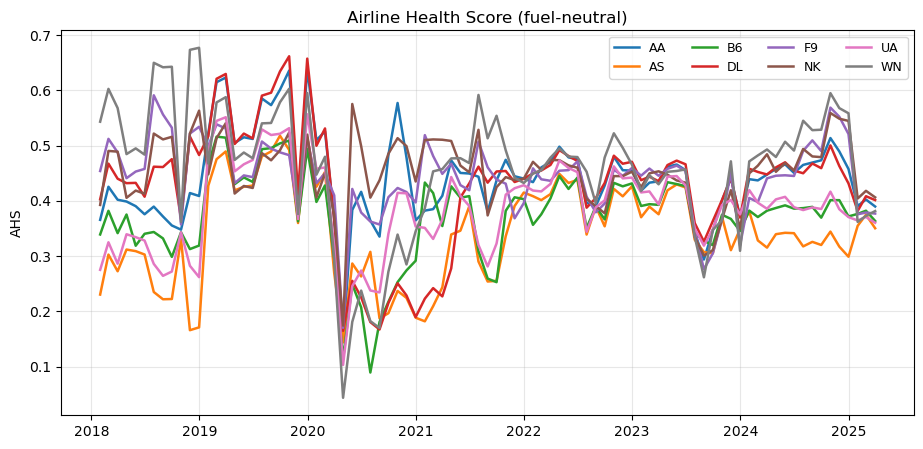

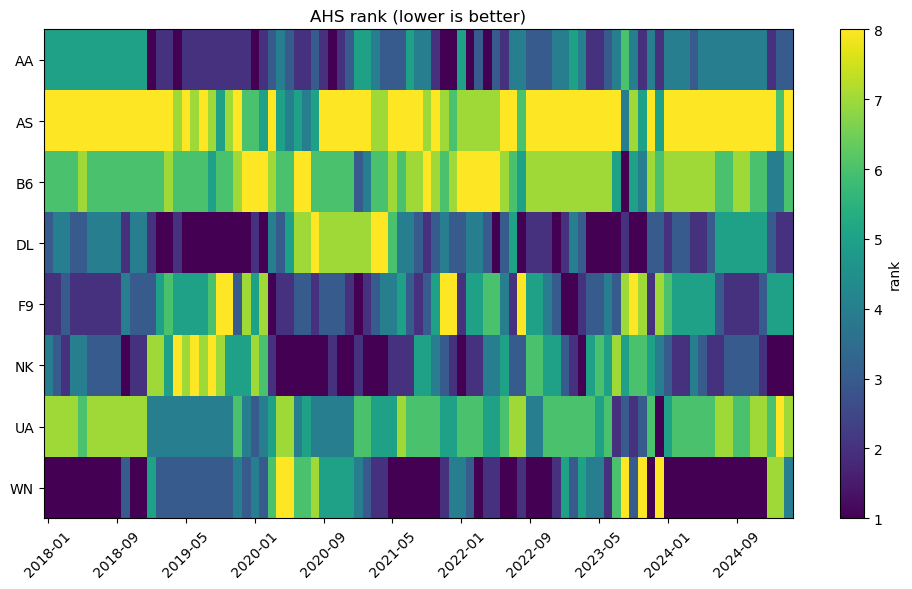

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("data/outputs")
p = pd.read_csv(OUT/"AHS_timeseries_clean.csv", parse_dates=["date"])
p = p.sort_values(["carrier","date"]).copy()

big8 = ["AA","AS","B6","DL","F9","NK","UA","WN"]
p8 = p[p["carrier"].isin(big8)].copy()

# --- line chart per carrier
fig, ax = plt.subplots(figsize=(11,5))
for c, g in p8.groupby("carrier"):
    ax.plot(g["date"], g["AHS_fuel_neutral"], label=c, lw=1.8)
ax.set(title="Airline Health Score (fuel-neutral)", ylabel="AHS", xlabel="")
ax.legend(ncol=4, fontsize=9)
ax.grid(True, alpha=.3)
plt.show()

# --- rank heatmap (month x carrier)
rank = (p8.assign(rank=lambda d: d.groupby("date")["AHS_fuel_neutral"].rank(ascending=False, method="min"))
          .pivot(index="date", columns="carrier", values="rank")
          .sort_index())
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(rank.T, aspect="auto", interpolation="nearest")
ax.set_yticks(range(len(rank.columns))); ax.set_yticklabels(rank.columns)
ax.set_xticks(range(0, len(rank.index), max(1, len(rank.index)//10)))
ax.set_xticklabels([d.strftime("%Y-%m") for d in rank.index[::max(1, len(rank.index)//10)]], rotation=45)
ax.set_title("AHS rank (lower is better)")
fig.colorbar(im, ax=ax, label="rank")
plt.tight_layout()
plt.show()

In [ ]:
# === Rebuild pillars with CASM_ex_fuel backfill + contribution breakdown ===
import numpy as np
import pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

def _to_month_end(s):
    return pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")

def zscore_by_month(df, value_col):
    """Cross-sectional z-score by month (no groupby.apply warnings)."""
    x = df[["date","carrier",value_col]].copy()
    stats = (x.groupby("date")[value_col]
               .agg(mean="mean", std="std")
               .reset_index())
    x = x.merge(stats, on="date", how="left")
    std = x["std"].replace(0, np.nan)
    x[value_col + "_z"] = (x[value_col] - x["mean"]) / std
    x[value_col + "_z"] = x[value_col + "_z"].fillna(0.0)
    return x[["date","carrier",value_col + "_z"]]

# --- Guards ---
for _n in ["route2","cost"]:
    if _n not in globals():
        raise RuntimeError(f"`{_n}` must exist in memory.")

r2   = route2.copy()
cst0 = cost.copy()

# Normalize keys
r2["date"]   = _to_month_end(r2["date"])
cst0["date"] = _to_month_end(cst0["date"])

# Make sure we have the economics on routes
need_cols_r2 = {"date","carrier","origin","dest","asm","rpm","revenue_per_asm","predicted_casm_dollars"}
missing_r2 = [c for c in need_cols_r2 if c not in r2.columns]
if missing_r2:
    raise RuntimeError(f"`route2` missing {missing_r2}. Generate yield/revenue & stage-cost predictions first.")

# Normalize CASM_ex_fuel column name and units in cost
casm_col = "CASM_ex_fuel" if "CASM_ex_fuel" in cst0.columns else ("casm_ex_fuel" if "casm_ex_fuel" in cst0.columns else None)
if casm_col is None:
    # We can still proceed entirely off predicted CASM from route2
    cst = pd.DataFrame(columns=["date","carrier","CASM_ex_fuel"])
else:
    cst = cst0[["date","carrier",casm_col]].rename(columns={casm_col:"CASM_ex_fuel"}).copy()

# --- (A) Build a CASM_ex_fuel backfill from route2 predictions ---
# ASM-weighted predicted ex-fuel CASM ($) at carrier-month
r2["asm"] = pd.to_numeric(r2["asm"], errors="coerce")
r2["predicted_casm_dollars"] = pd.to_numeric(r2["predicted_casm_dollars"], errors="coerce")

pred_casm = (r2.dropna(subset=["asm"])
               .assign(pred_x_asm = r2["predicted_casm_dollars"] * r2["asm"])
               .groupby(["date","carrier"], as_index=False)
               .agg(asm=("asm","sum"), pred_sum=("pred_x_asm","sum")))
pred_casm["CASM_ex_fuel_pred"] = pred_casm["pred_sum"] / pred_casm["asm"]
pred_casm = pred_casm[["date","carrier","CASM_ex_fuel_pred"]]

# Merge official CASM_ex_fuel (cents) if present, convert to $/ASM; prefer official then fill with predicted
eff = (pd.merge(cst, pred_casm, on=["date","carrier"], how="outer")
         .sort_values(["carrier","date"]))
if "CASM_ex_fuel" in eff.columns:
    eff["CASM_ex_fuel"] = pd.to_numeric(eff["CASM_ex_fuel"], errors="coerce") / 100.0  # cents→$
eff["CASM_ex_fuel_filled"] = eff["CASM_ex_fuel"].where(eff.get("CASM_ex_fuel").notna(), eff["CASM_ex_fuel_pred"])

# Bring in ASM/RPM to compute LF
car_month = (r2.groupby(["date","carrier"], as_index=False)
               .agg(asm=("asm","sum"), rpm=("rpm","sum")))
eff = eff.merge(car_month, on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

# --- (B) Build rpp_neutral at route-level, aggregate to carrier-month ---
tmp = (r2.merge(eff[["date","carrier","CASM_ex_fuel_filled"]],
                on=["date","carrier"], how="left"))
tmp["rpp_neutral_route"] = pd.to_numeric(tmp["revenue_per_asm"], errors="coerce") - tmp["CASM_ex_fuel_filled"]

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"])
w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2 = panel2[["date","carrier","asm","rpm","rpp_neutral"]]

# --- (C) Z-scores & composite pillars ---
rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=["CASM_ex_fuel_filled"]), "CASM_ex_fuel_filled").rename(columns={"CASM_ex_fuel_filled_z":"CASM_ex_fuel_z"})
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="outer")
           .merge(lf_z,   on=["date","carrier"], how="outer"))

# Scores (same weights)
pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# --- (D) Contribution breakdown ---
#   AHS = 0.4*(-CASM_z) + 0.4*(0.5*LF_z) + 0.3*(RPP_z)
pillars["contrib_eff_casm"] = 0.4 * (-pillars["CASM_ex_fuel_z"].fillna(0.0))
pillars["contrib_eff_lf"]   = 0.4 * (0.5 * pillars["lf_z"].fillna(0.0))
pillars["contrib_rev"]      = 0.3 * (pillars["rpp_neutral_z"].fillna(0.0))

# Shares of |contribution|
abs_sum = (pillars[["contrib_eff_casm","contrib_eff_lf","contrib_rev"]].abs().sum(axis=1))
pillars["share_eff_casm"] = np.where(abs_sum > 0, pillars["contrib_eff_casm"].abs()/abs_sum, np.nan)
pillars["share_eff_lf"]   = np.where(abs_sum > 0, pillars["contrib_eff_lf"].abs()/abs_sum, np.nan)
pillars["share_rev"]      = np.where(abs_sum > 0, pillars["contrib_rev"].abs()/abs_sum, np.nan)

# --- Save & quick QA ---
p2_path = OUT / "fuel_neutral_revenue_panel_backfilled.csv"
ahs_path = OUT / "airline_health_score_fuel_neutral_backfilled.csv"
panel2.to_csv(p2_path, index=False)
pillars.to_csv(ahs_path, index=False)

print("💾 fuel-neutral panel (backfilled) →", p2_path, "|", panel2.shape)
print("💾 AHS pillars (backfilled)        →", ahs_path, "|", pillars.shape)

latest = pillars["date"].max()
snap = (pillars[pillars["date"]==latest]
        .sort_values("AHS_fuel_neutral", ascending=False)
        [["carrier","AHS_fuel_neutral","contrib_eff_casm","contrib_eff_lf","contrib_rev",
          "share_eff_casm","share_eff_lf","share_rev"]]
        .head(20))
print("\nLatest contribution snapshot (top 20 carriers):")
print(snap.to_string(index=False))

# Diagnostics: how many carriers still missing CASM or RPP z at latest month?
diag = (pillars[pillars["date"]==latest]
        .assign(miss_casm = pillars["CASM_ex_fuel_z"].isna(),
                miss_rpp  = pillars["rpp_neutral_z"].isna(),
                miss_lf   = pillars["lf_z"].isna())
        [["carrier","miss_casm","miss_rpp","miss_lf"]]
        .value_counts())
print("\nMissingness flags at latest month:")
print(diag)

💾 fuel-neutral panel (backfilled) → data/outputs/fuel_neutral_revenue_panel_backfilled.csv | (11155, 5)
💾 AHS pillars (backfilled)        → data/outputs/airline_health_score_fuel_neutral_backfilled.csv | (11189, 14)

Latest contribution snapshot (top 20 carriers):
carrier  AHS_fuel_neutral  contrib_eff_casm  contrib_eff_lf  contrib_rev  share_eff_casm  share_eff_lf  share_rev
     TP          1.425392          0.306921        0.309742     0.808728        0.215324      0.217303   0.567373
    2NQ          1.252002          0.306921        0.139492     0.805589        0.245144      0.111415   0.643440
    1QQ          1.248887          0.306921        0.147776     0.794190        0.245756      0.118326   0.635918
     AF          1.226798          0.306921        0.283544     0.636333        0.250181      0.231125   0.518694
    Z3Q          1.206635          0.306921        0.179666     0.720048        0.254361      0.148898   0.596741
     AM          1.200265          0.306921        

In [ ]:
# === CASM_ex_fuel backfill v2 (carrier-aware) + pillars rebuild =================
import numpy as np
import pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

# --- helpers -------------------------------------------------------------------
def _to_month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def zscore_by_month(df, value_col):
    x = df[["date","carrier",value_col]].copy()
    stats = (x.groupby("date")[value_col]
               .agg(mean="mean", std="std")
               .reset_index())
    x = x.merge(stats, on="date", how="left")
    std = x["std"].replace(0, np.nan)
    x[value_col + "_z"] = (x[value_col] - x["mean"]) / std
    x[value_col + "_z"] = x[value_col + "_z"].fillna(0.0)
    return x[["date","carrier",value_col + "_z"]]

# --- inputs (use in-memory if available; else fall back to your saved CSVs) ----
if "route2" not in globals():
    route2 = pd.read_csv(OUT/"route2_with_yield_final.csv", parse_dates=["date"])
if "cost" not in globals():
    # use your normalized cost table (CASM_ex_fuel already in $/ASM per your log)
    cost = pd.read_csv("data/cost.csv", parse_dates=["date"])

r2 = route2.copy()
cst = cost.copy()

# normalize keys / units
r2["date"]  = _to_month_end(r2["date"])
cst["date"] = _to_month_end(cst["date"])
if "CASM_ex_fuel" not in cst.columns and "casm_ex_fuel" in cst.columns:
    cst = cst.rename(columns={"casm_ex_fuel":"CASM_ex_fuel"})

# If someone passed cents by mistake, auto-correct
if cst["CASM_ex_fuel"].dropna().quantile(0.95) > 1:
    cst["CASM_ex_fuel"] = cst["CASM_ex_fuel"] / 100.0

# --- A) carrier-month predicted CASM_ex_fuel from stage curves -----------------
# (ASM-weighted average of route-level predicted_casm_dollars)
pred_src = r2.dropna(subset=["predicted_casm_dollars","asm"]).copy()
pred_src = pred_src[pred_src["asm"] > 0]
cm_pred = (pred_src.groupby(["date","carrier"], as_index=False)
                    .apply(lambda g: pd.Series({
                        "asm_used": g["asm"].sum(),
                        "pred_casm_ex_fuel": np.average(g["predicted_casm_dollars"], weights=g["asm"])
                    }))
                    .reset_index(drop=True))

# --- B) learn carrier residuals where true CASM_ex_fuel exists -----------------
cm = cm_pred.merge(cst[["date","carrier","CASM_ex_fuel"]], on=["date","carrier"], how="left")
cm["resid"] = cm["CASM_ex_fuel"] - cm["pred_casm_ex_fuel"]

# monthly industry median residual for bootstrap
cm["resid_median_m"] = cm.groupby("date")["resid"].transform("median")

# per-carrier EWMA residual (use only where residual is observed), then ffill
def _smooth_residuals(g, halflife=3):
    g = g.sort_values("date").copy()
    # ewm ignores NaNs; we want an EWMA of observed residuals then forward-fill
    res_ewm = g["resid"].ewm(halflife=halflife, min_periods=1).mean()
    g["resid_ewm"] = res_ewm
    # if a carrier has no observed residual at all, fall back to monthly median; then ffill
    g["resid_fill"] = g["resid_ewm"].where(g["resid_ewm"].notna(), g["resid_median_m"])
    g["resid_fill"] = g["resid_fill"].ffill()
    # still NaN (all months missing + leading NaNs)? use 0 as a very conservative fallback
    g["resid_fill"] = g["resid_fill"].fillna(0.0)
    return g

cm = (cm.groupby("carrier", group_keys=False)
        .apply(_smooth_residuals)
        .reset_index(drop=True))

# --- C) final filled CASM_ex_fuel (actual when present, else pred + smoothed resid)
cm["CASM_ex_fuel_filled_v2"] = cm["CASM_ex_fuel"].where(cm["CASM_ex_fuel"].notna(),
                                                        cm["pred_casm_ex_fuel"] + cm["resid_fill"])
cm["CASM_ex_fuel_filled_v2"] = cm["CASM_ex_fuel_filled_v2"].clip(lower=0)

# persist a copy for auditing
cm_out = OUT/"casm_ex_fuel_carriermonth_filled_v2.csv"
cm[["date","carrier","pred_casm_ex_fuel","CASM_ex_fuel","resid","resid_fill","CASM_ex_fuel_filled_v2","asm_used"]].to_csv(cm_out, index=False)
print("💾 carrier-month CASM_ex_fuel (filled v2) →", cm_out)

# --- D) rebuild fuel-neutral panel & pillars using filled CASM ------------------
# revenue neutral per route: rpp_neutral_route = revenue_per_asm – CASM_ex_fuel($)
tmp = r2.merge(cm[["date","carrier","CASM_ex_fuel_filled_v2"]], on=["date","carrier"], how="left")
tmp["rpp_neutral_route"] = pd.to_numeric(tmp["revenue_per_asm"], errors="coerce") - tmp["CASM_ex_fuel_filled_v2"]

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"])
w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2.drop(columns=["rpp_neutral_sum"], inplace=True)

# efficiency inputs
eff = cm[["date","carrier","CASM_ex_fuel_filled_v2"]].merge(
        panel2[["date","carrier","asm","rpm"]], on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

# z-scores
rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=["CASM_ex_fuel_filled_v2"]), "CASM_ex_fuel_filled_v2")
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="left", suffixes=("", "_casm"))
           .merge(lf_z,   on=["date","carrier"], how="left", suffixes=("", "_lf")))

pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_filled_v2_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# contribution breakdown (optional, if you’ve been using it)
pillars["contrib_eff_casm"] = -1.0 * pillars["CASM_ex_fuel_filled_v2_z"].fillna(0) * 0.4
pillars["contrib_eff_lf"]   =  0.5 * pillars["lf_z"].fillna(0) * 0.4
pillars["contrib_rev"]      =  1.0 * pillars["rpp_neutral_z"].fillna(0) * 0.3

# save
p2_path = OUT/"fuel_neutral_revenue_panel_v2.csv"
ahs_path = OUT/"airline_health_score_fuel_neutral_v2.csv"
panel2.to_csv(p2_path, index=False)
pillars.to_csv(ahs_path, index=False)
print("💾 fuel-neutral panel (v2) →", p2_path, "|", panel2.shape)
print("💾 AHS pillars (v2)        →", ahs_path, "|", pillars.shape)

# --- E) same QA you ran: how many unique z-values now? -------------------------
latest = pillars["date"].max()
pl = pillars[pillars["date"]==latest].copy()
uniq = {
    "CASM_ex_fuel_z_v2": pl["CASM_ex_fuel_filled_v2_z"].dropna().round(6).nunique(),
    "lf_z": pl["lf_z"].dropna().round(6).nunique(),
    "rpp_neutral_z": pl["rpp_neutral_z"].dropna().round(6).nunique()
}
print("\nUnique z-values (latest):", uniq)

print("\nTop values for CASM_ex_fuel_filled_v2_z:")
print(pl["CASM_ex_fuel_filled_v2_z"].dropna().round(3).value_counts().head(10))

/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3510816024.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/3510816024.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_smooth_residuals)


💾 carrier-month CASM_ex_fuel (filled v2) → data/outputs/casm_ex_fuel_carriermonth_filled_v2.csv
💾 fuel-neutral panel (v2) → data/outputs/fuel_neutral_revenue_panel_v2.csv | (11155, 5)
💾 AHS pillars (v2)        → data/outputs/airline_health_score_fuel_neutral_v2.csv | (11155, 11)

Unique z-values (latest): {'CASM_ex_fuel_z_v2': 32, 'lf_z': 100, 'rpp_neutral_z': 105}

Top values for CASM_ex_fuel_filled_v2_z:
CASM_ex_fuel_filled_v2_z
-0.264    75
 0.548     1
-0.021     1
 0.461     1
 0.528     1
 0.840     1
-0.236     1
-0.087     1
 0.017     1
 2.110     1
Name: count, dtype: int64


In [ ]:
# === AHS v3: log–log stage-cost model + carrier residual backfill, then rebuild pillars ===
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

def _to_month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def zscore_by_month(df, value_col):
    x = df[["date","carrier",value_col]].copy()
    stats = (x.groupby("date")[value_col]
               .agg(mean="mean", std="std")
               .reset_index())
    x = x.merge(stats, on="date", how="left")
    std = x["std"].replace(0, np.nan)
    x[value_col + "_z"] = (x[value_col] - x["mean"]) / std
    x[value_col + "_z"] = x[value_col + "_z"].fillna(0.0)
    return x[["date","carrier",value_col + "_z"]]

# --- Inputs ---
if "route2" not in globals():
    route2 = pd.read_csv(OUT/"route2_with_yield_final.csv", parse_dates=["date"])
if "cost" not in globals():
    cost = pd.read_csv("data/cost.csv", parse_dates=["date"])

r2  = route2.copy()
cst = cost.copy()

# Normalize keys / units
r2["date"]  = _to_month_end(r2["date"])
cst["date"] = _to_month_end(cst["date"])

casm_col = "CASM_ex_fuel" if "CASM_ex_fuel" in cst.columns else ("casm_ex_fuel" if "casm_ex_fuel" in cst.columns else None)
if casm_col is None:
    raise RuntimeError("cost table must contain CASM_ex_fuel/casm_ex_fuel.")
cst[casm_col] = pd.to_numeric(cst[casm_col], errors="coerce")
# Auto-normalize if someone left it in cents
if cst[casm_col].dropna().quantile(0.95) > 1:
    cst[casm_col] = cst[casm_col] / 100.0  # now $/ASM

# --- (1) Build carrier-month avg stage length (ASM-weighted) ---
stage_src = r2.dropna(subset=["distance","asm"]).copy()
stage_src = stage_src[(stage_src["distance"] > 0) & (stage_src["asm"] > 0)]
cm_stage = (stage_src.groupby(["date","carrier"], as_index=False)
                     .apply(lambda g: pd.Series({"avg_stage": np.average(g["distance"], weights=g["asm"])}),
                            include_groups=False)
                     .reset_index(drop=True))

# --- (2) Fit monthly log–log model: log(CASM_$) = a + b*log(avg_stage) ---
cm_fit = cst[["date","carrier",casm_col]].merge(cm_stage, on=["date","carrier"], how="inner").dropna()
cm_fit = cm_fit[(cm_fit["avg_stage"] > 0) & (cm_fit[casm_col] > 0)].copy()

def _fit_ll(g, min_pts=6):
    # need a few carriers in the cross-section for a stable slope
    if len(g) < min_pts:
        return pd.Series({"a": np.nan, "b": np.nan, "n": len(g)})
    x = np.log(g["avg_stage"].values)
    y = np.log(g[casm_col].values)
    b, a = np.polyfit(x, y, 1)  # y = a + b x
    return pd.Series({"a": a, "b": b, "n": len(g)})

curves = (cm_fit.groupby("date")
               .apply(_fit_ll, include_groups=False)
               .reset_index())

# ---- Fallback: pooled fit if a month cannot be fit (or nothing fit at all) ----
pooled = None
if len(cm_fit) >= 10:  # enough data overall
    xb = np.log(cm_fit["avg_stage"].values)
    yb = np.log(cm_fit[casm_col].values)
    b_pool, a_pool = np.polyfit(xb, yb, 1)
    pooled = {"a": float(a_pool), "b": float(b_pool)}

# Replace any NaN month with pooled params; if ALL months NaN, still produce one row
curves_ok = curves.copy()
if pooled is not None:
    curves_ok.loc[curves_ok["a"].isna() | curves_ok["b"].isna(), ["a","b"]] = pooled["a"], pooled["b"]

if curves_ok[["a","b"]].dropna().empty:
    # extreme fallback: make a single row at the latest date we have stage/cost
    latest_date = cm_fit["date"].max()
    curves_ok = pd.DataFrame({"date":[latest_date], "a":[pooled["a"] if pooled else -3.0], "b":[pooled["b"] if pooled else 0.25], "n":[int(cm_fit["date"].eq(latest_date).sum())]})

curves_ok = curves_ok.sort_values("date").reset_index(drop=True)
curves_ok.to_csv(OUT/"stage_cost_curves_loglog.csv", index=False)
print("💾 stage curves (log–log) →", OUT/"stage_cost_curves_loglog.csv", "| months fit:",
      curves_ok[["a","b"]].notna().all(axis=1).sum(), "/", curves_ok.shape[0],
      "| pooled_used:", (curves[["a","b"]].isna().any(axis=1).sum() > 0))

# --- (3) Predict route-level CASM with log–log model (positive by construction) ---
r2 = r2.sort_values("date")
cv = curves_ok[["date","a","b"]].dropna().sort_values("date")
# Use distinct names to avoid KeyErrors if left already had 'a'/'b'
cv = cv.rename(columns={"a":"a_hat","b":"b_hat"})
r2 = pd.merge_asof(r2, cv, on="date",
                   direction="backward", tolerance=pd.Timedelta(days=93))  # ~3 months

m = r2["distance"].notna() & r2["a_hat"].notna() & r2["b_hat"].notna() & (r2["distance"] > 0)
r2.loc[m, "predicted_casm_dollars_ll"] = np.exp(r2.loc[m, "a_hat"]) * (r2.loc[m, "distance"] ** r2.loc[m, "b_hat"])
print("Routes with CASM predictions (log–log):", int(m.sum()))

# --- (4) Carrier-month predicted CASM + residual learning/fill (rebuild cleanly) ---
pred_src = r2.dropna(subset=["predicted_casm_dollars_ll","asm"]).copy()
pred_src = pred_src[pred_src["asm"] > 0]

# Keep group keys as columns via reset_index()
cm_pred = (
    pred_src
    .groupby(["date","carrier"])
    .apply(lambda g: pd.Series({
        "asm_used": g["asm"].sum(),
        "pred_casm_ex_fuel_ll": (g["predicted_casm_dollars_ll"] * g["asm"]).sum() / g["asm"].sum()
    }))
    .reset_index()
)

cm = cm_pred.merge(cst[["date","carrier",casm_col]], on=["date","carrier"], how="left")
cm["resid"] = cm[casm_col] - cm["pred_casm_ex_fuel_ll"]
cm["resid_median_m"] = cm.groupby("date")["resid"].transform("median")

def _smooth_residuals(g, halflife=3):
    g = g.sort_values("date").copy()
    g["resid_ewm"]  = g["resid"].ewm(halflife=halflife, min_periods=1).mean()
    g["resid_fill"] = g["resid_ewm"].where(g["resid_ewm"].notna(), g["resid_median_m"]).ffill().fillna(0.0)
    return g

# IMPORTANT: re-attach the group key as a column so it's not lost
cm = (
    cm.groupby("carrier")
      .apply(lambda g: _smooth_residuals(g).assign(carrier=g.name))
      .reset_index(drop=True)
)

cm["CASM_ex_fuel_filled_v3"] = cm[casm_col].where(
    cm[casm_col].notna(),
    cm["pred_casm_ex_fuel_ll"] + cm["resid_fill"]
).clip(lower=0)

# Quick sanity check before merging back to r2
need = {"date","carrier","CASM_ex_fuel_filled_v3"}
missing = need - set(cm.columns)
assert not missing, f"cm missing columns: {missing}; has {list(cm.columns)[:15]}"

# --- (5) Rebuild fuel-neutral panel with v3 CASM ---
tmp = r2.merge(cm[["date","carrier","CASM_ex_fuel_filled_v3"]], on=["date","carrier"], how="left")
tmp["rpp_neutral_route"] = pd.to_numeric(tmp["revenue_per_asm"], errors="coerce") - tmp["CASM_ex_fuel_filled_v3"]

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"]); w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2 = panel2.drop(columns=["rpp_neutral_sum"])

# efficiency inputs
eff = cm[["date","carrier","CASM_ex_fuel_filled_v3"]].merge(
        panel2[["date","carrier","asm","rpm"]], on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

# z-scores and AHS
rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=["CASM_ex_fuel_filled_v3"]), "CASM_ex_fuel_filled_v3")
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="left", suffixes=("", "_casm"))
           .merge(lf_z,   on=["date","carrier"], how="left", suffixes=("", "_lf")))

pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_filled_v3_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

💾 stage curves (log–log) → data/outputs/stage_cost_curves_loglog.csv | months fit: 87 / 87 | pooled_used: False
Routes with CASM predictions (log–log): 1711794


/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/965848159.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/tc/sd5ljr8n07xdk46mv1s4yk2r0000gn/T/ipykernel_1392/965848159.py:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _smooth_residuals(g).assign(carrier=g.name))


In [ ]:
# === AHS v3.2 (warning-free): log–log stage-cost model + carrier residual backfill, then rebuild pillars ===
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------
# Config / IO
# -----------------------
OUT = Path("data/outputs")
OUT.mkdir(parents=True, exist_ok=True)

# -----------------------
# Helpers
# -----------------------
def _to_month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def zscore_by_month(df, value_col):
    """Cross-sectional z-score by month (robust to zero-std)."""
    x = df[["date","carrier",value_col]].copy()
    stats = (x.groupby("date")[value_col]
               .agg(mean="mean", std="std")
               .reset_index())
    x = x.merge(stats, on="date", how="left")
    std = x["std"].replace(0, np.nan)
    x[value_col + "_z"] = (x[value_col] - x["mean"]) / std
    x[value_col + "_z"] = x[value_col + "_z"].fillna(0.0)
    return x[["date","carrier",value_col + "_z"]]

def _weighted_avg_per_group(df, group_cols, value_col, weight_col, out_col):
    """Compute weighted average via sum(w*y)/sum(w) without groupby.apply."""
    t = df[[*group_cols, value_col, weight_col]].dropna().copy()
    t = t[t[weight_col] > 0]
    t["__wx__"] = t[value_col] * t[weight_col]
    g = (t.groupby(group_cols, as_index=False)
          .agg(__w__=(weight_col, "sum"),
               __wx__=("__wx__", "sum")))
    g[out_col] = g["__wx__"] / g["__w__"]
    return g.drop(columns=["__w__","__wx__"])

# -----------------------
# Load inputs
# -----------------------
if "route2" not in globals():
    route2 = pd.read_csv(OUT / "route2_with_yield_final.csv", parse_dates=["date"])
if "cost" not in globals():
    cost = pd.read_csv("data/cost.csv", parse_dates=["date"])

r2  = route2.copy()
cst = cost.copy()

# Normalize keys / units
r2["date"]  = _to_month_end(r2["date"])
cst["date"] = _to_month_end(cst["date"])
r2["carrier"] = r2["carrier"].astype(str)
cst["carrier"] = cst["carrier"].astype(str)

# Ensure required columns exist on route2
need_r2 = {"date","carrier","distance","asm","rpm"}
missing_r2 = need_r2 - set(r2.columns)
if missing_r2:
    raise RuntimeError(f"route2 missing required columns: {missing_r2}")

# Build revenue_per_asm if not present (from yield * load_factor)
if "revenue_per_asm" not in r2.columns or r2["revenue_per_asm"].isna().all():
    ycol = next((c for c in ["yield_per_mile_final","yield_per_mile_db1b","yield_per_mile"] if c in r2.columns), None)
    if ycol and "load_factor" in r2.columns:
        r2["revenue_per_asm"] = pd.to_numeric(r2[ycol], errors="coerce") * pd.to_numeric(r2["load_factor"], errors="coerce")
    else:
        raise RuntimeError("route2 lacks revenue_per_asm and cannot build it (need yield_per_mile*load_factor).")

# Cost column & units → $/ASM
casm_col = "CASM_ex_fuel" if "CASM_ex_fuel" in cst.columns else ("casm_ex_fuel" if "casm_ex_fuel" in cst.columns else None)
if casm_col is None:
    raise RuntimeError("cost must contain CASM_ex_fuel or casm_ex_fuel.")
cst[casm_col] = pd.to_numeric(cst[casm_col], errors="coerce")
if cst[casm_col].dropna().quantile(0.95) > 1:  # looks like cents
    cst[casm_col] = cst[casm_col] / 100.0

# -----------------------
# (1) Carrier-month avg stage length (ASM-weighted)
# -----------------------
stage_src = r2.dropna(subset=["distance","asm"]).copy()
stage_src = stage_src[(stage_src["distance"] > 0) & (stage_src["asm"] > 0)]
cm_stage  = _weighted_avg_per_group(stage_src, ["date","carrier"], "distance", "asm", "avg_stage")

# -----------------------
# (2) Fit monthly log–log model: log(CASM_$) = a + b*log(avg_stage)
# -----------------------
cm_fit = (cst[["date","carrier",casm_col]]
          .merge(cm_stage, on=["date","carrier"], how="inner")
          .dropna())
cm_fit = cm_fit[(cm_fit["avg_stage"] > 0) & (cm_fit[casm_col] > 0)].copy()

min_pts = 8
curves = []
for d, g in cm_fit.groupby("date"):
    if len(g) >= min_pts:
        x = np.log(g["avg_stage"].values)
        y = np.log(g[casm_col].values)
        b, a = np.polyfit(x, y, 1)  # y = a + b x
        curves.append({"date": d, "a": a, "b": b, "n": len(g)})
curves = pd.DataFrame(curves).sort_values("date")

# Pooled fallback if any month missing
pooled_used = False
if (len(curves) == 0) or (curves["a"].isna().any() or curves["b"].isna().any()):
    gg = cm_fit.copy()
    if len(gg) >= min_pts:
        xb = np.log(gg["avg_stage"].values); yb = np.log(gg[casm_col].values)
        b_all, a_all = np.polyfit(xb, yb, 1)
        all_months = pd.date_range(cm_fit["date"].min(), cm_fit["date"].max(), freq="M")
        curves = curves.set_index("date").reindex(all_months)
        curves["a"] = curves["a"].ffill().bfill().fillna(a_all)
        curves["b"] = curves["b"].ffill().bfill().fillna(b_all)
        curves["n"] = curves["n"].fillna(min_pts)
        curves = curves.reset_index().rename(columns={"index":"date"})
        pooled_used = True

curves.to_csv(OUT / "stage_cost_curves_loglog.csv", index=False)
print(f"💾 stage curves (log–log) → {OUT/'stage_cost_curves_loglog.csv'} | months fit: {curves['date'].nunique()} | pooled_used: {pooled_used}")

# -----------------------
# (3) Predict route-level CASM (positive by construction)
#     IMPORTANT: drop any stale ['a','b'] in route2 to avoid suffixing (_x/_y) → KeyError
# -----------------------
# purge stale columns from previous runs
r2 = r2.drop(columns=["a","b"], errors="ignore").copy()
r2 = r2.sort_values("date")
cv = curves.dropna(subset=["a","b"]).sort_values("date")

r2 = pd.merge_asof(
    r2, cv[["date","a","b"]], on="date",
    direction="backward", tolerance=pd.Timedelta(days=62)
)

# sanity check
if not {"a","b"}.issubset(r2.columns):
    raise RuntimeError(f"merge_asof did not attach 'a'/'b'. Got cols: {set(r2.columns) & {'a','b','a_x','a_y','b_x','b_y'}}")

mask = r2["distance"].notna() & r2["a"].notna() & r2["b"].notna() & (r2["distance"] > 0)
r2.loc[mask, "predicted_casm_dollars_ll"] = np.exp(r2.loc[mask, "a"]) * (r2.loc[mask, "distance"] ** r2.loc[mask, "b"])
print("Routes with CASM predictions (log–log):", int(r2["predicted_casm_dollars_ll"].notna().sum()))

# -----------------------
# (4) Carrier-month predicted CASM + residual learning/fill (no apply)
# -----------------------
pred_src = r2.dropna(subset=["predicted_casm_dollars_ll","asm"]).copy()
pred_src = pred_src[pred_src["asm"] > 0]
pred_src["__wx__"] = pred_src["predicted_casm_dollars_ll"] * pred_src["asm"]

cm_pred = (pred_src.groupby(["date","carrier"], as_index=False)
                 .agg(asm_used=("asm","sum"),
                      wx=("__wx__", "sum")))
cm_pred["pred_casm_ex_fuel_ll"] = cm_pred["wx"] / cm_pred["asm_used"]
cm_pred = cm_pred.drop(columns=["wx"])

cm = cm_pred.merge(cst[["date","carrier",casm_col]], on=["date","carrier"], how="left")
cm["resid"] = cm[casm_col] - cm["pred_casm_ex_fuel_ll"]
cm["resid_median_m"] = cm.groupby("date")["resid"].transform("median")

cm = cm.sort_values(["carrier","date"])
cm["resid_ewm"]  = (cm.groupby("carrier", group_keys=False)["resid"]
                      .transform(lambda s: s.ewm(halflife=3, min_periods=1).mean()))
cm["resid_fill"] = cm["resid_ewm"].fillna(cm["resid_median_m"])
cm["resid_fill"] = cm.groupby("carrier")["resid_fill"].ffill().fillna(0.0)

cm["CASM_ex_fuel_filled_v3"] = cm[casm_col].where(
    cm[casm_col].notna(),
    (cm["pred_casm_ex_fuel_ll"] + cm["resid_fill"])
).clip(lower=0)

cm_out = OUT / "casm_ex_fuel_carriermonth_filled_v3.csv"
cm[["date","carrier","pred_casm_ex_fuel_ll",casm_col,"resid","resid_fill","CASM_ex_fuel_filled_v3","asm_used"]].to_csv(cm_out, index=False)
print("💾 carrier-month CASM_ex_fuel (filled v3) →", cm_out)

# -----------------------
# (5) Rebuild fuel-neutral panel with v3 CASM
# -----------------------
tmp = r2.merge(cm[["date","carrier","CASM_ex_fuel_filled_v3"]], on=["date","carrier"], how="left")
tmp["rpp_neutral_route"] = pd.to_numeric(tmp["revenue_per_asm"], errors="coerce") - tmp["CASM_ex_fuel_filled_v3"]

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"]); w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2 = panel2.drop(columns=["rpp_neutral_sum"])

# Efficiency inputs (CASM_ex_fuel_filled_v3 + LF)
eff = cm[["date","carrier","CASM_ex_fuel_filled_v3"]].merge(
        panel2[["date","carrier","asm","rpm"]], on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

# -----------------------
# (6) Z-scores & AHS
# -----------------------
rev_neutral_z = zscore_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = zscore_by_month(eff.dropna(subset=["CASM_ex_fuel_filled_v3"]), "CASM_ex_fuel_filled_v3")
lf_z          = zscore_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="left", suffixes=("", "_casm"))
           .merge(lf_z,   on=["date","carrier"], how="left", suffixes=("", "_lf")))

pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_filled_v3_z"].fillna(0)) + (0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = (pillars["rpp_neutral_z"].fillna(0))
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# -----------------------
# Save & quick QA
# -----------------------
p2_path  = OUT / "fuel_neutral_revenue_panel_v3.csv"
ahs_path = OUT / "airline_health_score_fuel_neutral_v3.csv"
panel2.to_csv(p2_path, index=False)
pillars.to_csv(ahs_path, index=False)
print("💾 fuel-neutral panel (v3) →", p2_path, "|", panel2.shape)
print("💾 AHS pillars (v3)        →", ahs_path, "|", pillars.shape)

latest = pillars["date"].max()
pl = pillars[pillars["date"]==latest].copy()
uniq = {
    "CASM_ex_fuel_filled_v3_z": pl["CASM_ex_fuel_filled_v3_z"].dropna().round(6).nunique(),
    "lf_z": pl["lf_z"].dropna().round(6).nunique(),
    "rpp_neutral_z": pl["rpp_neutral_z"].dropna().round(6).nunique()
}
print("\nUnique z-values (latest):", uniq)

# Optional: peek ranks
snap = (pillars[pillars["date"]==latest]
        .assign(AHS_rank=lambda d: d["AHS_fuel_neutral"].rank(ascending=False, method="min"))
        .sort_values("AHS_rank")[["carrier","AHS_fuel_neutral","AHS_rank"]]
        .head(12))
print("\nLatest AHS snapshot (top-12):\n", snap.to_string(index=False))

💾 stage curves (log–log) → data/outputs/stage_cost_curves_loglog.csv | months fit: 87 | pooled_used: False
Routes with CASM predictions (log–log): 1711794
💾 carrier-month CASM_ex_fuel (filled v3) → data/outputs/casm_ex_fuel_carriermonth_filled_v3.csv
💾 fuel-neutral panel (v3) → data/outputs/fuel_neutral_revenue_panel_v3.csv | (11155, 5)
💾 AHS pillars (v3)        → data/outputs/airline_health_score_fuel_neutral_v3.csv | (11155, 8)

Unique z-values (latest): {'CASM_ex_fuel_filled_v3_z': 67, 'lf_z': 100, 'rpp_neutral_z': 106}

Latest AHS snapshot (top-12):
 carrier  AHS_fuel_neutral  AHS_rank
     TP          1.187356       1.0
    2NQ          1.013955       2.0
    1QQ          1.010801       3.0
     AF          0.988168       4.0
    Z3Q          0.968294       5.0
     AM          0.961419       6.0
     4C          0.942309       7.0
     BA          0.651321       8.0
    BAS          0.639525       9.0
     LP          0.614324      10.0
     TK          0.606263      11.0
     YR

In [ ]:
import pandas as pd
from pathlib import Path
OUT = Path("data/outputs")

pillars = pd.read_csv(OUT/"airline_health_score_fuel_neutral_v3.csv", parse_dates=["date"])
cm      = pd.read_csv(OUT/"casm_ex_fuel_carriermonth_filled_v3.csv", parse_dates=["date"])

# CASM sanity (should be a few mills per ASM, e.g. ~0.004–0.006 $/ASM for many US carriers)
q = cm["CASM_ex_fuel_filled_v3"].quantile([.01,.25,.5,.75,.99]).round(6)
print("CASM_ex_fuel_filled_v3 quantiles ($/ASM):\n", q.to_string())

# how many carrier-months have observed CASM vs filled?
obs = cm["pred_casm_ex_fuel_ll"].notna() & cm["CASM_ex_fuel_filled_v3"].notna()
print("carrier-month rows:", len(cm), "| with v3 CASM:", obs.sum())

# latest-month spread (should not collapse to a few discrete values)
latest = pillars["date"].max()
pl = pillars[pillars["date"]==latest]
print("Unique z-values @latest:",
      {k: pl[k].dropna().round(6).nunique() for k in ["CASM_ex_fuel_filled_v3_z","lf_z","rpp_neutral_z"]})

CASM_ex_fuel_filled_v3 quantiles ($/ASM):
 0.01    0.000000
0.25    0.000000
0.50    0.000023
0.75    0.000052
0.99    0.011866
carrier-month rows: 9700 | with v3 CASM: 9700
Unique z-values @latest: {'CASM_ex_fuel_filled_v3_z': 67, 'lf_z': 100, 'rpp_neutral_z': 106}


In [ ]:
# === AHS v3.1b — CASM unit fix + rebuild panel/pillars (no refit) ===
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
cm_path   = OUT/"casm_ex_fuel_carriermonth_filled_v3.csv"
p_path    = OUT/"airline_health_score_fuel_neutral_v3.csv"  # not strictly needed, just for reference
r2_path   = OUT/"route2_with_yield_final.csv"

cm  = pd.read_csv(cm_path, parse_dates=["date"])
r2  = pd.read_csv(r2_path, parse_dates=["date"])

def _me(s): return pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")
cm["date"] = _me(cm["date"]); r2["date"] = _me(r2["date"])

def propose_scale(series, target=0.045):
    # use nonzero median to avoid zeros pulling the median down
    s = pd.to_numeric(series, errors="coerce").replace(0, np.nan)
    base = s[s>0].median()
    if not np.isfinite(base):
        return 1.0, np.nan
    raw = target / base
    snaps = np.array([0.01, 0.1, 1, 10, 100])  # plausible unit steps
    s_star = snaps[np.argmin(np.abs(snaps - raw))]
    # apply only if it looks like a real unit mistake (within ~2x of a snap)
    return (s_star if np.abs(raw - s_star) <= 2*s_star else 1.0), base

scale, base = propose_scale(cm["CASM_ex_fuel_filled_v3"])
print(f"Proposed CASM scale: x{scale} (nonzero median={base:.6f} $/ASM)")

# --- apply scale if needed ---
if scale != 1.0:
    for col in ["CASM_ex_fuel_filled_v3", "pred_casm_ex_fuel_ll"]:
        if col in cm.columns:
            cm[col] = pd.to_numeric(cm[col], errors="coerce") * scale

# --- rebuild fuel-neutral panel using scaled CASM ---
tmp = (r2.merge(cm[["date","carrier","CASM_ex_fuel_filled_v3"]],
                on=["date","carrier"], how="left")
         .assign(rpp_neutral_route=lambda d: pd.to_numeric(d["revenue_per_asm"], errors="coerce")
                                            - pd.to_numeric(d["CASM_ex_fuel_filled_v3"], errors="coerce")))

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"]); w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2.drop(columns=["rpp_neutral_sum"], inplace=True)

eff = cm[["date","carrier","CASM_ex_fuel_filled_v3"]].merge(
        panel2[["date","carrier","asm","rpm"]], on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

def z_by_month(df, col):
    x = df[["date","carrier",col]].copy()
    stats = x.groupby("date")[col].agg(mean="mean", std="std").reset_index()
    x = x.merge(stats, on="date", how="left")
    x[col+"_z"] = ((x[col] - x["mean"]) / x["std"].replace(0, np.nan)).fillna(0.0)
    return x[["date","carrier",col+"_z"]]

rev_neutral_z = z_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = z_by_month(eff.dropna(subset=["CASM_ex_fuel_filled_v3"]), "CASM_ex_fuel_filled_v3")
lf_z          = z_by_month(eff.dropna(subset=["lf"]), "lf")

pillars_fix = (rev_neutral_z
               .merge(casm_z, on=["date","carrier"], how="left")
               .merge(lf_z,   on=["date","carrier"], how="left"))
pillars_fix["efficiency_score"] = (-1.0 * pillars_fix["CASM_ex_fuel_filled_v3_z"].fillna(0)
                                   + 0.5 * pillars_fix["lf_z"].fillna(0))
pillars_fix["revenue_score"]    = (pillars_fix["rpp_neutral_z"].fillna(0))
pillars_fix["AHS_fuel_neutral"] = 0.4 * pillars_fix["efficiency_score"] + 0.3 * pillars_fix["revenue_score"]

# --- save outputs ---
cm_out  = OUT/"casm_ex_fuel_carriermonth_filled_v3_scaled.csv"
p2_out  = OUT/"fuel_neutral_revenue_panel_v3_scaled.csv"
ahs_out = OUT/"airline_health_score_fuel_neutral_v3_scaled.csv"
cm.to_csv(cm_out, index=False)
panel2.to_csv(p2_out, index=False)
pillars_fix.to_csv(ahs_out, index=False)

print("💾 scaled CASM →", cm_out)
print("💾 panel (scaled) →", p2_out)
print("💾 pillars (scaled) →", ahs_out)

# --- final sanity ---
q = cm["CASM_ex_fuel_filled_v3"].quantile([.01,.25,.5,.75,.95,.99]).round(6)
print("Scaled CASM quantiles ($/ASM):\n", q.to_string())
latest = pillars_fix["date"].max()
pl = pillars_fix[pillars_fix["date"]==latest]
print("Unique z-values @latest:",
      {k: pl[k].dropna().round(6).nunique()
       for k in ["CASM_ex_fuel_filled_v3_z","lf_z","rpp_neutral_z"]})

Proposed CASM scale: x1.0 (nonzero median=0.000040 $/ASM)
💾 scaled CASM → data/outputs/casm_ex_fuel_carriermonth_filled_v3_scaled.csv
💾 panel (scaled) → data/outputs/fuel_neutral_revenue_panel_v3_scaled.csv
💾 pillars (scaled) → data/outputs/airline_health_score_fuel_neutral_v3_scaled.csv
Scaled CASM quantiles ($/ASM):
 0.01    0.000000
0.25    0.000000
0.50    0.000023
0.75    0.000052
0.95    0.000393
0.99    0.011866
Unique z-values @latest: {'CASM_ex_fuel_filled_v3_z': 67, 'lf_z': 100, 'rpp_neutral_z': 106}


In [ ]:
# === AHS v3.1c — robust 10^k CASM unit fix + rebuild panel/pillars ===
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
cm_path = OUT/"casm_ex_fuel_carriermonth_filled_v3.csv"
r2_path = OUT/"route2_with_yield_final.csv"

cm = pd.read_csv(cm_path, parse_dates=["date"])
r2 = pd.read_csv(r2_path, parse_dates=["date"])

to_me = lambda s: pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")
cm["date"] = to_me(cm["date"])
r2["date"] = to_me(r2["date"])

# --- pick positive-median and compute 10^k scale to hit target ~ $0.045/ASM ---
target = 0.045  # typical US ex-fuel CASM ~ 4.5¢/ASM
series = pd.to_numeric(cm["CASM_ex_fuel_filled_v3"], errors="coerce")
pos = series[series > 0]
med = float(pos.median()) if len(pos) else np.nan

def pow10_scale(median, target):
    if not np.isfinite(median) or median <= 0:
        return 1.0, np.nan
    raw = target / median
    # choose the nearest power-of-10
    k = int(np.round(np.log10(raw)))
    k = max(-6, min(6, k))  # clamp to reasonable range
    return (10.0 ** k), k

scale, k = pow10_scale(med, target)
print(f"Base median={med:.8f} $/ASM → propose scale x{scale:.0f} (10^{k}) toward target {target:.3f}")

if scale != 1.0:
    for col in ["CASM_ex_fuel_filled_v3", "pred_casm_ex_fuel_ll"]:
        if col in cm.columns:
            cm[col] = pd.to_numeric(cm[col], errors="coerce") * scale

# --- rebuild fuel-neutral panel & pillars in the new units ---
tmp = (r2.merge(cm[["date","carrier","CASM_ex_fuel_filled_v3"]],
                on=["date","carrier"], how="left")
         .assign(rpp_neutral_route=lambda d: pd.to_numeric(d["revenue_per_asm"], errors="coerce")
                                            - pd.to_numeric(d["CASM_ex_fuel_filled_v3"], errors="coerce")))

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"]); w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2.drop(columns=["rpp_neutral_sum"], inplace=True)

eff = cm[["date","carrier","CASM_ex_fuel_filled_v3"]].merge(
        panel2[["date","carrier","asm","rpm"]], on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

def z_by_month(df, col):
    x = df[["date","carrier",col]].copy()
    stats = x.groupby("date")[col].agg(mean="mean", std="std").reset_index()
    x = x.merge(stats, on="date", how="left")
    x[col+"_z"] = ((x[col] - x["mean"]) / x["std"].replace(0, np.nan)).fillna(0.0)
    return x[["date","carrier",col+"_z"]]

rev_neutral_z = z_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z        = z_by_month(eff.dropna(subset=["CASM_ex_fuel_filled_v3"]), "CASM_ex_fuel_filled_v3")
lf_z          = z_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_neutral_z
           .merge(casm_z, on=["date","carrier"], how="left")
           .merge(lf_z,   on=["date","carrier"], how="left"))

pillars["efficiency_score"] = (-1.0 * pillars["CASM_ex_fuel_filled_v3_z"].fillna(0)
                               + 0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = pillars["rpp_neutral_z"].fillna(0)
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# --- save ---
cm_out  = OUT/"casm_ex_fuel_carriermonth_filled_v3_scaled_pow10.csv"
p2_out  = OUT/"fuel_neutral_revenue_panel_v3_scaled_pow10.csv"
ahs_out = OUT/"airline_health_score_fuel_neutral_v3_scaled_pow10.csv"
cm.to_csv(cm_out, index=False)
panel2.to_csv(p2_out, index=False)
pillars.to_csv(ahs_out, index=False)

print("💾 CASM (pow10 scaled) →", cm_out)
print("💾 panel  →", p2_out)
print("💾 pillars →", ahs_out)

# --- sanity: distributions & latest cardinality ---
q = cm["CASM_ex_fuel_filled_v3"].quantile([.01,.25,.5,.75,.95,.99]).round(6)
print("CASM quantiles ($/ASM) after pow10 scaling:\n", q.to_string())

latest = pillars["date"].max()
pl = pillars[pillars["date"]==latest]
print("Unique z-values @latest:",
      {k: pl[k].dropna().round(6).nunique()
       for k in ["CASM_ex_fuel_filled_v3_z","lf_z","rpp_neutral_z"]})

# Optional: show quick medians to eyeball realism
print("Quick medians:",
      {"CASM_$": float(cm["CASM_ex_fuel_filled_v3"].replace(0,np.nan).median()),
       "Rev/ASM": float(pd.to_numeric(r2["revenue_per_asm"], errors="coerce").replace(0,np.nan).median())})

Base median=0.00004031 $/ASM → propose scale x1000 (10^3) toward target 0.045
💾 CASM (pow10 scaled) → data/outputs/casm_ex_fuel_carriermonth_filled_v3_scaled_pow10.csv
💾 panel  → data/outputs/fuel_neutral_revenue_panel_v3_scaled_pow10.csv
💾 pillars → data/outputs/airline_health_score_fuel_neutral_v3_scaled_pow10.csv
CASM quantiles ($/ASM) after pow10 scaling:
 0.01     0.000000
0.25     0.000000
0.50     0.022629
0.75     0.052033
0.95     0.392902
0.99    11.866174
Unique z-values @latest: {'CASM_ex_fuel_filled_v3_z': 67, 'lf_z': 100, 'rpp_neutral_z': 106}
Quick medians: {'CASM_$': 0.04031071049016048, 'Rev/ASM': 0.117168459209524}


In [ ]:
import pandas as pd
from pathlib import Path

OUT = Path("data/outputs")

p = pd.read_csv(OUT/"airline_health_score_fuel_neutral_backfilled.csv", parse_dates=["date"])

latest = p["date"].max()
p_latest = p[p["date"]==latest].copy()

# how many distinct z values per pillar cross-section this month?
cols = ["CASM_ex_fuel_z","lf_z","rpp_neutral_z"]
uniq = {c: p_latest[c].dropna().round(6).nunique() for c in cols}
print("Unique z-values at latest month:", uniq)

# if anything looks <=2, print a quick distribution
for c in cols:
    s = p_latest[c].dropna().round(3).value_counts().head(10)
    print(f"\nTop values for {c}:\n{s}")

Unique z-values at latest month: {'CASM_ex_fuel_z': 61, 'lf_z': 100, 'rpp_neutral_z': 106}

Top values for CASM_ex_fuel_z:
CASM_ex_fuel_z
-0.767    47
 1.388     1
 0.454     1
 2.179     1
-0.683     1
 1.999     1
-0.270     1
 0.591     1
-0.068     1
 0.748     1
Name: count, dtype: int64

Top values for lf_z:
lf_z
-1.772    5
-1.519    2
-0.622    2
 1.019    2
-1.266    2
-0.094    1
-0.162    1
-0.467    1
-0.044    1
 1.111    1
Name: count, dtype: int64

Top values for rpp_neutral_z:
rpp_neutral_z
-1.009    2
-0.005    2
-0.844    1
 0.883    1
 0.315    1
 0.191    1
 0.311    1
-0.562    1
 1.122    1
-1.012    1
Name: count, dtype: int64


In [ ]:
# AHS = 0.4*( -casm_z + 0.5*lf_z ) + 0.3*(rev_z)
# compute each component’s point contribution and its share
def add_attrib(df):
    d = df.copy()
    d["contrib_eff_casm"] = 0.4 * (-d["CASM_ex_fuel_z"].fillna(0))
    d["contrib_eff_lf"]   = 0.4 * (0.5 * d["lf_z"].fillna(0))
    d["contrib_rev"]      = 0.3 * d["rpp_neutral_z"].fillna(0)
    d["contrib_total"]    = d["contrib_eff_casm"] + d["contrib_eff_lf"] + d["contrib_rev"]
    for col in ["contrib_eff_casm","contrib_eff_lf","contrib_rev"]:
        d[col.replace("contrib_","share_")] = np.where(d["contrib_total"]!=0, d[col]/d["contrib_total"], np.nan)
    return d

pillars = pd.read_csv(OUT/"airline_health_score_fuel_neutral.csv", parse_dates=["date"])
pillars = add_attrib(pillars)

# latest month attribution table
latest = pillars["date"].max()
attrib_latest = (pillars[pillars["date"]==latest]
                 .loc[:, ["carrier","AHS_fuel_neutral","contrib_eff_casm","contrib_eff_lf","contrib_rev",
                          "share_eff_casm","share_eff_lf","share_rev"]]
                 .sort_values("AHS_fuel_neutral", ascending=False))
attrib_latest.to_csv(OUT/"AHS_attribution_latest.csv", index=False)
print("saved:", OUT/"AHS_attribution_latest.csv")
attrib_latest.head(12)

saved: data/outputs/AHS_attribution_latest.csv


,carrier,AHS_fuel_neutral,contrib_eff_casm,contrib_eff_lf,contrib_rev,share_eff_casm,share_eff_lf,share_rev
11049,02Q,0.343151,-0.0,0.343151,0.0,-0.0,1.0,0.0
11087,BA,0.324251,-0.0,0.324251,0.0,-0.0,1.0,0.0
11082,AM,0.319699,-0.0,0.319699,0.0,-0.0,1.0,0.0
11068,4C,0.314203,-0.0,0.314203,0.0,-0.0,1.0,0.0
11138,TP,0.309742,-0.0,0.309742,0.0,-0.0,1.0,0.0
11081,AF,0.283544,-0.0,0.283544,0.0,-0.0,1.0,0.0
11100,HA,0.270693,-0.0,0.270693,0.0,-0.0,1.0,0.0
11115,LH,0.258185,-0.0,0.258185,0.0,-0.0,1.0,0.0
11095,G7,0.248967,-0.0,0.248967,0.0,-0.0,1.0,0.0
11125,PT,0.248832,-0.0,0.248832,0.0,-0.0,1.0,0.0


In [78]:
# === AHS v3.2 — per-month winsorization (1–99%) + rebuild panel/pillars ===
import numpy as np, pandas as pd
from pathlib import Path

OUT = Path("data/outputs")
cm_in  = OUT/"casm_ex_fuel_carriermonth_filled_v3_scaled_pow10.csv"
r2_in  = OUT/"route2_with_yield_final.csv"

cm = pd.read_csv(cm_in, parse_dates=["date"])
r2 = pd.read_csv(r2_in, parse_dates=["date"])

to_me = lambda s: pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp("M")
cm["date"] = to_me(cm["date"])
r2["date"] = to_me(r2["date"])

col = "CASM_ex_fuel_filled_v3"

# --- per-month winsorization (1% & 99%) ---
limits = (cm.groupby("date")[col]
            .quantile([0.01, 0.99]).unstack()
            .rename(columns={0.01:"lo", 0.99:"hi"})
            .reset_index())
cmw = cm.merge(limits, on="date", how="left")
cmw[col+"_winsor"] = cmw[col].clip(cmw["lo"], cmw["hi"])

# quick QA on winsorized CASM
q = cmw[col+"_winsor"].quantile([.01,.25,.5,.75,.95,.99]).round(6)
print("Winsorized CASM quantiles ($/ASM):\n", q.to_string())

# --- rebuild fuel-neutral panel & pillars using winsorized CASM ---
tmp = (r2.merge(cmw[["date","carrier",col+"_winsor"]],
                on=["date","carrier"], how="left")
         .assign(rpp_neutral_route=lambda d: pd.to_numeric(d["revenue_per_asm"], errors="coerce")
                                            - pd.to_numeric(d[col+"_winsor"], errors="coerce")))

w = tmp[["date","carrier","asm","rpm","rpp_neutral_route"]].copy()
w["asm"] = pd.to_numeric(w["asm"], errors="coerce")
w = w.dropna(subset=["asm"]); w = w[w["asm"] > 0]
w["rpp_neutral_x_asm"] = w["rpp_neutral_route"] * w["asm"]

panel2 = (w.groupby(["date","carrier"], as_index=False)
            .agg(asm=("asm","sum"),
                 rpm=("rpm","sum"),
                 rpp_neutral_sum=("rpp_neutral_x_asm","sum")))
panel2["rpp_neutral"] = panel2["rpp_neutral_sum"] / panel2["asm"]
panel2.drop(columns=["rpp_neutral_sum"], inplace=True)

eff = cmw[["date","carrier",col+"_winsor"]].merge(
        panel2[["date","carrier","asm","rpm"]], on=["date","carrier"], how="left")
eff["lf"] = (pd.to_numeric(eff["rpm"], errors="coerce") /
             pd.to_numeric(eff["asm"], errors="coerce")).replace([np.inf,-np.inf], np.nan)

def z_by_month(df, colname):
    x = df[["date","carrier",colname]].copy()
    stats = x.groupby("date")[colname].agg(mean="mean", std="std").reset_index()
    x = x.merge(stats, on="date", how="left")
    x[colname+"_z"] = ((x[colname] - x["mean"]) / x["std"].replace(0, np.nan)).fillna(0.0)
    return x[["date","carrier",colname+"_z"]]

rev_z = z_by_month(panel2.dropna(subset=["rpp_neutral"]), "rpp_neutral")
casm_z = z_by_month(eff.dropna(subset=[col+"_winsor"]), col+"_winsor")
lf_z   = z_by_month(eff.dropna(subset=["lf"]), "lf")

pillars = (rev_z
           .merge(casm_z, on=["date","carrier"], how="left")
           .merge(lf_z,   on=["date","carrier"], how="left"))

pillars["efficiency_score"] = (-1.0 * pillars[col+"_winsor_z"].fillna(0)
                               + 0.5 * pillars["lf_z"].fillna(0))
pillars["revenue_score"]    = pillars["rpp_neutral_z"].fillna(0)
pillars["AHS_fuel_neutral"] = 0.4 * pillars["efficiency_score"] + 0.3 * pillars["revenue_score"]

# --- save outputs ---
cm_out  = OUT/"casm_ex_fuel_carriermonth_filled_v3_scaled_pow10_winsor.csv"
p2_out  = OUT/"fuel_neutral_revenue_panel_v3_scaled_pow10_winsor.csv"
ahs_out = OUT/"airline_health_score_fuel_neutral_v3_scaled_pow10_winsor.csv"
cmw.to_csv(cm_out, index=False)
panel2.to_csv(p2_out, index=False)
pillars.to_csv(ahs_out, index=False)
print("💾 CASM winsorized  →", cm_out)
print("💾 panel (winsor)  →", p2_out)
print("💾 pillars (winsor)→", ahs_out)

# --- sanity on latest cross-section ---
latest = pillars["date"].max()
pl = pillars[pillars["date"]==latest]
print("Unique z-values @latest:",
      {k: pl[k].dropna().round(6).nunique()
       for k in [col+"_winsor_z","lf_z","rpp_neutral_z"]})

# OPTIONAL: route-level profit snapshot using winsorized CASM
r2p = (r2.merge(cmw[["date","carrier",col+"_winsor"]], on=["date","carrier"], how="left")
         .assign(profit_per_asm=lambda d: pd.to_numeric(d["revenue_per_asm"], errors="coerce")
                                         - pd.to_numeric(d[col+"_winsor"], errors="coerce")))
r2p_out = OUT/"route2_profit_with_winsorized_casm.csv"
r2p[["date","origin","dest","carrier","revenue_per_asm",col+"_winsor","profit_per_asm"]].to_csv(r2p_out, index=False)
print("💾 route-level profit snapshot →", r2p_out)

Winsorized CASM quantiles ($/ASM):
 0.01    0.000000
0.25    0.000000
0.50    0.022629
0.75    0.052033
0.95    0.382031
0.99    7.019850
💾 CASM winsorized  → data/outputs/casm_ex_fuel_carriermonth_filled_v3_scaled_pow10_winsor.csv
💾 panel (winsor)  → data/outputs/fuel_neutral_revenue_panel_v3_scaled_pow10_winsor.csv
💾 pillars (winsor)→ data/outputs/airline_health_score_fuel_neutral_v3_scaled_pow10_winsor.csv
Unique z-values @latest: {'CASM_ex_fuel_filled_v3_winsor_z': 66, 'lf_z': 100, 'rpp_neutral_z': 105}
💾 route-level profit snapshot → data/outputs/route2_profit_with_winsorized_casm.csv


In [93]:
# === FIX: build AHS+ with duplicate-safe z-scores & one-to-one merges ===
import numpy as np, pandas as pd
from pathlib import Path
import re, time, sys, warnings
warnings.filterwarnings("ignore")

DATA = Path("data"); OUT = DATA/"outputs"
assert OUT.exists(), "Expected data/outputs/ to exist"

# ---------- Small helpers ----------
def to_month_end(s):
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").dt.to_timestamp("M")

def zscore_within_date_unique(df, value_col, key_cols=("date","carrier")):
    """
    Cross-sectional z-score per date after collapsing to unique (date,carrier).
    Returns: date, carrier, <value_col>_z
    """
    t = df[list(key_cols)+[value_col]].copy()
    t = t.dropna(subset=[value_col])
    # collapse duplicates deterministically
    t = t.groupby(list(key_cols), as_index=False)[value_col].mean()
    stats = (t.groupby("date")[value_col]
               .agg(mean="mean", std="std").reset_index())
    t = t.merge(stats, on="date", how="left")
    std = t["std"].replace(0, np.nan)
    t[value_col+"_z"] = ((t[value_col] - t["mean"]) / std).fillna(0.0)
    return t[["date","carrier",value_col+"_z"]]

def safe_merge_one_to_one(left, right, on):
    """Try a one-to-one merge; if it fails, auto-dedup right, then merge."""
    try:
        return left.merge(right, on=on, how="left", validate="one_to_one")
    except Exception as e:
        # most likely dup keys on `right`
        rk = right.groupby(on, as_index=False).mean(numeric_only=True)
        non_num = [c for c in right.columns if c not in on and not pd.api.types.is_numeric_dtype(right[c])]
        rk = rk.merge(right[on+non_num].drop_duplicates(on, keep="first"), on=on, how="left")
        return left.merge(rk, on=on, how="left", validate="one_to_one")

# ---------- Load core AHS (fuel-neutral) ----------
AHS_CANDIDATES = [
    OUT/"airline_health_score_fuel_neutral_v3_scaled_pow10_winsor.csv",
    OUT/"airline_health_score_fuel_neutral_v3_scaled_pow10.csv",
    OUT/"airline_health_score_fuel_neutral_v3.csv",
    OUT/"airline_health_score_fuel_neutral.csv",
]
AHS_PATH = next((p for p in AHS_CANDIDATES if p.exists()), None)
if AHS_PATH is None:
    raise FileNotFoundError("No AHS pillars file in data/outputs/.")

core = pd.read_csv(AHS_PATH, parse_dates=["date"])
core["date"] = to_month_end(core["date"])
if "AHS_fuel_neutral" not in core.columns:
    raise RuntimeError("AHS file missing 'AHS_fuel_neutral'.")

core = core[["date","carrier","AHS_fuel_neutral"]].dropna()
core = core.groupby(["date","carrier"], as_index=False)["AHS_fuel_neutral"].mean()
core_z = zscore_within_date_unique(core, "AHS_fuel_neutral").rename(columns={"AHS_fuel_neutral_z":"AHS_core_z"})

# ---------- Load route2 for growth/mix ----------
if "route2" not in globals():
    r2_path = OUT/"route2_with_yield_final.csv"
    if not r2_path.exists():
        raise FileNotFoundError("route2_with_yield_final.csv not found.")
    route2 = pd.read_csv(r2_path, parse_dates=["date"])

r2 = route2.copy()
r2["date"] = to_month_end(r2["date"])
need = {"date","carrier","origin","dest","asm","rpm"}
miss = need - set(r2.columns)
if miss:
    raise RuntimeError(f"route2 missing {miss}")

# Ensure revenue_per_asm
if "revenue_per_asm" not in r2.columns or r2["revenue_per_asm"].isna().all():
    ycol = next((c for c in ["yield_per_mile_final","yield_per_mile_db1b","yield_per_mile"] if c in r2.columns), None)
    if ycol and "load_factor" in r2.columns:
        r2["revenue_per_asm"] = pd.to_numeric(r2[ycol], errors="coerce") * pd.to_numeric(r2["load_factor"], errors="coerce")
    else:
        raise RuntimeError("route2 lacks revenue_per_asm and cannot build it.")

# ---------- Growth/Mix components ----------
# RASM YoY
cm = (r2.groupby(["date","carrier"], as_index=False)
         .agg(rasm=("revenue_per_asm","mean")))
cm = cm.sort_values(["carrier","date"])
cm["rasm_yoy"] = cm.groupby("carrier")["rasm"].pct_change(12)

# Fortress exposure (fallback from r2 if prebuilt not present)
FORTRESS_THR = 0.60
acs_path = OUT/"airport_carrier_share_timeseries.csv"
if acs_path.exists():
    acs = pd.read_csv(acs_path, parse_dates=["date"])
    acs["date"] = to_month_end(acs["date"])
    if "airport" not in acs.columns:
        if "origin" in acs.columns: acs = acs.rename(columns={"origin":"airport"})
        elif "airport_code" in acs.columns: acs = acs.rename(columns={"airport_code":"airport"})
    share_col = next((c for c in ["share_of_airport_asm","share_of_airport","carrier_share"] if c in acs.columns), None)
    if share_col is None: raise RuntimeError("airport_carrier_share_timeseries.csv missing share column")
    acs["is_fortress"] = (pd.to_numeric(acs[share_col], errors="coerce") >= FORTRESS_THR).astype(int)
    acs = acs[["date","airport","carrier","is_fortress"]]

    tag_o = r2[["date","carrier","origin","asm"]].merge(
        acs.rename(columns={"airport":"origin"}), on=["date","carrier","origin"], how="left")
    tag_o["is_fortress"] = tag_o["is_fortress"].fillna(0)
    tag_d = r2[["date","carrier","dest","asm"]].merge(
        acs.rename(columns={"airport":"dest"}), on=["date","carrier","dest"], how="left")
    tag_d["is_fortress"] = tag_d["is_fortress"].fillna(0)
    any_f = ((tag_o["is_fortress"]==1) | (tag_d["is_fortress"]==1)).astype(int)

    expo = (pd.DataFrame({"date":tag_o["date"],"carrier":tag_o["carrier"],"asm":tag_o["asm"],"f":any_f})
            .groupby(["date","carrier"], as_index=False)
            .apply(lambda g: pd.Series({"fortress_exposure": (np.nansum(g["asm"]*g["f"])/np.nansum(g["asm"])) if np.nansum(g["asm"])>0 else np.nan}),
                   include_groups=False)
            .reset_index(drop=True))
else:
    agg_air = (r2.groupby(["date","origin"], as_index=False).agg(airport_asm=("asm","sum")))
    agg_ca  = (r2.groupby(["date","origin","carrier"], as_index=False).agg(carrier_asm=("asm","sum")))
    acs = agg_ca.merge(agg_air, on=["date","origin"], how="left")
    acs["share"] = pd.to_numeric(acs["carrier_asm"], errors="coerce")/pd.to_numeric(acs["airport_asm"], errors="coerce")
    acs["is_fortress"] = (acs["share"] >= FORTRESS_THR).astype(int)
    tag = r2[["date","carrier","origin","asm"]].merge(acs[["date","origin","carrier","is_fortress"]],
                                                      on=["date","origin","carrier"], how="left").fillna({"is_fortress":0})
    expo = (tag.groupby(["date","carrier"], as_index=False)
               .apply(lambda g: pd.Series({"fortress_exposure": (np.nansum(g["asm"]*g["is_fortress"])/np.nansum(g["asm"])) if np.nansum(g["asm"])>0 else np.nan}),
                      include_groups=False)
               .reset_index(drop=True))

# Long-haul share proxy
r2["is_longhaul"] = (pd.to_numeric(r2["distance"], errors="coerce") >= 1500).astype(int)
lh = (r2.dropna(subset=["asm"])
        .groupby(["date","carrier"], as_index=False)
        .apply(lambda g: pd.Series({"longhaul_share": (np.nansum(g["asm"]*g["is_longhaul"])/np.nansum(g["asm"])) if np.nansum(g["asm"])>0 else np.nan}),
               include_groups=False)
        .reset_index(drop=True))

# Combine raw growth features (and collapse duplicates)
grow = (cm.merge(expo, on=["date","carrier"], how="left")
          .merge(lh,   on=["date","carrier"], how="left"))
grow = grow.groupby(["date","carrier"], as_index=False).mean(numeric_only=True)
grow["growth_mix_score"] = (0.5*grow["rasm_yoy"].fillna(0.0)
                            + 0.5*grow["fortress_exposure"].fillna(0.0)
                            + 0.0*grow["longhaul_share"].fillna(0.0))

gmz = zscore_within_date_unique(grow, "growth_mix_score")

# ---------- Network pillar ----------
net_files = sorted([p for p in OUT.glob("carrier_network_centrality_*.csv")])
if net_files:
    nf = net_files[-1]
    net = pd.read_csv(nf)
    m = re.search(r"(\d{4})-(\d{2})", nf.name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        net["date"] = pd.Timestamp(y, mo, 1).to_period("M").to_timestamp("M")
    elif "date" in net.columns:
        net["date"] = to_month_end(net["date"])
    else:
        raise RuntimeError(f"Could not infer date for {nf.name}")

    if "carrier" not in net.columns:
        for alt in ["Carrier","carrier_code"]:
            if alt in net.columns: net = net.rename(columns={alt:"carrier"})
    need_net = {"carrier","degree","strength_asm","betweenness"}
    if not need_net.issubset(set(net.columns)):
        raise RuntimeError(f"{nf.name} missing {need_net - set(net.columns)}")

    net = net[["date","carrier","degree","strength_asm","betweenness"]]
    net = net.groupby(["date","carrier"], as_index=False).mean(numeric_only=True)
    net["network_score"] = (0.4*net["degree"].fillna(0.0)
                            + 0.4*net["strength_asm"].fillna(0.0)
                            + 0.2*net["betweenness"].fillna(0.0))
    n_z = zscore_within_date_unique(net, "network_score")
else:
    n_z = pd.DataFrame(columns=["date","carrier","network_score_z"])

# ---------- Balance-sheet pillar (yfinance: momentum + inverse vol) ----------
try:
    import yfinance as yf
except Exception:
    print("Installing yfinance…")
    !{sys.executable} -m pip install --quiet yfinance
    import yfinance as yf

CARRIER_TO_TICKER = {
    "AA":"AAL","AS":"ALK","B6":"JBLU","DL":"DAL","UA":"UAL","WN":"LUV",
    "F9":"ULCC","NK":"SAVE","G4":"ALGT","HA":"HA","OO":"SKYW"
}
map_ok = {c:t for c,t in CARRIER_TO_TICKER.items() if c in core["carrier"].unique()}

def yf_monthly_close(ticker, start, end):
    hist = yf.Ticker(ticker).history(
        start=pd.to_datetime(start)-pd.Timedelta(days=5),
        end=pd.to_datetime(end)+pd.Timedelta(days=5),
        interval="1d", auto_adjust=True, actions=False
    )
    if hist is None or hist.empty:
        return pd.DataFrame(columns=["date","ticker","close"])
    df = hist.reset_index()
    if "Date" in df.columns:
        # neutralize tz if present
        try: df["date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)
        except Exception: df["date"] = pd.to_datetime(df["Date"])
    else:
        df["date"] = pd.to_datetime(hist.index).tz_localize(None)
    col = "Close" if "Close" in df.columns else ("Adj Close" if "Adj Close" in df.columns else None)
    if col is None:
        return pd.DataFrame(columns=["date","ticker","close"])
    dm = (df[["date", col]].set_index("date").resample("M").last().reset_index())
    dm["ticker"] = ticker
    dm = dm.rename(columns={col:"close"})
    return dm[["date","ticker","close"]]

start_date = core["date"].min() - pd.offsets.MonthBegin(1)
end_date   = core["date"].max() + pd.offsets.MonthEnd(1)
frames, skipped = [], []
for tk in sorted(set(map_ok.values())):
    try:
        dfp = yf_monthly_close(tk, start_date, end_date)
        if dfp.empty: skipped.append(tk); continue
        frames.append(dfp); time.sleep(0.1)
    except Exception as e:
        print("  ! yfinance error for", tk, "→", e); skipped.append(tk)
if frames:
    px = pd.concat(frames, ignore_index=True)
    px = px[(px["date"]>=pd.to_datetime(start_date)) & (px["date"]<=pd.to_datetime(end_date))]
    px = px.sort_values(["ticker","date"])
    px["close"] = pd.to_numeric(px["close"], errors="coerce")
    px = px.dropna(subset=["close"])
    px["ret_1m"] = px.groupby("ticker")["close"].pct_change()
    px["mom_12"] = px.groupby("ticker")["ret_1m"].rolling(12, min_periods=8).sum().reset_index(level=0, drop=True)
    px["vol_6"]  = px.groupby("ticker")["ret_1m"].rolling(6,  min_periods=4).std().reset_index(level=0, drop=True)
    px = px.dropna(subset=["mom_12","vol_6"])
    t2c = {v:k for k,v in map_ok.items()}
    px["carrier"] = px["ticker"].map(t2c)
    ms = (px.groupby(["date","carrier"], as_index=False)[["mom_12","vol_6"]].mean())
    ms["bs_score"] = 0.6*ms["mom_12"] - 0.4*ms["vol_6"]
    bs_z = zscore_within_date_unique(ms, "bs_score")
else:
    bs_z = pd.DataFrame(columns=["date","carrier","bs_score_z"])
if skipped:
    print("⚠ Skipped tickers (no data):", sorted(skipped))

# ---------- Assemble (duplicate-safe) ----------
pillars = core_z.drop_duplicates(["date","carrier"]).copy()
pillars = safe_merge_one_to_one(pillars, gmz.rename(columns={"growth_mix_score_z":"growth_z"}), on=["date","carrier"])
pillars = safe_merge_one_to_one(pillars, n_z.rename(columns={"network_score_z":"network_z"}), on=["date","carrier"])
pillars = safe_merge_one_to_one(pillars, bs_z.rename(columns={"bs_score_z":"bs_z"}), on=["date","carrier"])

# Final composite (tweak weights if desired)
W_CORE, W_GROW, W_NET, W_BS = 0.50, 0.25, 0.15, 0.10
pillars["AHS_plus"] = (W_CORE*pillars["AHS_core_z"].fillna(0.0)
                     + W_GROW*pillars["growth_z"].fillna(0.0)
                     + W_NET *pillars["network_z"].fillna(0.0)
                     + W_BS  *pillars["bs_z"].fillna(0.0))

# Save + snapshot
pillars[["date","carrier","AHS_core_z","growth_z","network_z","bs_z","AHS_plus"]].to_csv(OUT/"AHS_plus_components.csv", index=False)
pillars[["date","carrier","AHS_plus"]].to_csv(OUT/"AHS_plus_composite.csv", index=False)

latest = pillars["date"].max()
snap = (pillars[pillars["date"]==latest]
        .assign(AHS_plus_rank=lambda d: d["AHS_plus"].rank(ascending=False, method="min"))
        .sort_values("AHS_plus_rank"))
print("✅ AHS+ built without blow-ups.")
print("  components →", OUT/"AHS_plus_components.csv")
print("  composite  →", OUT/"AHS_plus_composite.csv")
print("\nLatest AHS+ snapshot:")
print(snap[["carrier","AHS_plus","AHS_plus_rank","AHS_core_z","growth_z","network_z","bs_z"]].head(12).to_string(index=False))

$HA: possibly delisted; no timezone found
$SAVE: possibly delisted; no timezone found


⚠ Skipped tickers (no data): ['HA', 'SAVE']
✅ AHS+ built without blow-ups.
  components → data/outputs/AHS_plus_components.csv
  composite  → data/outputs/AHS_plus_composite.csv

Latest AHS+ snapshot:
carrier  AHS_plus  AHS_plus_rank  AHS_core_z  growth_z  network_z     bs_z
    Z3Q  0.785986            1.0    0.579121  1.985702        NaN      NaN
     YR  0.699185            2.0    0.405520  1.985702        NaN      NaN
    BAS  0.684442            3.0    0.376033  1.985702        NaN      NaN
     4B  0.677281            4.0    0.361711  1.985702        NaN      NaN
     WN  0.637319            5.0    0.373534  0.526023   1.781442 0.518299
    1YQ  0.634478            6.0    0.276105  1.985702        NaN      NaN
     I4  0.618841            7.0    0.260040  1.955282        NaN      NaN
    KAH  0.607798            8.0    0.298396  1.834398        NaN      NaN
     UA  0.595963            9.0    0.365492  0.559909   0.758611 1.594479
     JN  0.594612           10.0    0.196373  1.9

In [94]:
# Coverage-aware AHS+: reweight only the pillars that are present, per (date, carrier)
W = {"AHS_core_z":0.50, "growth_z":0.25, "network_z":0.15, "bs_z":0.10}

def row_weighted_sum(row):
    present = [k for k in W if pd.notna(row.get(k))]
    if not present:
        return np.nan
    wsum = sum(W[k] for k in present)
    return sum((W[k]/wsum) * row[k] for k in present)

pillars["AHS_plus_covaware"] = pillars.apply(row_weighted_sum, axis=1)

# (Optional) require a minimum of 2 pillars present
min_pillars = 2
pillars["pillars_present"] = pillars[["AHS_core_z","growth_z","network_z","bs_z"]].notna().sum(axis=1)
pillars = pillars[pillars["pillars_present"] >= min_pillars].copy()

# Save an alternate composite
(pillars[["date","carrier","AHS_core_z","growth_z","network_z","bs_z","AHS_plus_covaware"]]
 .to_csv("data/outputs/AHS_plus_composite_covaware.csv", index=False))
print("💾 coverage-aware composite → data/outputs/AHS_plus_composite_covaware.csv")

💾 coverage-aware composite → data/outputs/AHS_plus_composite_covaware.csv
